In [3]:
import requests
import pandas as pd
import numpy as np
import json
import re
from bs4 import BeautifulSoup
import zipfile
import os
from datetime import datetime
from functools import reduce
from scipy.stats import norm, uniform, beta, lognorm
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.isotonic import IsotonicRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import shap
import openpyxl
import xlrd
from tqdm import tqdm
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import RandomOverSampler
from IPython.display import clear_output
sns.set(style="whitegrid")

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% ! important; }<style>"))
pd.reset_option('display.max_colwidth')

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 14)
    plt.yticks(tick_marks, classes, fontsize = 14)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=25)

    plt.tight_layout()
    plt.ylabel('Реальное значение целевой переменной', fontsize = 16)
    plt.xlabel('Предсказанное значение целевой переменной', fontsize = 16)

In [3]:
# функция для извлечения даты из строки и преобразования её в datetime
def parse_and_format_date(string):
    match = re.search(r'(\d{1,2})\s([а-яА-я]+)\s(\d{4})\sг.', string)
    if match:
        day = int(match.group(1))
        month = months[match.group(2)]
        year = int(match.group(3))
        date = datetime(year, month, day)
        return str(pd.to_datetime(date).date())
    
    
# функция для создания маски по дате  
def check_date(x):
    try:
        pd.to_datetime(x, format='%Y-%m-%d')
        return True
    except ValueError:
        return False
    
def extract_number(text):
    try:
        license_number = re.search('лицензия НОМЕР (.*?),', text).group(1)
        if license_number.isdigit():
            return license_number
        else:
            return None
    except AttributeError:
        return None

In [4]:
def expected_calibration_error(y, proba, bins = 'fd'):
    # Расчёт гистограммы вероятностей. 
    # Возвращаемые значения: количество элементов в каждом бине (bin_count) и границы бинов (bin_edges)
    bin_count, bin_edges = np.histogram(proba, bins = bins)

    # Количество бинов
    n_bins = len(bin_count)

    # Первый бин не включается в np.digitize, поэтому мы делаем небольшое смещение влево
    bin_edges[0] -= 1e-8

    # Распределение вероятностей по бинам. Каждому значению proba присваивается id бина, к которому оно относится
    bin_id = np.digitize(proba, bin_edges, right = True) - 1

    # Сумма вероятностей для каждого бина
    bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)

    # Сумма вероятностей для каждого бина
    bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)

    # Среднее значение вероятности для каждого бина
    bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)

    # Среднее значение вероятности для каждого бина
    bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)

    # Расчёт ожидаемой погрешности калибровки (ECE).
    # Итоговая погрешность является взвешенной суммой абсолютных различий 
    # между средним значением вероятности в бине и средней точной вероятностью по бину.
    ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)

    # Возвращает ECE
    return ece

In [1]:
cols_rating_new = ['rating_AKM_rus', 'rating_exra_rus',
       'rating_fitch_long', 'rating_fitch_rus', 'rating_moody_long',
       'rating_moody_rus', 'rating_NRA_rus', 'rating_rusrate',
       'rating_rusrate_rus', 'rating_sp_long', 'rating_sp_rus',
       'rating_sp_short', 'rating_AKM_rus_shift_1', 'rating_AKM_rus_shift_3', 'rating_AKM_rus_shift_6', 'rating_AKM_rus_shift_12', 'rating_AKM_rus_diff_1', 'rating_AKM_rus_diff_3', 'rating_AKM_rus_diff_6', 'rating_AKM_rus_diff_12', 'rating_exra_rus_shift_1', 'rating_exra_rus_shift_3', 'rating_exra_rus_shift_6', 'rating_exra_rus_shift_12', 'rating_exra_rus_diff_1', 'rating_exra_rus_diff_3', 'rating_exra_rus_diff_6', 'rating_exra_rus_diff_12', 'rating_fitch_long_shift_1', 'rating_fitch_long_shift_3', 'rating_fitch_long_shift_6', 'rating_fitch_long_shift_12', 'rating_fitch_long_diff_1', 'rating_fitch_long_diff_3', 'rating_fitch_long_diff_6', 'rating_fitch_long_diff_12', 'rating_fitch_rus_shift_1', 'rating_fitch_rus_shift_3', 'rating_fitch_rus_shift_6', 'rating_fitch_rus_shift_12', 'rating_fitch_rus_diff_1', 'rating_fitch_rus_diff_3', 'rating_fitch_rus_diff_6', 'rating_fitch_rus_diff_12', 'rating_moody_long_shift_1', 'rating_moody_long_shift_3', 'rating_moody_long_shift_6', 'rating_moody_long_shift_12', 'rating_moody_long_diff_1', 'rating_moody_long_diff_3', 'rating_moody_long_diff_6', 'rating_moody_long_diff_12', 'rating_moody_rus_shift_1', 'rating_moody_rus_shift_3', 'rating_moody_rus_shift_6', 'rating_moody_rus_shift_12', 'rating_moody_rus_diff_1', 'rating_moody_rus_diff_3', 'rating_moody_rus_diff_6', 'rating_moody_rus_diff_12', 'rating_NRA_rus_shift_1', 'rating_NRA_rus_shift_3', 'rating_NRA_rus_shift_6', 'rating_NRA_rus_shift_12', 'rating_NRA_rus_diff_1', 'rating_NRA_rus_diff_3', 'rating_NRA_rus_diff_6', 'rating_NRA_rus_diff_12', 'rating_rusrate_shift_1', 'rating_rusrate_shift_3', 'rating_rusrate_shift_6', 'rating_rusrate_shift_12', 'rating_rusrate_diff_1', 'rating_rusrate_diff_3', 'rating_rusrate_diff_6', 'rating_rusrate_diff_12', 'rating_rusrate_rus_shift_1', 'rating_rusrate_rus_shift_3', 'rating_rusrate_rus_shift_6', 'rating_rusrate_rus_shift_12', 'rating_rusrate_rus_diff_1', 'rating_rusrate_rus_diff_3', 'rating_rusrate_rus_diff_6', 'rating_rusrate_rus_diff_12', 'rating_sp_long_shift_1', 'rating_sp_long_shift_3', 'rating_sp_long_shift_6', 'rating_sp_long_shift_12', 'rating_sp_long_diff_1', 'rating_sp_long_diff_3', 'rating_sp_long_diff_6', 'rating_sp_long_diff_12', 'rating_sp_rus_shift_1', 'rating_sp_rus_shift_3', 'rating_sp_rus_shift_6', 'rating_sp_rus_shift_12', 'rating_sp_rus_diff_1', 'rating_sp_rus_diff_3', 'rating_sp_rus_diff_6', 'rating_sp_rus_diff_12', 'rating_sp_short_shift_1', 'rating_sp_short_shift_3', 'rating_sp_short_shift_6', 'rating_sp_short_shift_12', 'rating_sp_short_diff_1', 'rating_sp_short_diff_3', 'rating_sp_short_diff_6', 'rating_sp_short_diff_12']


In [4]:
df_main_rating = pd.read_excel('rating_dataset.xlsx')
df_main_rating.reset_index(drop=True, inplace=True)
df_main_rating = df_main_rating.drop(['Unnamed: 0'], axis=1)

In [11]:
df_main_rating

date       company  rating_AKM_rus  rating_exra_rus  \
0     2015-01  АБСОЛЮТ БАНК             100                5   
1     2015-02  АБСОЛЮТ БАНК             100                5   
2     2015-03  АБСОЛЮТ БАНК             100                5   
3     2015-04  АБСОЛЮТ БАНК             100                5   
4     2015-05  АБСОЛЮТ БАНК             100                5   
...       ...           ...             ...              ...   
7620  2017-08      ЮНИСТРИМ             100               15   
7621  2017-09      ЮНИСТРИМ             100               15   
7622  2017-10      ЮНИСТРИМ             100               15   
7623  2017-11      ЮНИСТРИМ             100               15   
7624  2017-12      ЮНИСТРИМ             100               15   

      rating_fitch_long  rating_fitch_rus  rating_moody_long  \
0                    14                 7                 14   
1                    14                 7                 14   
2                    14                 7                 14   
3                    14                 7                 14   
4                    14                 7                 14   
...                 ...               ...                ...   
7620                100               100                100   
7621                100               100                100   
7622                100               100                100   
7623                100               100                100   
7624                100               100                100   

      rating_moody_rus  rating_NRA_rus  rating_rusrate  ...  \
0                    6             100             100  ...   
1                    6             100             100  ...   
2                    6             100             100  ...   
3                    6             100             100  ...   
4                    6             100             100  ...   
...                ...             ...             ...  ...   
7620               100             100             100  ...   
7621               100             100             100  ...   
7622               100             100             100  ...   
7623               100             100             100  ...   
7624               100             100             100  ...   

      rating_sp_rus_diff_6  rating_sp_rus_diff_12  rating_sp_short_shift_1  \
0                      100                    100                      100   
1                      100                    100                      100   
2                      100                    100                      100   
3                      100                    100                      100   
4                      100                    100                      100   
...                    ...                    ...                      ...   
7620                   100                    100                      100   
7621                   100                    100                      100   
7622                   100                    100                      100   
7623                   100                    100                      100   
7624                   100                    100                      100   

      rating_sp_short_shift_3  rating_sp_short_shift_6  \
0                         100                      100   
1                         100                      100   
2                         100                      100   
3                         100                      100   
4                         100                      100   
...                       ...                      ...   
7620                      100                      100   
7621                      100                      100   
7622                      100                      100   
7623                      100                      100   
7624                      100                      100   

      rating_sp_short_shift_12  rating_sp_short_diff_1  \
0                     

In [6]:
oot = df_main_rating[df_main_rating['date'] >= '2017-05']
train = df_main_rating[df_main_rating['date'] < '2017-05']
calibration = df_main_rating[(df_main_rating['date'] < '2017-05') & (df_main_rating['date'] >= '2017-02')]
print(oot.default.mean(), train.default.mean())

0.014164305949008499 0.023301858056655498


In [7]:
X_train, X_val, y_train, y_val = train_test_split(train[cols_rating_new],
                                                  train['default'],
                                                  test_size=0.2,
                                                  random_state=42)

In [8]:
X_oot = oot[cols_rating_new]
y_oot = oot['default']
X_calibration = calibration[cols_rating_new]
y_calibration = calibration['default']

In [10]:
X_calibration

rating_AKM_rus  rating_exra_rus  rating_fitch_long  rating_fitch_rus  \
24               100                8                 14                 7   
25               100                8                 14                 7   
26               100                8                 14                 7   
59               100              100                100               100   
60               100              100                100               100   
...              ...              ...                ...               ...   
7579             100              100                 10                 1   
7580             100              100                 10                 1   
7614             100                8                100               100   
7615             100                8                100               100   
7616             100                8                100               100   

      rating_moody_long  rating_moody_rus  rating_NRA_rus  rating_rusrate  \
24                   14                 6             100             100   
25                   14                 6             100             100   
26                   14                 6             100             100   
59                   15                 8             100              10   
60                   15                 8             100              10   
...                 ...               ...             ...             ...   
7579                100               100             100             100   
7580                100               100             100             100   
7614                100               100             100             100   
7615                100               100             100             100   
7616                100               100             100             100   

      rating_rusrate_rus  rating_sp_long  ...  rating_sp_rus_diff_6  \
24                   100             100  ...                   100   
25                   100             100  ...                   100   
26                   100             100  ...                   100   
59                     5             100  ...                   100   
60                     5             100  ...                   100   
...                  ...             ...  ...                   ...   
7579                 100              11  ...                   100   
7580                 100              11  ...                   100   
7614                 100             100  ...                   100   
7615                 100             100  ...                   100   
7616                 100             100  ...                   100   

      rating_sp_rus_diff_12  rating_sp_short_shift_1  rating_sp_short_shift_3  \
24                      100                      100                      100   
25                      100                      100                      100   
26                      100                      100                      100   
59                      100                      100                      100   
60                      100                      100                      100   
...                     ...                      ...                      ...   
7579                    100                        4                        4   
7580                    100                        4                        4   
7614                    100                      100                      100   
7615                    100                      100                      100   
7616                    100                      100                      100   

      rating_sp_short_shift_6  rating_sp_short_shift_12  \
24                        100                       100   
25                        100                       100   
26                        100                       100   
59                        100                       100   
60                     

### Логистическая регрессия

In [10]:
logistic = LogisticRegression(C=0.5, penalty = 'l2', max_iter=100, n_jobs=-1, random_state=42)
logistic.fit(X_train, y_train)
logistic.score(X_val, y_val)

0.982496194824962

In [11]:
print(classification_report(y_val, logistic.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1291
           1       0.00      0.00      0.00        23

    accuracy                           0.98      1314
   macro avg       0.49      0.50      0.50      1314
weighted avg       0.97      0.98      0.97      1314



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


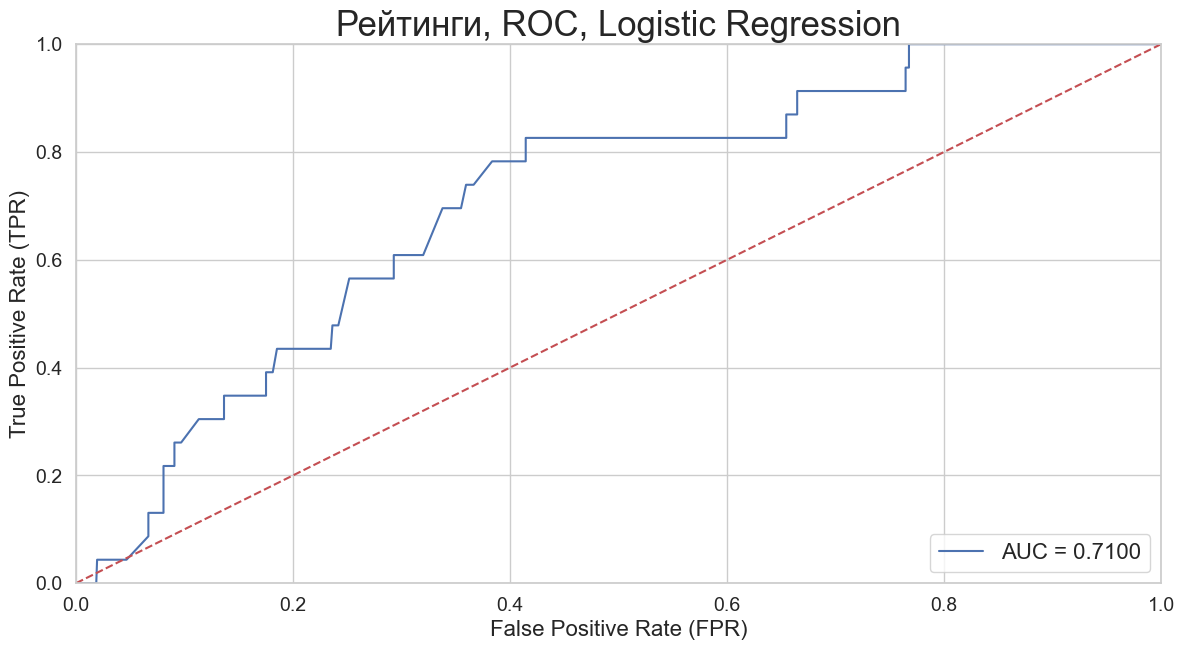

In [12]:
fpr, tpr, threshold = roc_curve(y_val, logistic.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, Logistic Regression', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

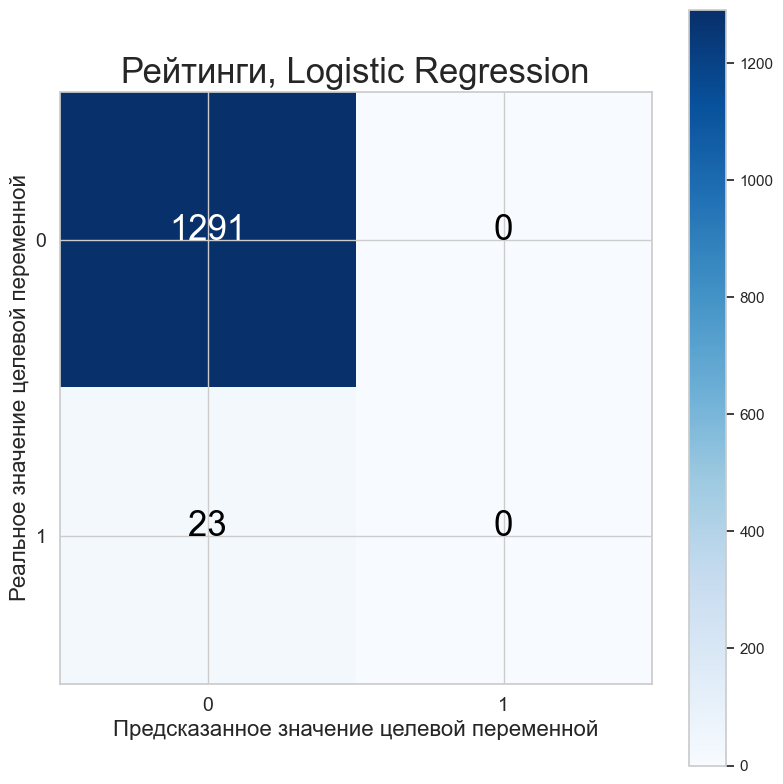

In [13]:
plot_confusion_matrix(confusion_matrix(y_val, logistic.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, Logistic Regression')

### Калибровка вероятностей

In [14]:
oot_proba = logistic.predict_proba(X_oot)[:, 1]
proba_calibration = logistic.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(logistic.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(logistic.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [15]:
exp_cal_er_logistic = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('Logistic Regression (default) = ' + str(exp_cal_er_logistic))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

Logistic Regression (default) = 0.0228248286463367
Изотоническая регрессия = 0.008525413424903669
Логистическая регрессия = 0.027688254188280918


In [16]:
proba_test_logistic_default = oot_proba

### Решающее дерево

In [17]:
DC = DecisionTreeClassifier(max_depth=6)
DC.fit(X_train, y_train)
roc_auc_score(y_val, DC.predict_proba(X_val)[:,1])

0.7909945104906879

In [18]:
print(classification_report(y_val, DC.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1291
           1       0.33      0.04      0.08        23

    accuracy                           0.98      1314
   macro avg       0.66      0.52      0.53      1314
weighted avg       0.97      0.98      0.97      1314



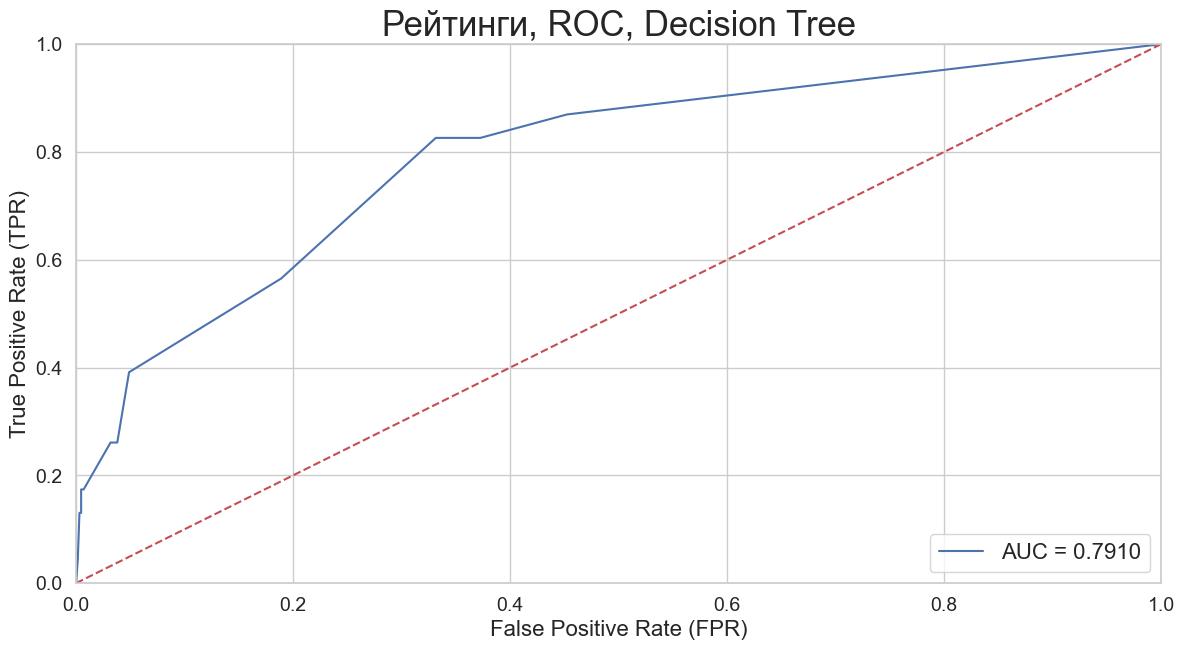

In [19]:
fpr, tpr, threshold = roc_curve(y_val, DC.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, Decision Tree', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

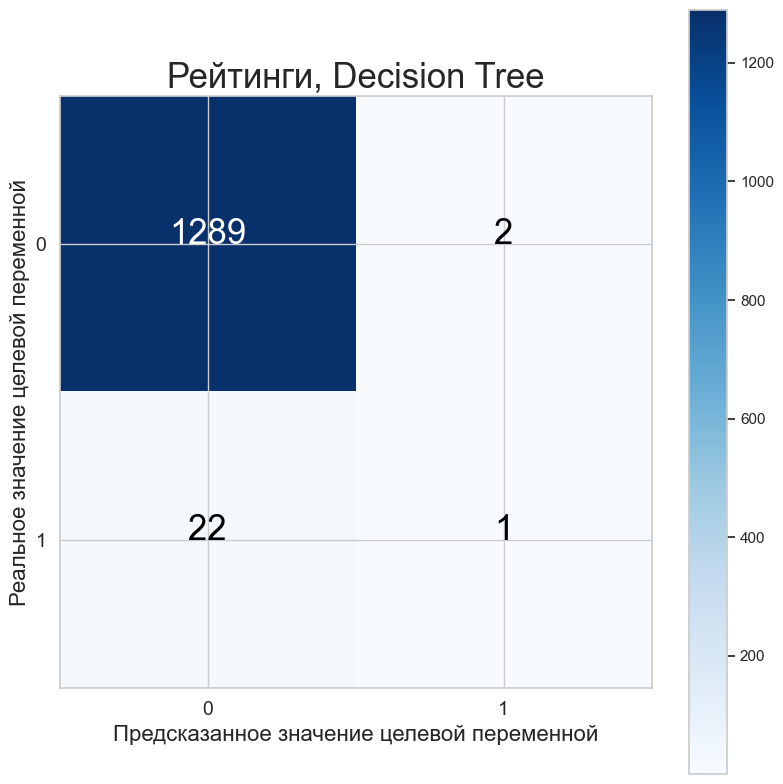

In [20]:
plot_confusion_matrix(confusion_matrix(y_val, DC.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, Decision Tree')

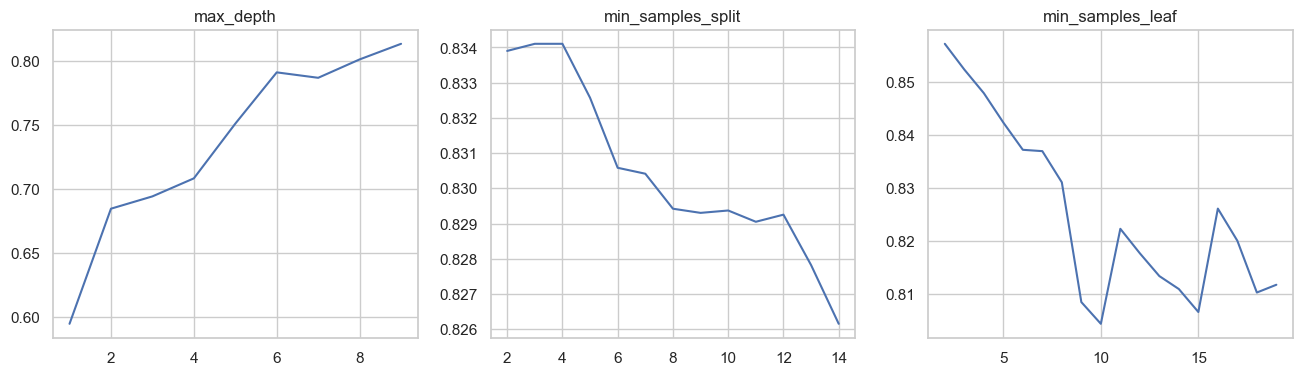

In [21]:
params_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 15),
    'min_samples_leaf': range(2, 20)
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, (param_name, param_grid) in enumerate(params_grid.items()):
    scores = []
    for param in param_grid:
        DC = DecisionTreeClassifier(**{param_name: param})
        DC.fit(X_train, y_train)
        scores.append(roc_auc_score(y_val, DC.predict_proba(X_val)[:,1]))
        

    axes[i].plot(param_grid, scores)
    axes[i].set_title(param_name)

plt.show()

In [22]:
# # Задайте параметры для Grid Search
# param_grid = {
#     'max_depth': range(4, 10),
#     'min_samples_split': range(1, 15),
#     'min_samples_leaf': range(1, 15)
# }

# # Создание экземпляра DecisionTreeClassifier
# DC = DecisionTreeClassifier()

# # Создание объекта GridSearchCV
# grid_search = GridSearchCV(estimator=DC, param_grid=param_grid, scoring='f1', cv=3)
# grid_search.fit(X_train, y_train)

# # Получение лучших параметров
# best_params = grid_search.best_params_

# print(f"Лучшие параметры: {best_params}")

In [23]:
DC = DecisionTreeClassifier(max_depth=9, min_samples_split=2, min_samples_leaf=1 )
DC.fit(X_train, y_train)
proba_valid = DC.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, DC.predict_proba(X_val)[:,1])

0.8133061664365339

In [24]:
print(classification_report(y_val, DC.predict(X_val)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1291
           1       0.67      0.17      0.28        23

    accuracy                           0.98      1314
   macro avg       0.83      0.59      0.63      1314
weighted avg       0.98      0.98      0.98      1314



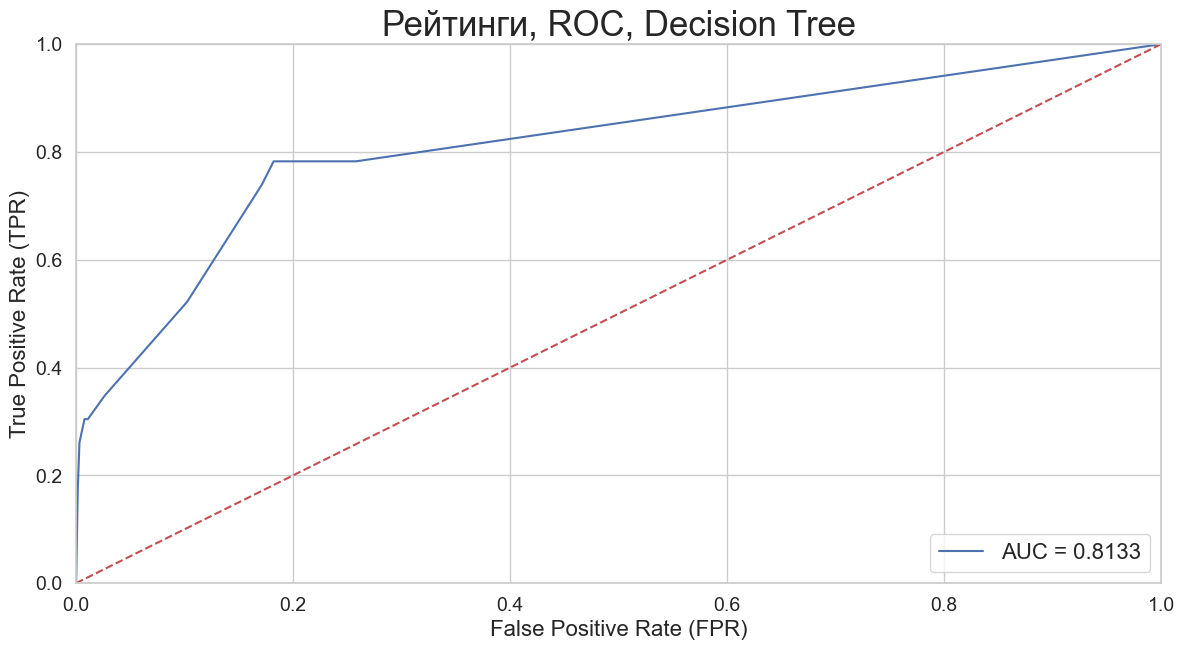

In [25]:
fpr, tpr, threshold = roc_curve(y_val, DC.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, Decision Tree', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

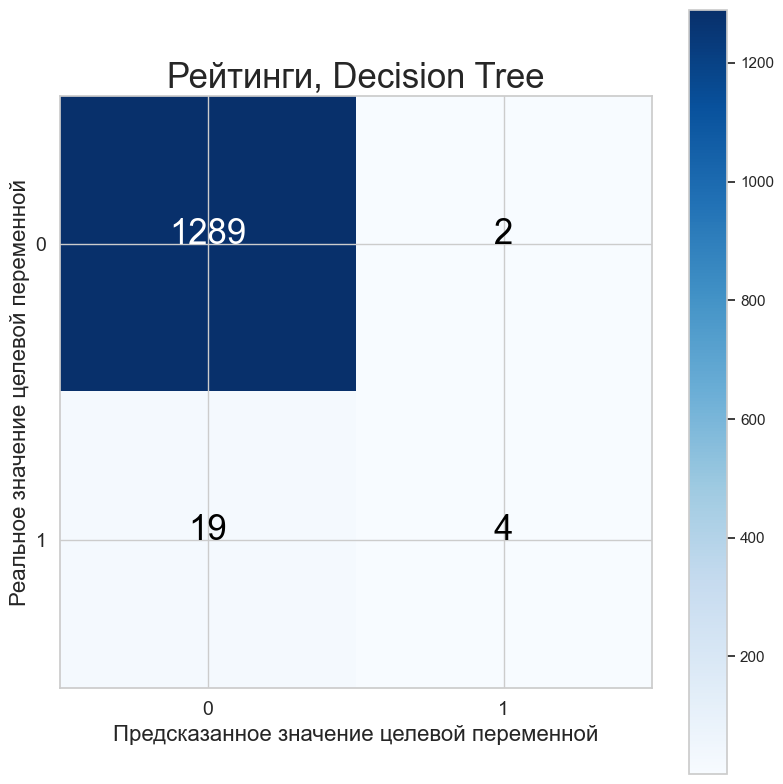

In [26]:
plot_confusion_matrix(confusion_matrix(y_val, DC.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, Decision Tree')

In [27]:
# Получить важность признаков
feature_importances = DC.feature_importances_

# Получить имена столбцов (имена признаков)
column_names = X_train.columns

# Соотнести имена столбцов с их важностью
importance_data = sorted(zip(column_names, feature_importances), key=lambda x: x[1], reverse=True)

# Вывод 5 самых важных признаков
for col_name, importance in importance_data[:5]:
    print(f'Feature: {col_name}, Importance: {importance}')

Feature: rating_exra_rus, Importance: 0.26210512023839194
Feature: rating_exra_rus_shift_1, Importance: 0.08876415885332439
Feature: rating_AKM_rus_diff_3, Importance: 0.05558126802706624
Feature: rating_moody_long_diff_3, Importance: 0.05359187483820562
Feature: rating_exra_rus_shift_3, Importance: 0.04428384484619075


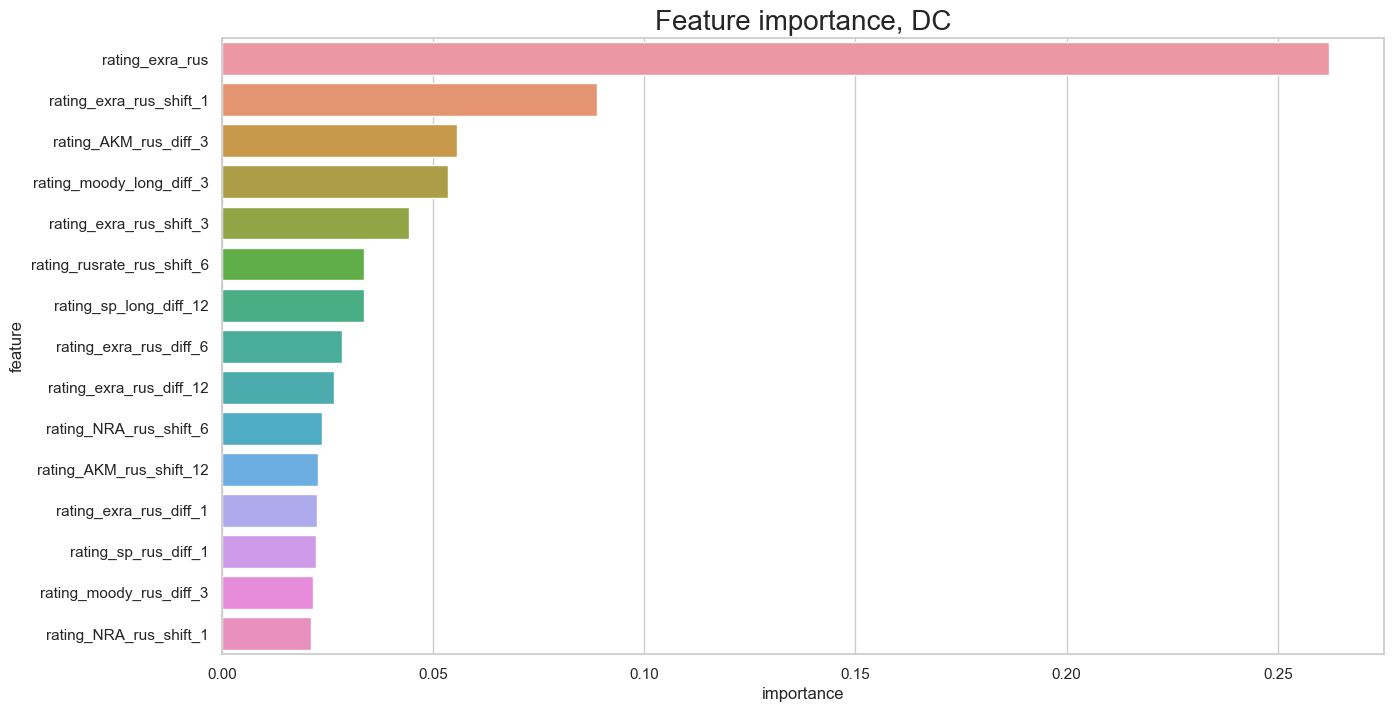

In [28]:
# Создать pandas DataFrame, соотнести имена столбцов с их важностью
df_feature_importances = pd.DataFrame({"feature": column_names, "importance": feature_importances}).sort_values(by="importance", ascending=False)

# Построить график
plt.figure(figsize=(15, 8))
sns.barplot(data=df_feature_importances[:15], x="importance", y="feature")
plt.title("Feature importance, DC", fontsize=20)
plt.show()

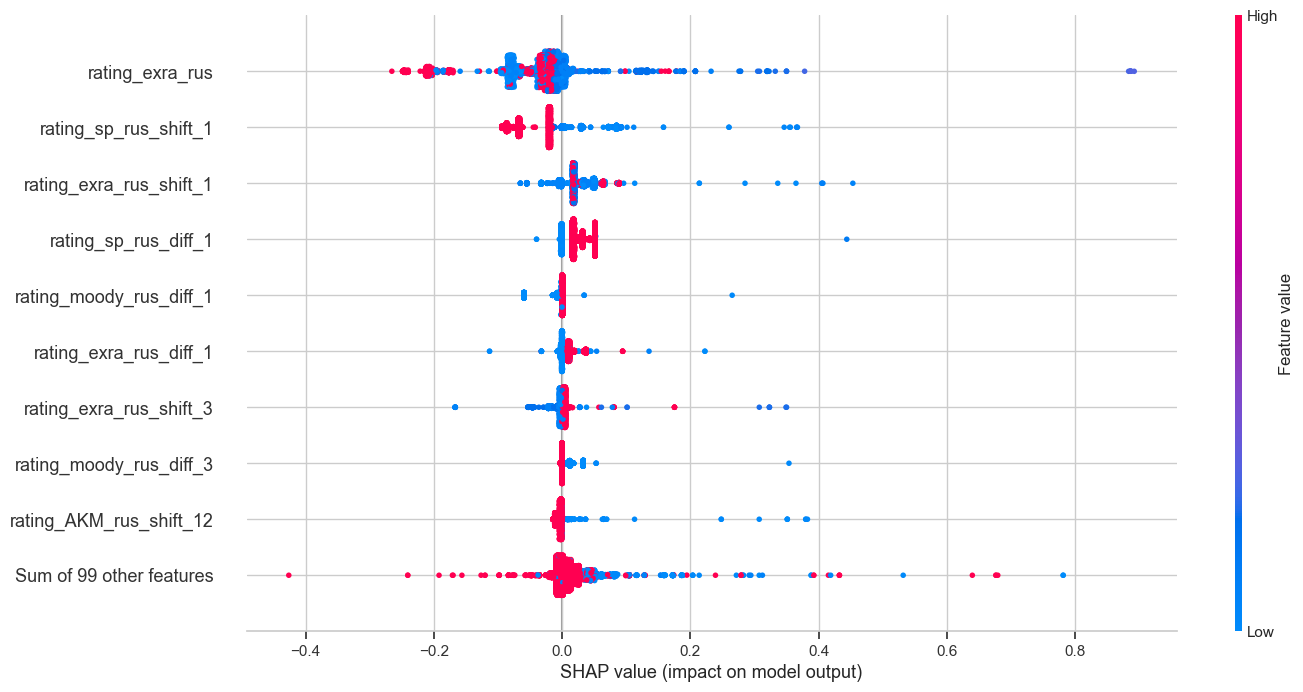

In [29]:
explainer = shap.Explainer(DC)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values=shap_values[:, :, 1], plot_size=(15, 8))

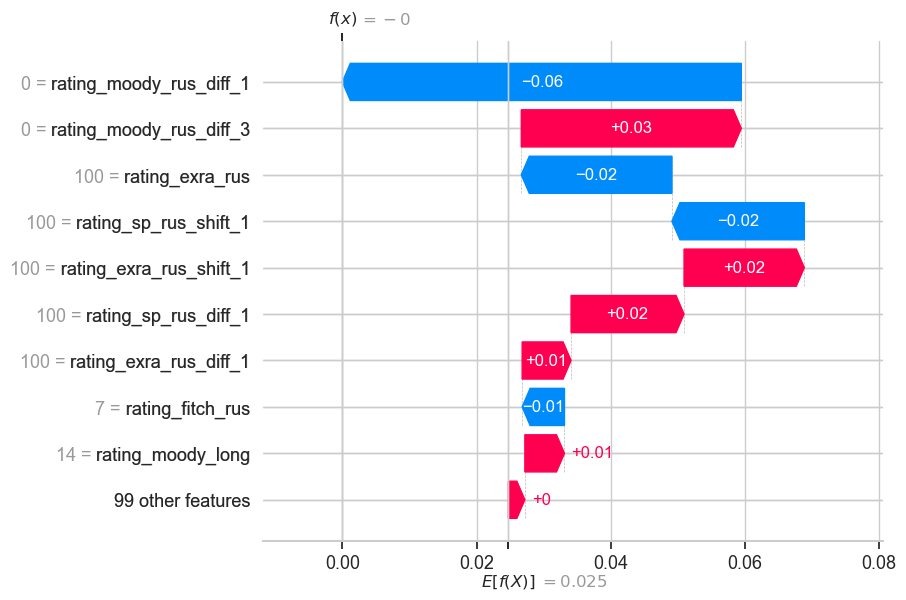

In [30]:
shap.plots.waterfall(shap_values[:, :, 1][2])

### Тест на oot

In [31]:
oot_proba = DC.predict_proba(X_oot)[:, 1]
roc_auc_score(y_oot, DC.predict_proba(X_oot)[:,1])

0.5952745849297573

In [32]:
print(classification_report(y_oot, DC.predict(X_oot)))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1044
           1       0.03      0.13      0.05        15

    accuracy                           0.93      1059
   macro avg       0.51      0.54      0.51      1059
weighted avg       0.97      0.93      0.95      1059



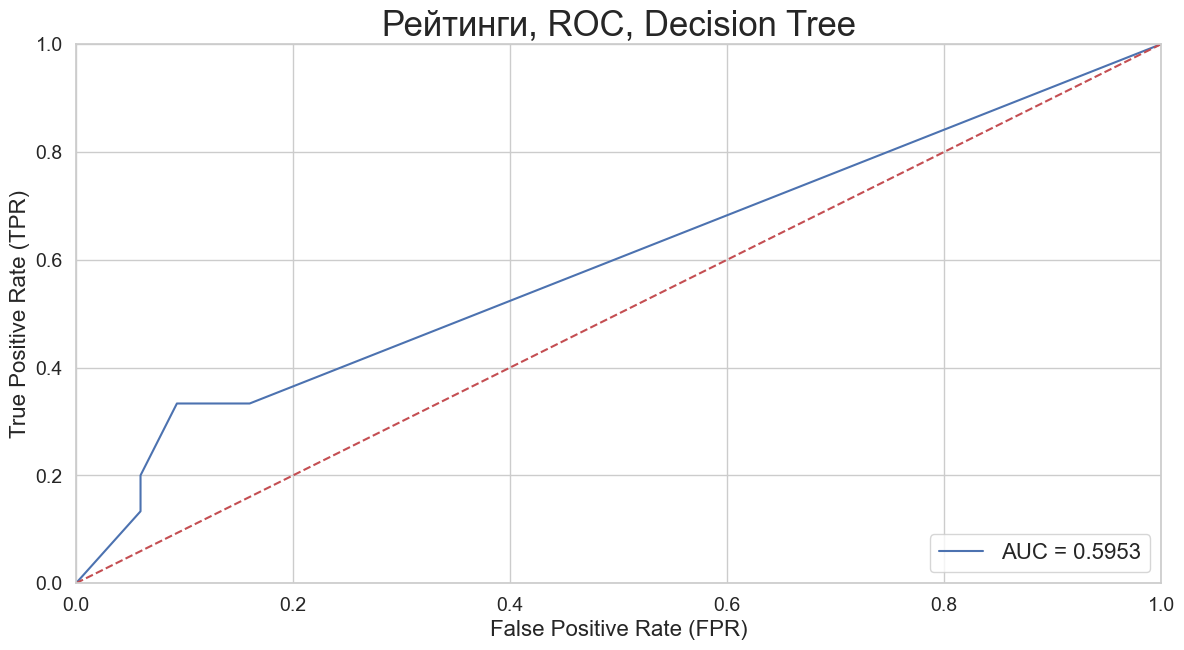

In [33]:
fpr, tpr, threshold = roc_curve(y_oot, DC.predict_proba(X_oot)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, Decision Tree', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

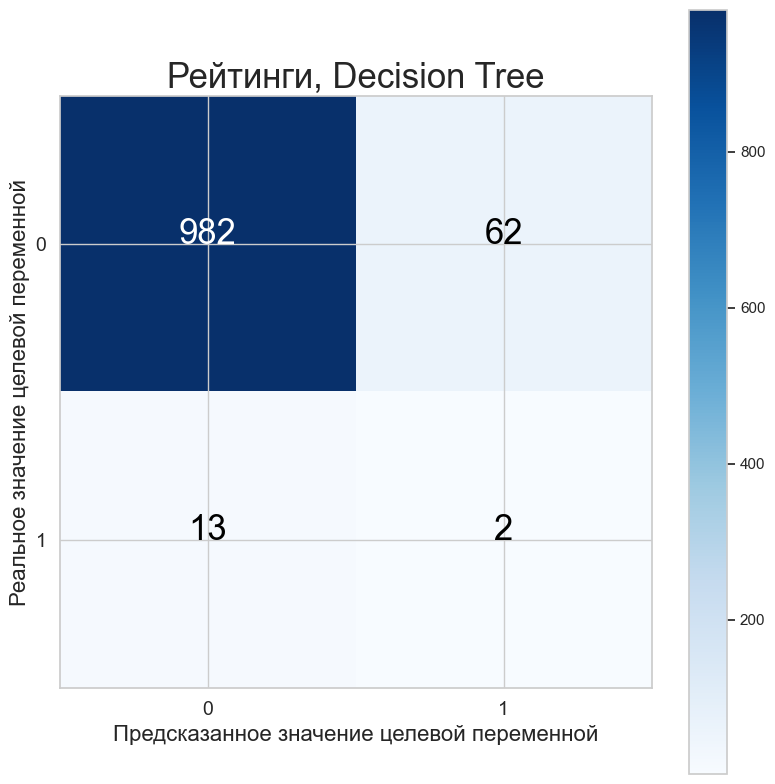

In [34]:
plot_confusion_matrix(confusion_matrix(y_oot, DC.predict(X_oot)), classes=set(y_oot),
                      title='Рейтинги, Decision Tree')

### Калибровка вероятностей

In [35]:
proba_calibration = DC.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(DC.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(DC.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [36]:
exp_cal_er_dc = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('Дерево = ' + str(exp_cal_er_dc))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

Дерево = 0.05017672441438657
Изотоническая регрессия = 0.04167978176476755
Логистическая регрессия = 0.0258124919562656


In [37]:
proba_test_logreg_DC = proba_test_logreg

### SVM

In [38]:
svm = SVC(kernel='rbf', gamma='scale', C=100, probability=True)
svm.fit(X_train, y_train)

svm.score(X_val, y_val)

0.9832572298325722

In [39]:
print(classification_report(y_val, svm.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1291
           1       0.67      0.09      0.15        23

    accuracy                           0.98      1314
   macro avg       0.83      0.54      0.57      1314
weighted avg       0.98      0.98      0.98      1314



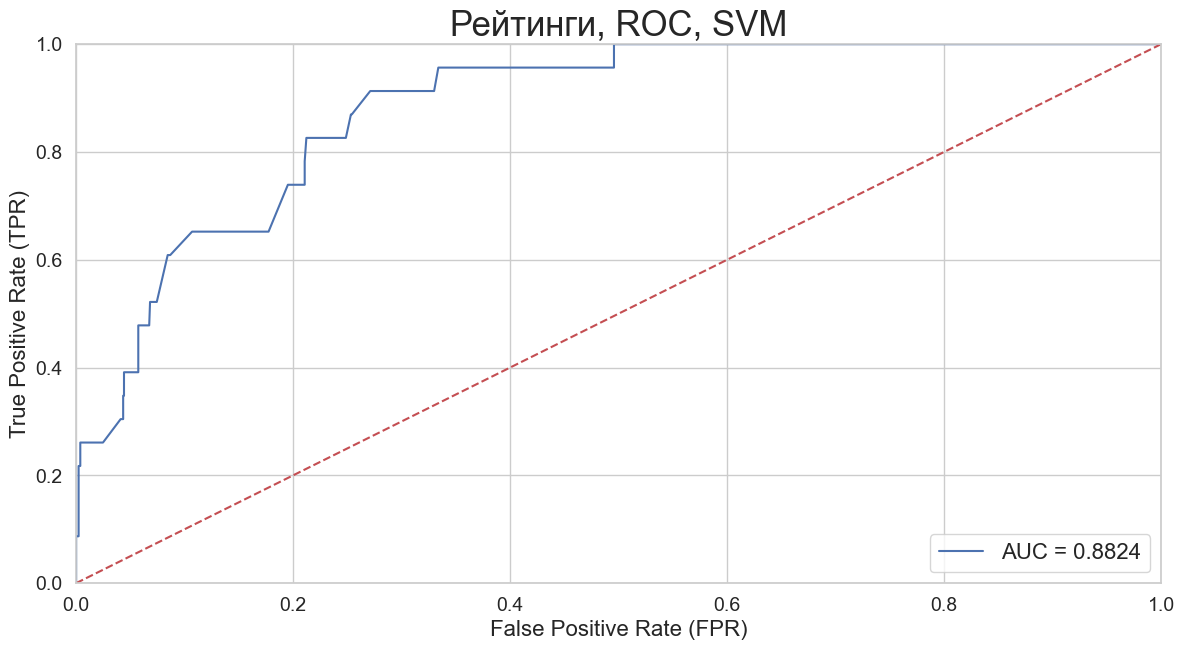

In [40]:
fpr, tpr, threshold = roc_curve(y_val, svm.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, SVM', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

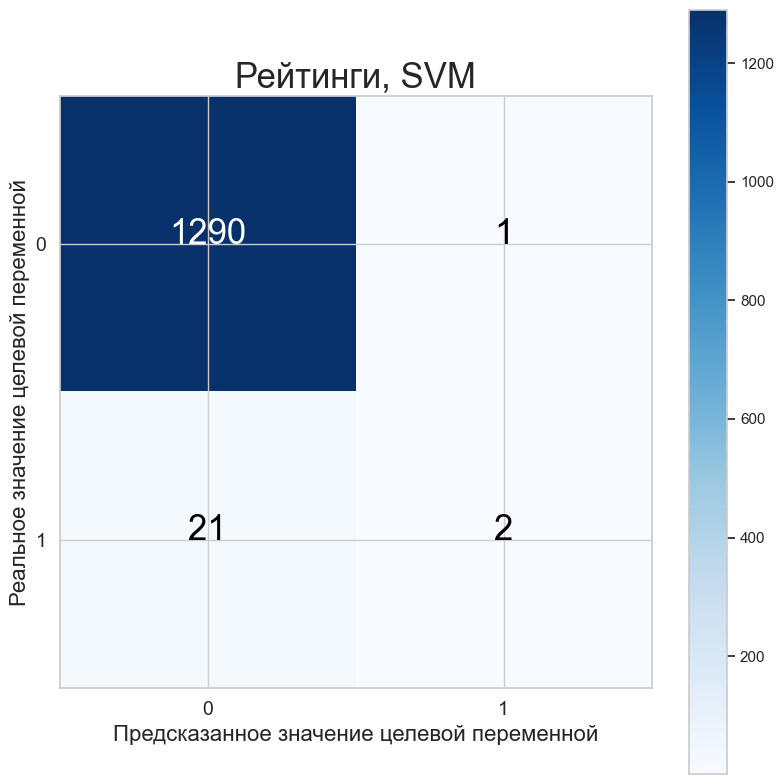

In [41]:
plot_confusion_matrix(confusion_matrix(y_val, svm.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, SVM')

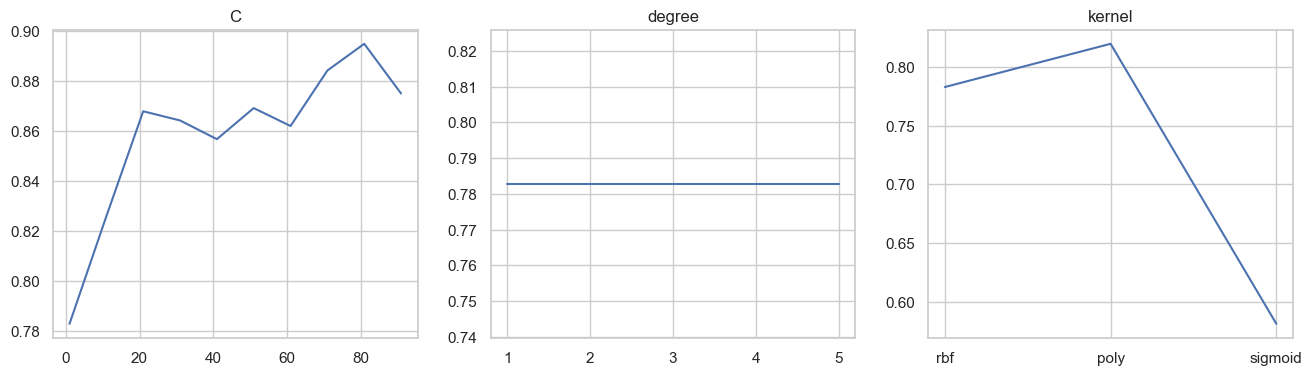

In [42]:
params_grid = {
    'C': range(1, 101, 10),
    'degree': range(1, 6, 1),
    'kernel': ['rbf', 'poly', 'sigmoid'] 
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, (param_name, param_grid) in enumerate(params_grid.items()):
    scores = []
    for param in param_grid:
        svm = SVC(**{param_name: param}, probability=True)
        svm.fit(X_train, y_train)
        scores.append(roc_auc_score(y_val, svm.predict_proba(X_val)[:,1]))
        

    axes[i].plot(param_grid, scores)
    axes[i].set_title(param_name)

plt.show()

In [43]:
param_grid = {
    'C': range(1, 101, 10),
    'degree': range(1, 6, 1),
    'kernel': ['rbf', 'poly', 'sigmoid']  
}

svm = SVC()
best_score = 0

# Перебор всех возможных параметров
for params in tqdm(list(ParameterGrid(param_grid))):
    svm.set_params(**params)
    
    scores = cross_val_score(svm, X_train, y_train, cv=3, scoring='f1')
    
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_params = params

print(f"Лучшие параметры: {best_params}, с соответствующим F1-скором: {best_score}")

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [03:13<00:00,  1.29s/it]

Лучшие параметры: {'C': 91, 'degree': 5, 'kernel': 'poly'}, с соответствующим F1-скором: 0.23740170117156156


In [44]:
svm = SVC(kernel='poly', degree=5, C=91, probability=True)
svm.fit(X_train, y_train)

svm.score(X_val, y_val)

0.982496194824962

In [45]:
print(classification_report(y_val, svm.predict(X_val)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1291
           1       0.50      0.17      0.26        23

    accuracy                           0.98      1314
   macro avg       0.74      0.59      0.62      1314
weighted avg       0.98      0.98      0.98      1314



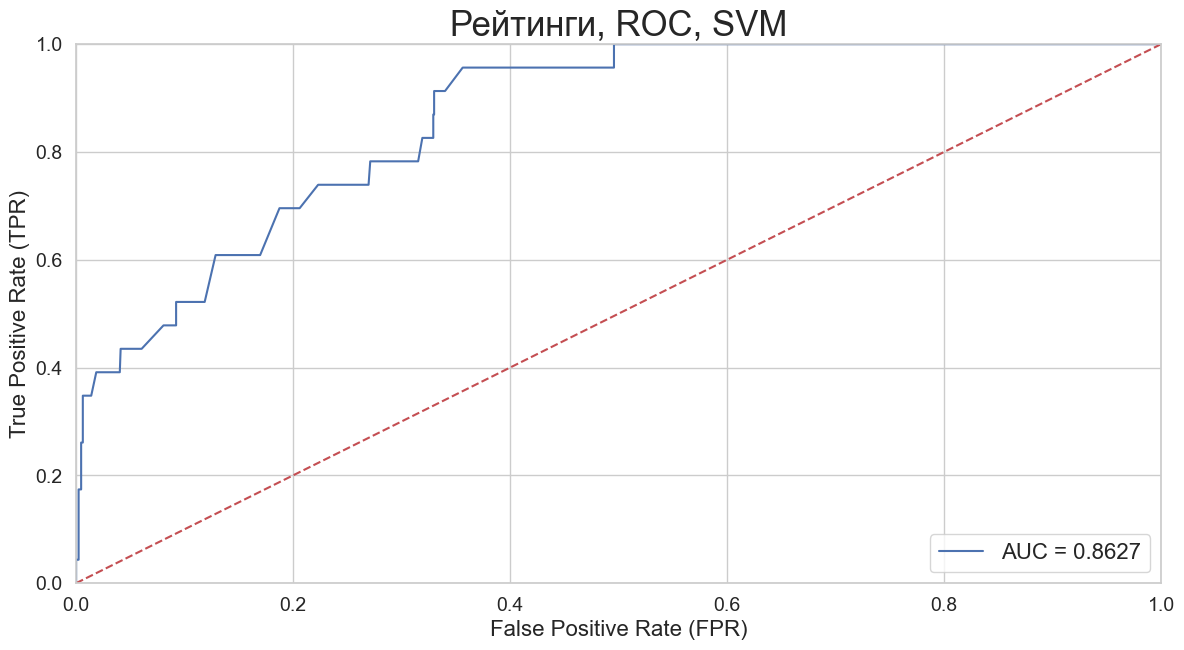

In [46]:
fpr, tpr, threshold = roc_curve(y_val, svm.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, SVM', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

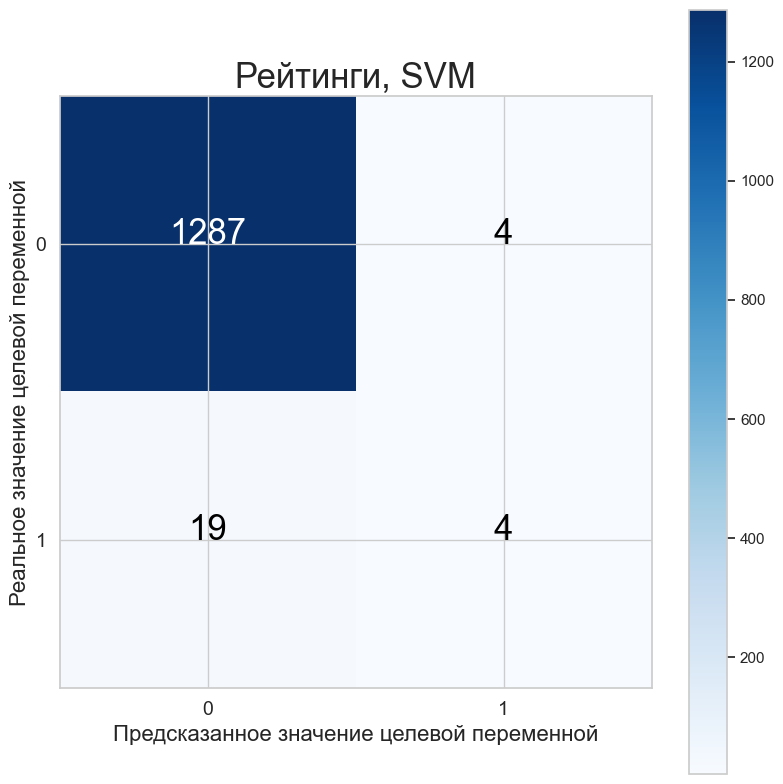

In [47]:
plot_confusion_matrix(confusion_matrix(y_val, svm.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, SVM')

### Тест на oot

In [48]:
print(classification_report(y_oot, svm.predict(X_oot)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1044
           1       1.00      0.13      0.24        15

    accuracy                           0.99      1059
   macro avg       0.99      0.57      0.61      1059
weighted avg       0.99      0.99      0.98      1059



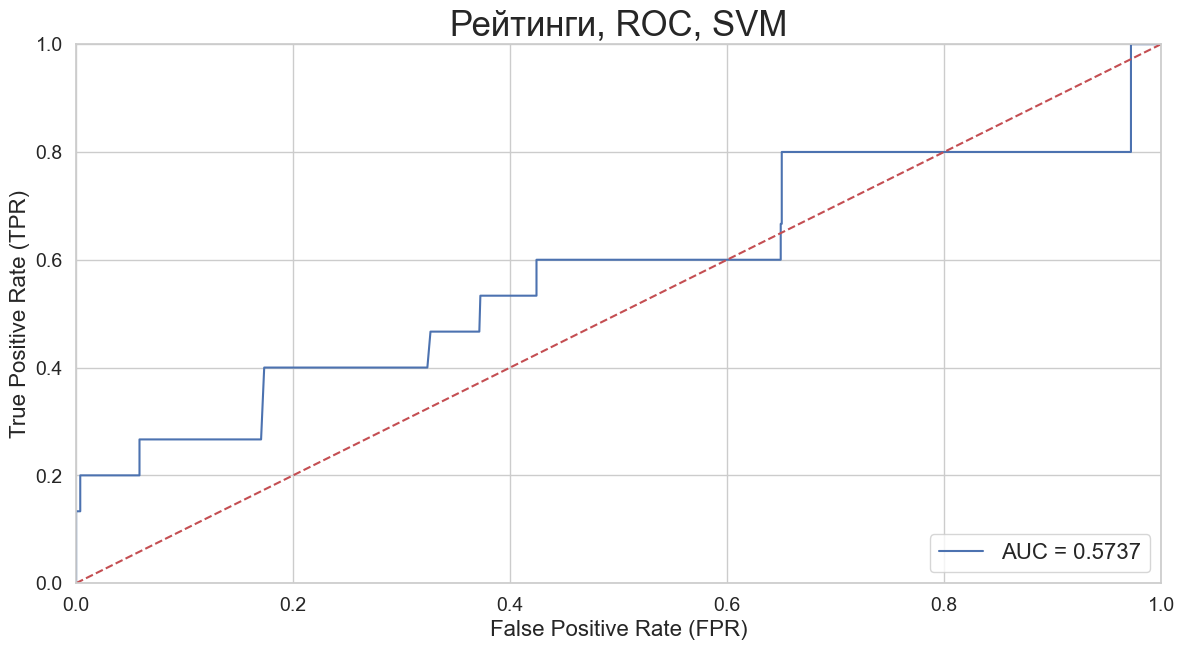

In [49]:
fpr, tpr, threshold = roc_curve(y_oot, svm.predict_proba(X_oot)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, SVM', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

In [50]:
print(classification_report(y_oot, svm.predict(X_oot)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1044
           1       1.00      0.13      0.24        15

    accuracy                           0.99      1059
   macro avg       0.99      0.57      0.61      1059
weighted avg       0.99      0.99      0.98      1059



### Калибровка вероятностей

In [51]:
oot_proba = svm.predict_proba(X_oot)[:, 1]
proba_calibration = svm.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(svm.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(svm.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [52]:
exp_cal_er_svm = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('SVM = ' + str(exp_cal_er_svm))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

SVM = 0.020651868946802567
Изотоническая регрессия = 0.0039055924852690704
Логистическая регрессия = 0.017764015305034637


In [53]:
proba_test_logreg_svm = proba_test_logreg

### Gradient Boosting

In [54]:
params = {
    "n_estimators": 1500,
    "max_depth": 2,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "deviance",
    'subsample': 0.5,
    'verbose': 1,
    'min_samples_leaf': 9,
    'tol': 1e-5, 
    'n_iter_no_change': 100,
    'random_state': 911,
    'loss': 'log_loss'
}

GBC = GradientBoostingClassifier(**params)
GBC.fit(X_train, y_train)

accuracy_score(y_val, GBC.predict(X_val))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2454           0.0004           16.48s
         2           0.2018           0.0004           14.22s
         3           0.2227           0.0004           12.47s
         4           0.2193           0.0004           12.33s
         5           0.2436           0.0004           12.25s
         6           0.2246           0.0004           12.19s
         7           0.1904           0.0010           12.36s
         8           0.2259           0.0003           12.30s
         9           0.2078           0.0002           12.42s
        10           0.2164           0.0003           12.36s
        20           0.2088           0.0010           11.68s
        30           0.2201           0.0001           11.46s
        40           0.2013           0.0002           11.24s
        50           0.1914           0.0001           10.90s
        60           0.2311           0.0005           10.67s
       

0.982496194824962

In [55]:
print(classification_report(y_val, GBC.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1291
           1       0.00      0.00      0.00        23

    accuracy                           0.98      1314
   macro avg       0.49      0.50      0.50      1314
weighted avg       0.97      0.98      0.97      1314



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


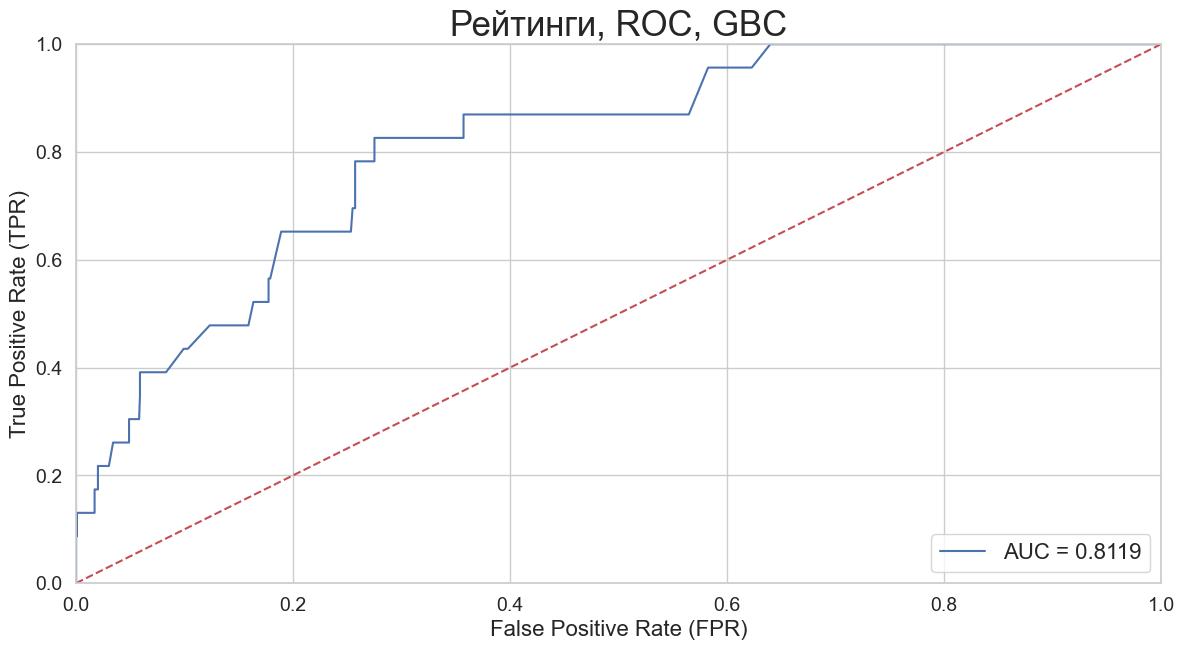

In [56]:
fpr, tpr, threshold = roc_curve(y_val, GBC.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, GBC', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

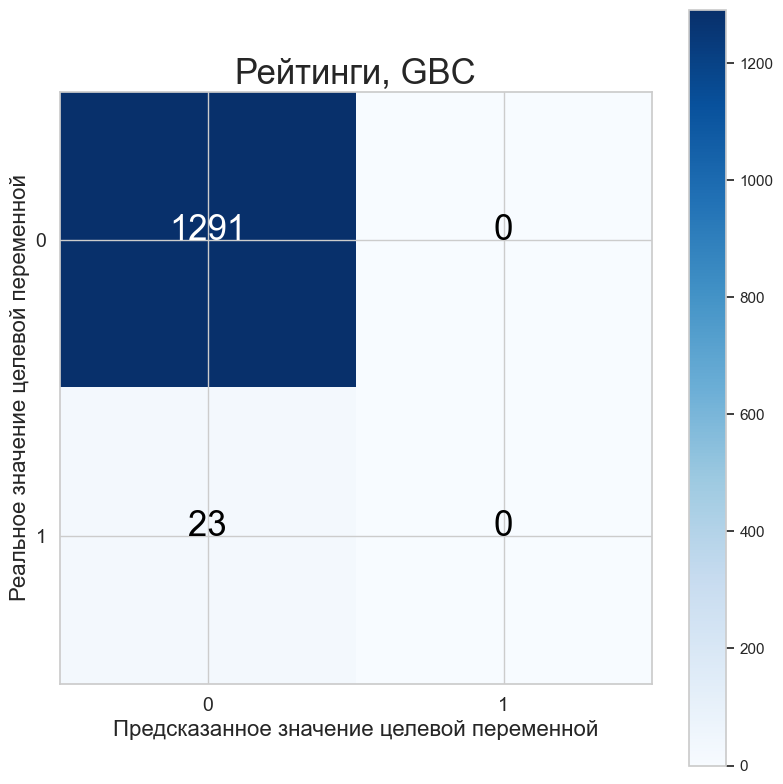

In [57]:
plot_confusion_matrix(confusion_matrix(y_val, GBC.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, GBC')

In [58]:
# Получить важность признаков
feature_importances = GBC.feature_importances_

# Получить имена столбцов (имена признаков)
column_names = X_train.columns

# Соотнести имена столбцов с их важностью
importance_data = sorted(zip(column_names, feature_importances), key=lambda x: x[1], reverse=True)

# Вывод 5 самых важных признаков
for col_name, importance in importance_data[:5]:
    print(f'Feature: {col_name}, Importance: {importance}')

Feature: rating_exra_rus, Importance: 0.2516785665243695
Feature: rating_AKM_rus_shift_12, Importance: 0.09993055879436953
Feature: rating_exra_rus_diff_6, Importance: 0.04473859001537314
Feature: rating_NRA_rus_shift_6, Importance: 0.04457208416868284
Feature: rating_AKM_rus_diff_12, Importance: 0.03387283249733187


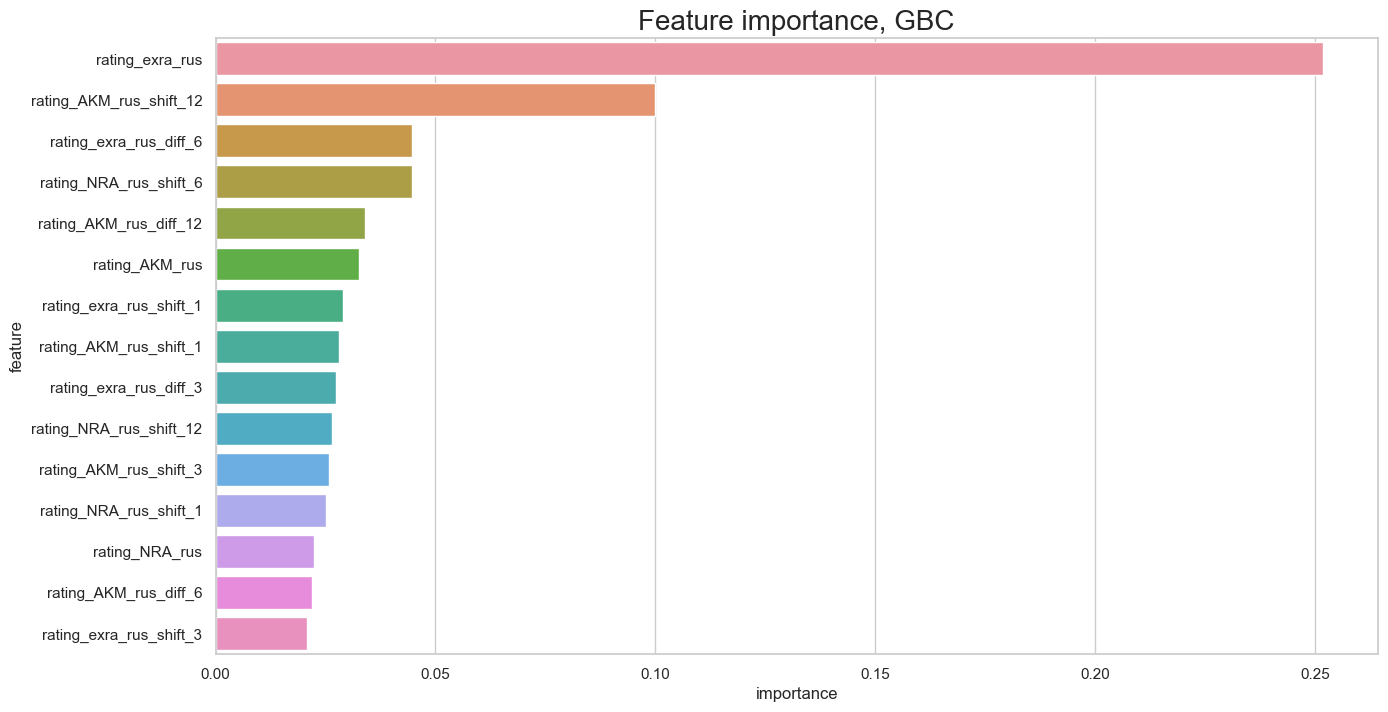

In [59]:
# Создать pandas DataFrame, соотнести имена столбцов с их важностью
df_feature_importances = pd.DataFrame({"feature": column_names, "importance": feature_importances}).sort_values(by="importance", ascending=False)

# Построить график
plt.figure(figsize=(15, 8))
sns.barplot(data=df_feature_importances[:15], x="importance", y="feature")
plt.title("Feature importance, GBC", fontsize=20)
plt.show()

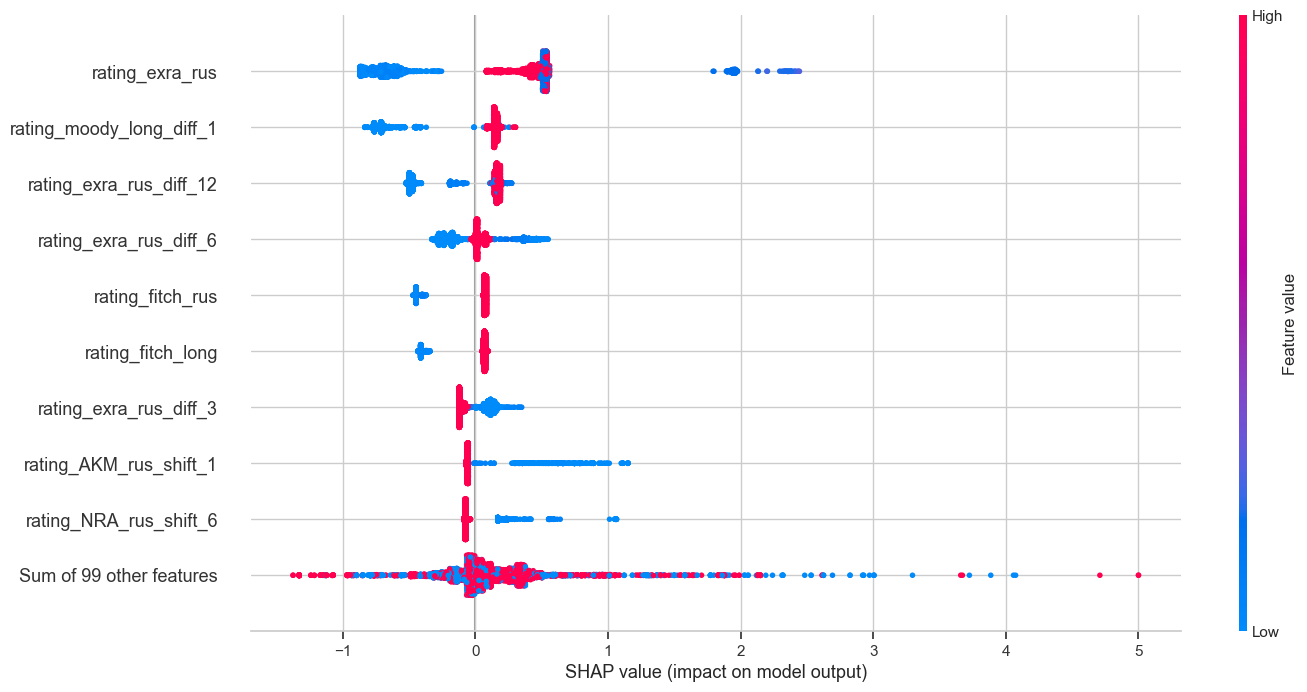

In [60]:
explainer = shap.Explainer(GBC)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values=shap_values, plot_size=(15, 8))

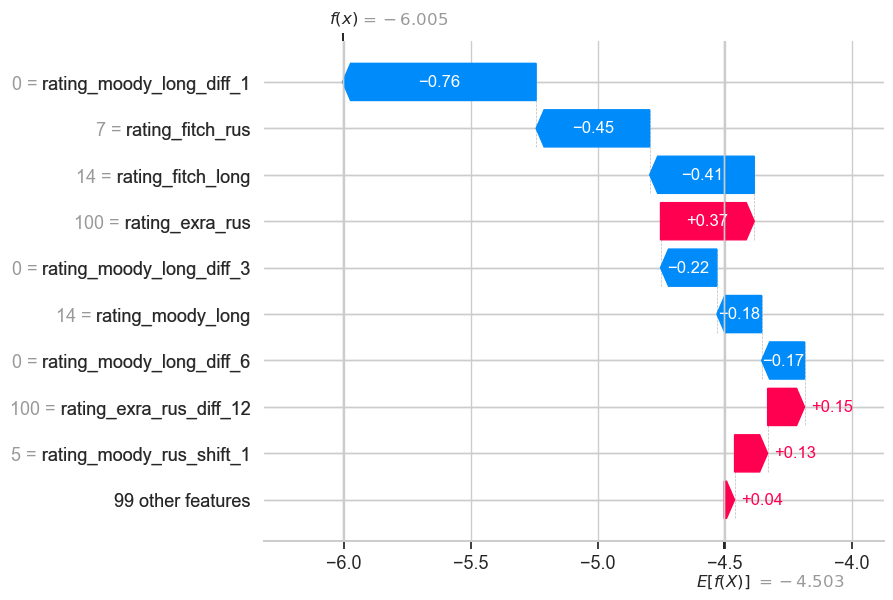

In [61]:
shap.plots.waterfall(shap_values[2])

In [62]:
y_pred = GBC.predict_proba(X_val)

_, n_classes = y_pred.shape

for i in range(n_classes):

    # Computing best threshold for i-th class
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred[:, i], pos_label=i)

    # compute f-1
    f1 = 2 * precision * recall / (precision + recall * 0.1)

    # pick up the best threshold's index
    best_idx = np.argmax(f1)
    print(f'For class {i} the best possible threshold is {thresholds[best_idx]:.3f} wich leads to f1_modified={f1[best_idx]:.3f}')
    
threshold_registration = thresholds[best_idx]

For class 0 the best possible threshold is 0.649 wich leads to f1_modified=1.815
For class 1 the best possible threshold is 0.019 wich leads to f1_modified=0.629


### Калибровка вероятностей

In [63]:
oot_proba = GBC.predict_proba(X_oot)[:, 1]
proba_calibration = GBC.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(GBC.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(GBC.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [64]:
exp_cal_er_GBC = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('GBC = ' + str(exp_cal_er_GBC))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

GBC = 0.029660773818127893
Изотоническая регрессия = 0.011472993506582586
Логистическая регрессия = 0.026812403536723404


In [65]:
proba_test_isotonic_GBC = prb_isotonic_regress

### Random Forest

In [66]:
RFC = RandomForestClassifier(max_depth=2, random_state=911, n_estimators=2000, oob_score=True, bootstrap=True, criterion='entropy', verbose=1, n_jobs=-1)
RFC.fit(X_train, y_train)

accuracy_score(y_val, RFC.predict(X_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Do

0.982496194824962

In [67]:
print(classification_report(y_val, RFC.predict(X_val)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1291
           1       0.00      0.00      0.00        23

    accuracy                           0.98      1314
   macro avg       0.49      0.50      0.50      1314
weighted avg       0.97      0.98      0.97      1314



[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.4s finished
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.5s finished


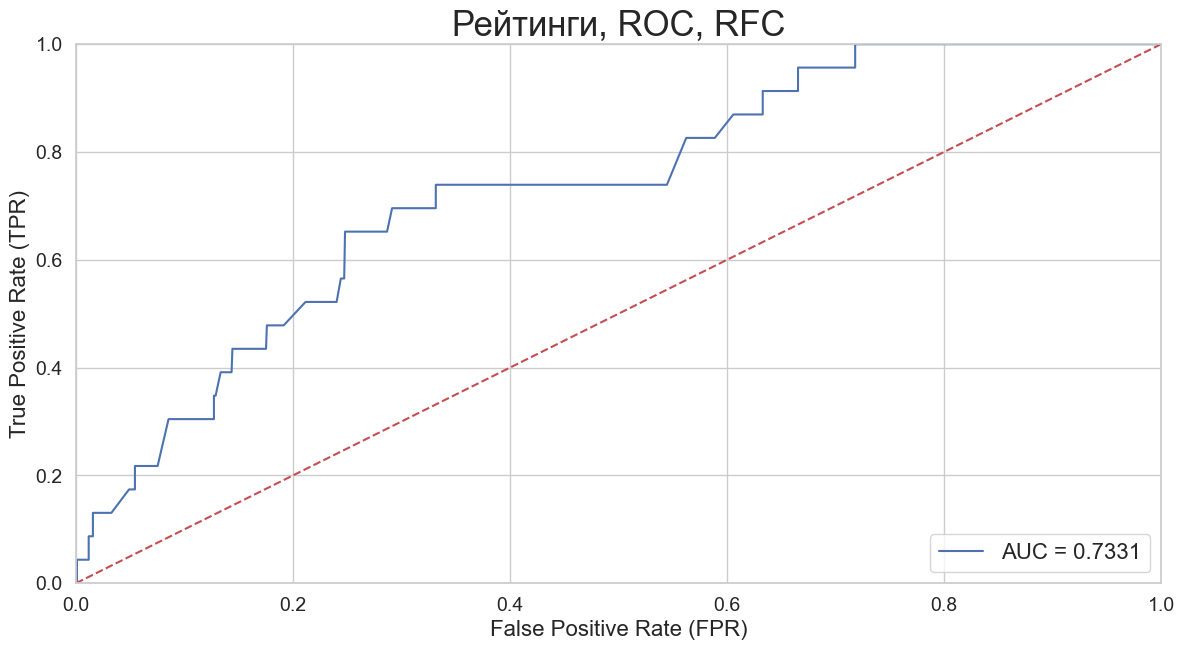

In [68]:
fpr, tpr, threshold = roc_curve(y_val, RFC.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, RFC', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.4s finished


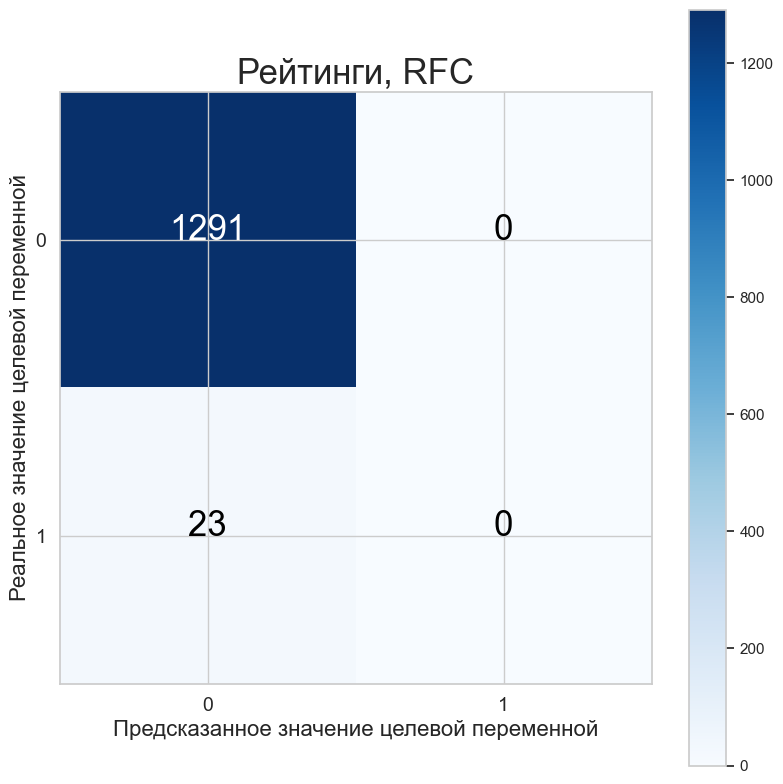

In [69]:
plot_confusion_matrix(confusion_matrix(y_val, RFC.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, RFC')

In [70]:
# Получить важность признаков
feature_importances = RFC.feature_importances_

# Получить имена столбцов (имена признаков)
column_names = X_train.columns

# Соотнести имена столбцов с их важностью
importance_data = sorted(zip(column_names, feature_importances), key=lambda x: x[1], reverse=True)

# Вывод 5 самых важных признаков
for col_name, importance in importance_data[:5]:
    print(f'Feature: {col_name}, Importance: {importance}')

Feature: rating_exra_rus, Importance: 0.1010690366397663
Feature: rating_exra_rus_shift_1, Importance: 0.08366496491943569
Feature: rating_exra_rus_shift_3, Importance: 0.057858402814270626
Feature: rating_fitch_long, Importance: 0.05778748159466114
Feature: rating_fitch_rus, Importance: 0.05386920257634758


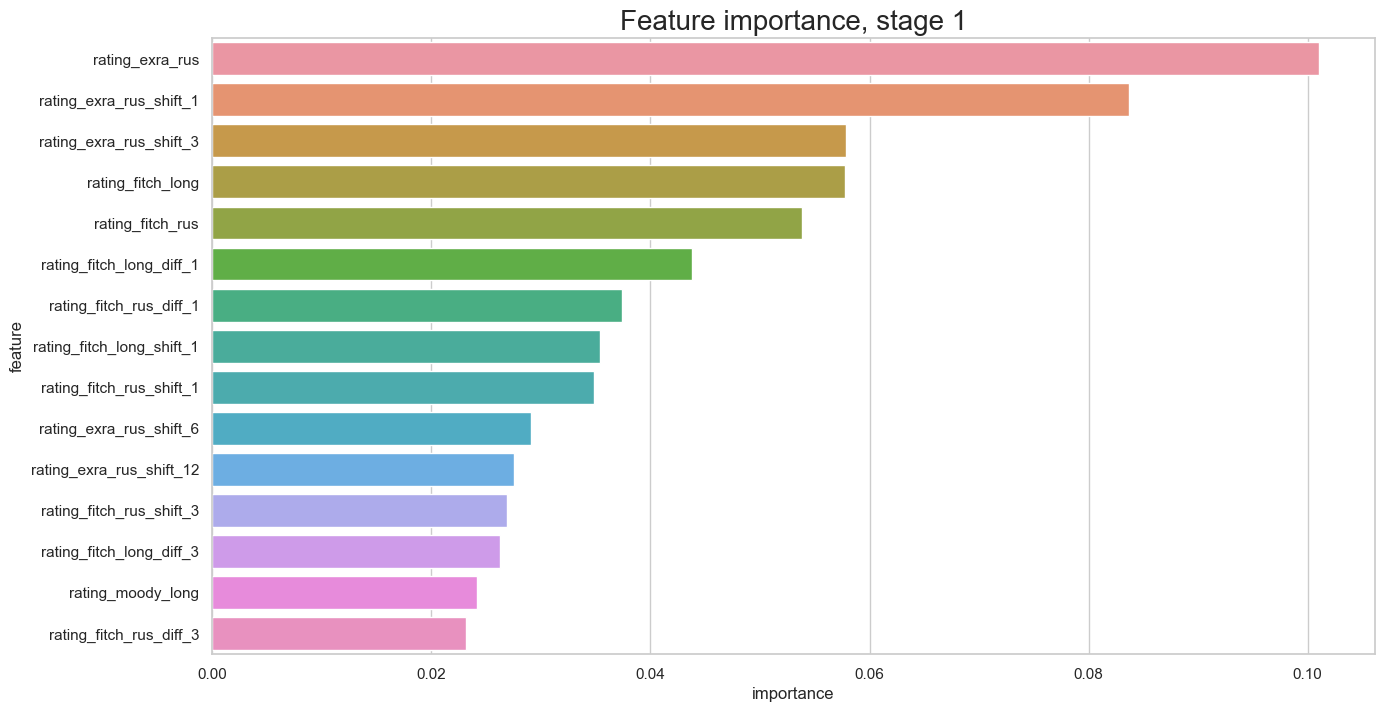

In [71]:
# Создать pandas DataFrame, соотнести имена столбцов с их важностью
df_feature_importances = pd.DataFrame({"feature": column_names, "importance": feature_importances}).sort_values(by="importance", ascending=False)

# Построить график
plt.figure(figsize=(15, 8))
sns.barplot(data=df_feature_importances[:15], x="importance", y="feature")
plt.title("Feature importance, stage 1", fontsize=20)
plt.show()

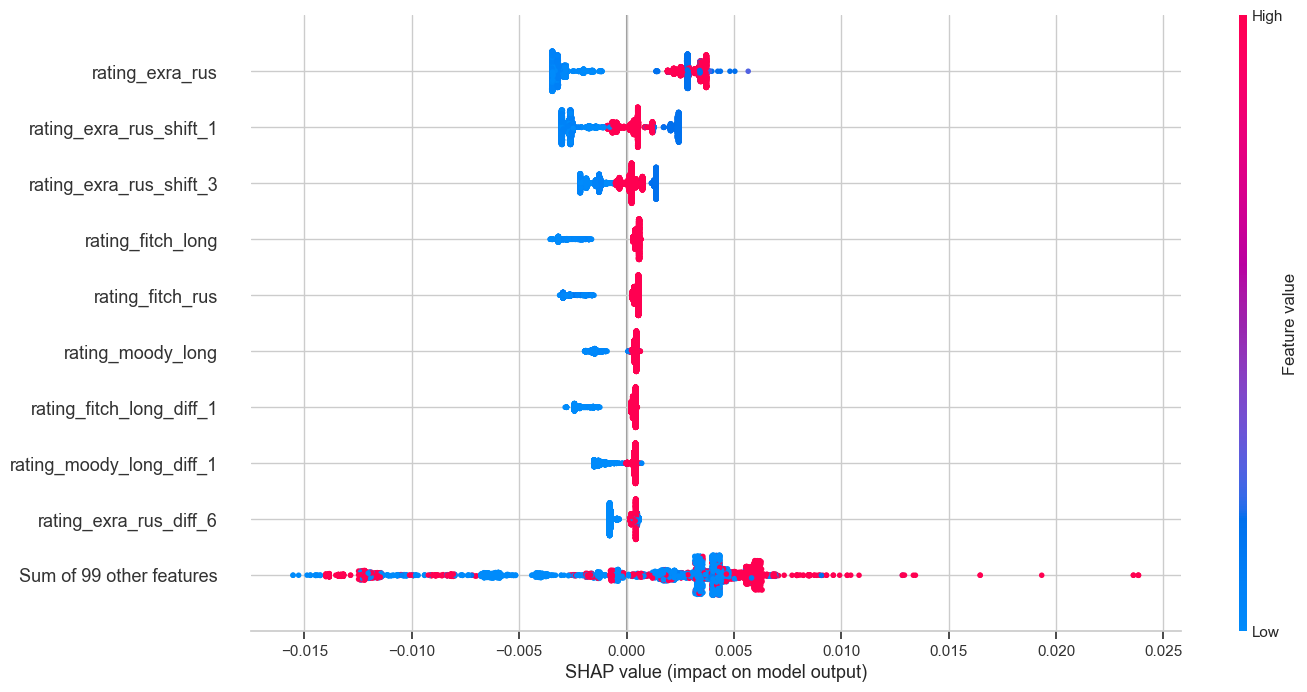

In [72]:
explainer = shap.Explainer(RFC)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values=shap_values[:, :, 1], plot_size=(15, 8))

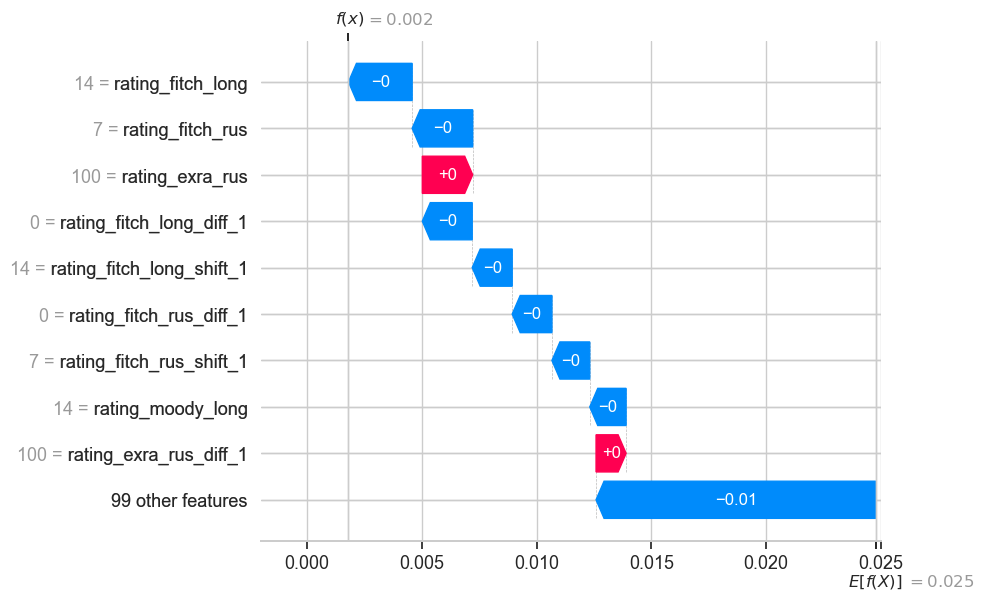

In [73]:
shap.plots.waterfall(shap_values[:, :, 1][2])

### Калибровка вероятностей

In [74]:
oot_proba = RFC.predict_proba(X_oot)[:, 1]
proba_calibration = RFC.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(RFC.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(RFC.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 

In [75]:
exp_cal_er_RFC = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('RFC = ' + str(exp_cal_er_RFC))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

RFC = 0.010489671015099207
Изотоническая регрессия = 0.014122291381678887
Логистическая регрессия = 0.0182121774191579


In [76]:
proba_test_isotonic_RFC = prb_isotonic_regress

## Результаты

In [77]:
def calculate_metrics(y_true, y_proba):
    roc_auc = roc_auc_score(y_true, y_proba)
    
    # Коэффициент Джини можно вычислить как 2 * ROC AUC - 1
    gini = 2 * roc_auc - 1
             
    return roc_auc, gini

In [78]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_logistic_default)
print(f"ROC AUC, Logistic Regression: {roc_auc}")
print(f"Gini, Logistic Regression: {gini}")

ROC AUC, Logistic Regression: 0.8
Gini, Logistic Regression: 0.6000000000000001


In [79]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_logreg_DC)
print(f"ROC AUC, Decision Tree: {roc_auc}")
print(f"Gini, Decision Tree: {gini}")

ROC AUC, Decision Tree: 0.5952745849297573
Gini, Decision Tree: 0.19054916985951453


In [80]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_logreg_svm)
print(f"ROC AUC, SVM: {roc_auc}")
print(f"Gini, SVM: {gini}")

ROC AUC, SVM: 0.5736909323116219
Gini, SVM: 0.14738186462324387


In [81]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_isotonic_GBC)
print(f"ROC AUC, GBC: {roc_auc}")
print(f"Gini, GBC: {gini}")

ROC AUC, GBC: 0.8141762452107281
Gini, GBC: 0.6283524904214561


In [82]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_isotonic_RFC)
print(f"ROC AUC, RFC: {roc_auc}")
print(f"Gini, RFC: {gini}")

ROC AUC, RFC: 0.7068326947637292
Gini, RFC: 0.41366538952745846


#### Лучшая модель без upsampling - градиентный бустинг.

In [83]:
with open("GBC_rating_model.pkl", "wb") as f:
    pickle.dump(GBC, f)

## Пробуем Upsampling

In [84]:
ros = RandomOverSampler()

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# GradientBoosting

In [85]:
params = {
    "n_estimators": 1500,
    "max_depth": 2,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "deviance",
    'subsample': 0.5,
    'verbose': 1,
    'min_samples_leaf': 9,
    'tol': 1e-5, 
    'n_iter_no_change': 100,
    'random_state': 911,
    'loss': 'log_loss'
}

GBC2 = GradientBoostingClassifier(**params)
GBC2.fit(X_train_resampled, y_train_resampled)

accuracy_score(y_val, GBC2.predict(X_val))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3814           0.0051           25.47s
         2           1.3768           0.0051           25.45s
         3           1.3716           0.0050           25.43s
         4           1.3662           0.0048           24.67s
         5           1.3615           0.0048           24.20s
         6           1.3577           0.0048           24.39s
         7           1.3519           0.0045           24.51s
         8           1.3491           0.0045           24.42s
         9           1.3443           0.0044           24.17s
        10           1.3402           0.0041           23.97s
        20           1.2992           0.0036           22.04s
        30           1.2657           0.0031           21.30s
        40           1.2358           0.0025           20.85s
        50           1.2098           0.0023           20.45s
        60           1.1878           0.0021           20.40s
       

0.7960426179604262

In [86]:
print(classification_report(y_val, GBC2.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      0.80      0.88      1291
           1       0.06      0.78      0.12        23

    accuracy                           0.80      1314
   macro avg       0.53      0.79      0.50      1314
weighted avg       0.98      0.80      0.87      1314



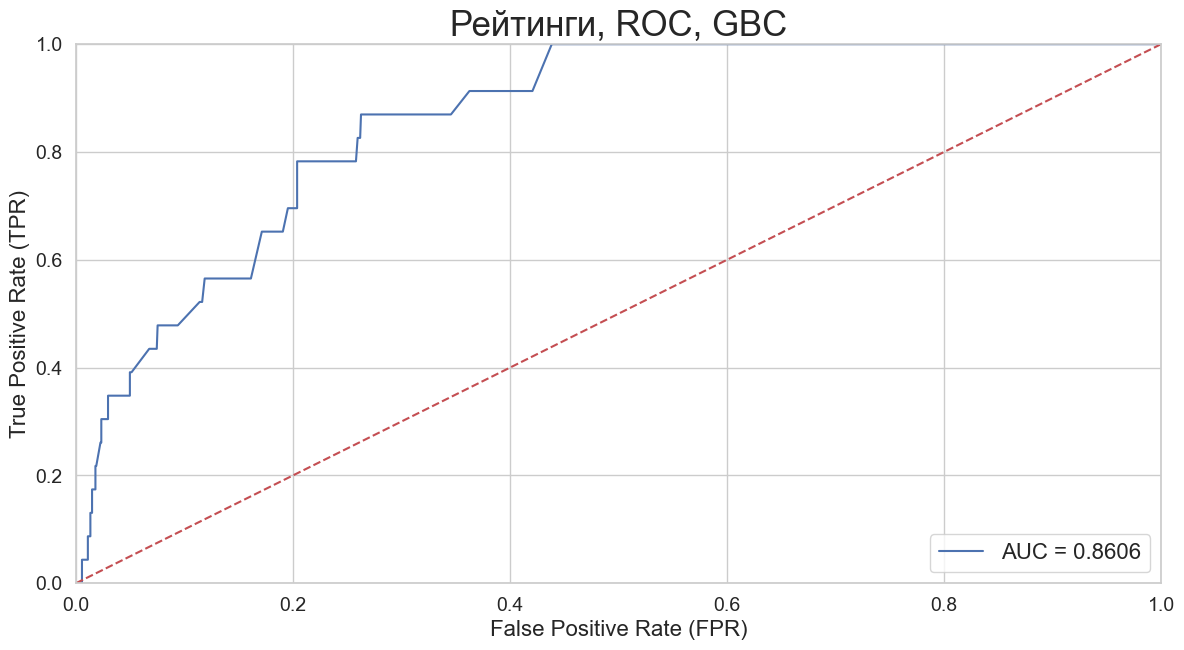

In [87]:
fpr, tpr, threshold = roc_curve(y_val, GBC2.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, GBC', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

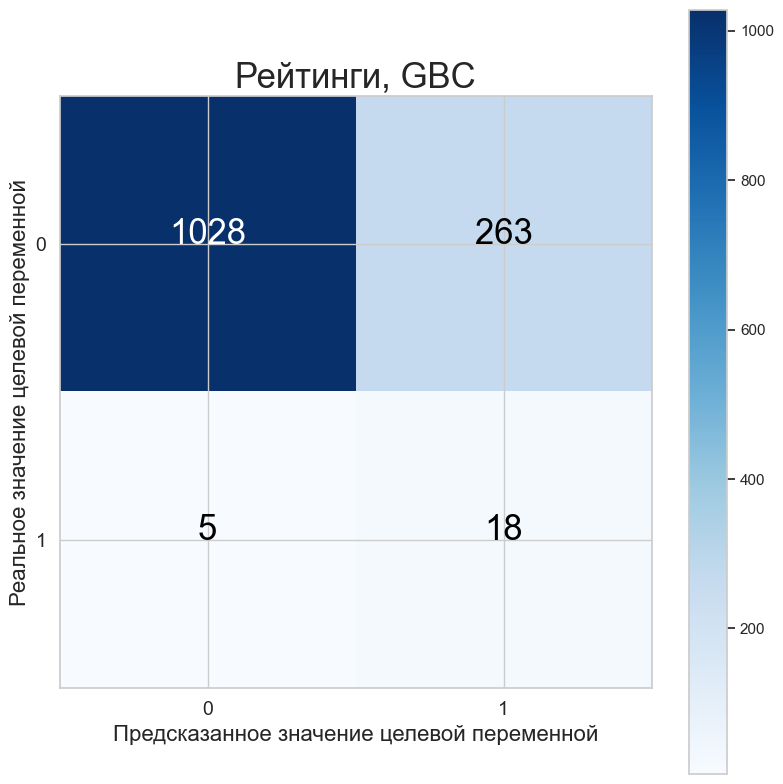

In [88]:
plot_confusion_matrix(confusion_matrix(y_val, GBC2.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, GBC')

In [89]:
# Получить важность признаков
feature_importances = GBC2.feature_importances_

# Получить имена столбцов (имена признаков)
column_names = X_train_resampled.columns

# Соотнести имена столбцов с их важностью
importance_data = sorted(zip(column_names, feature_importances), key=lambda x: x[1], reverse=True)

# Вывод 5 самых важных признаков
for col_name, importance in importance_data[:5]:
    print(f'Feature: {col_name}, Importance: {importance}')

Feature: rating_exra_rus, Importance: 0.2997958780217304
Feature: rating_fitch_rus, Importance: 0.06764861879673811
Feature: rating_fitch_long, Importance: 0.06704218606522878
Feature: rating_moody_long, Importance: 0.06551663667375475
Feature: rating_sp_rus_shift_1, Importance: 0.06081956210911631


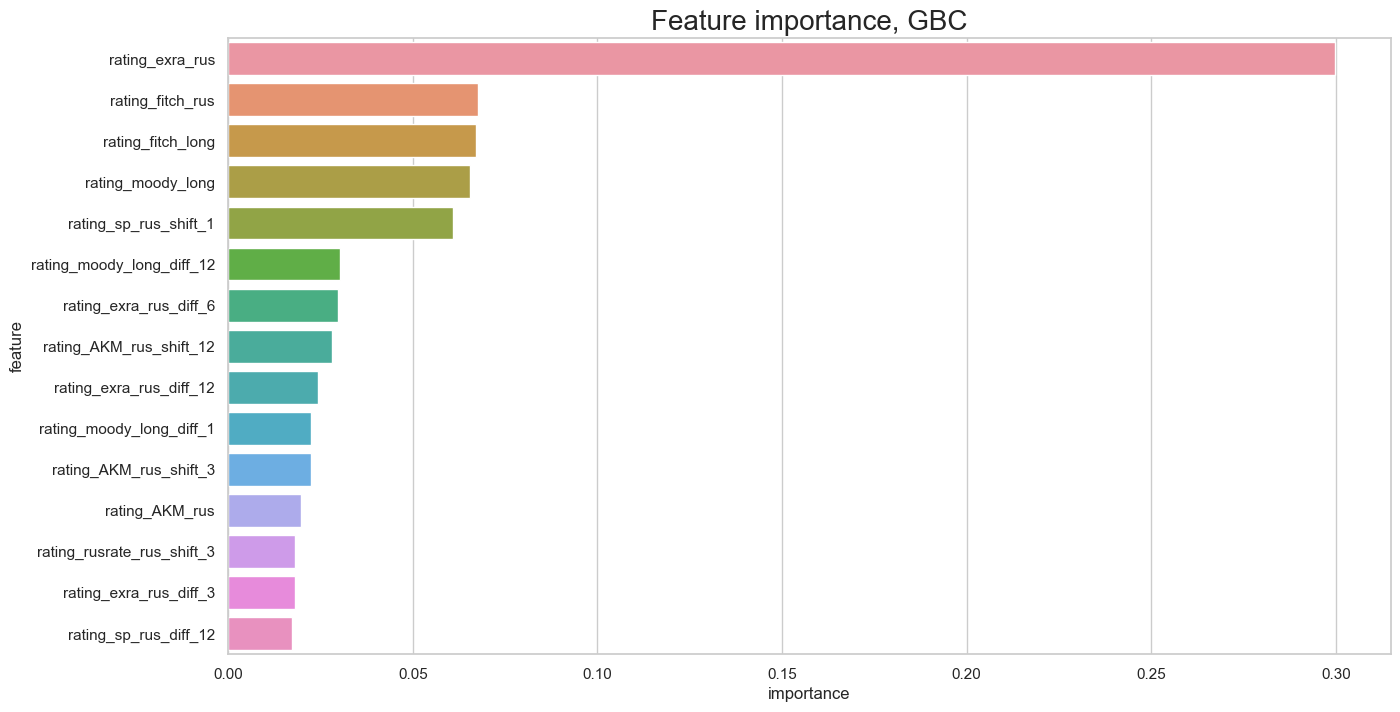

In [90]:
# Создать pandas DataFrame, соотнести имена столбцов с их важностью
df_feature_importances = pd.DataFrame({"feature": column_names, "importance": feature_importances}).sort_values(by="importance", ascending=False)

# Построить график
plt.figure(figsize=(15, 8))
sns.barplot(data=df_feature_importances[:15], x="importance", y="feature")
plt.title("Feature importance, GBC", fontsize=20)
plt.show()

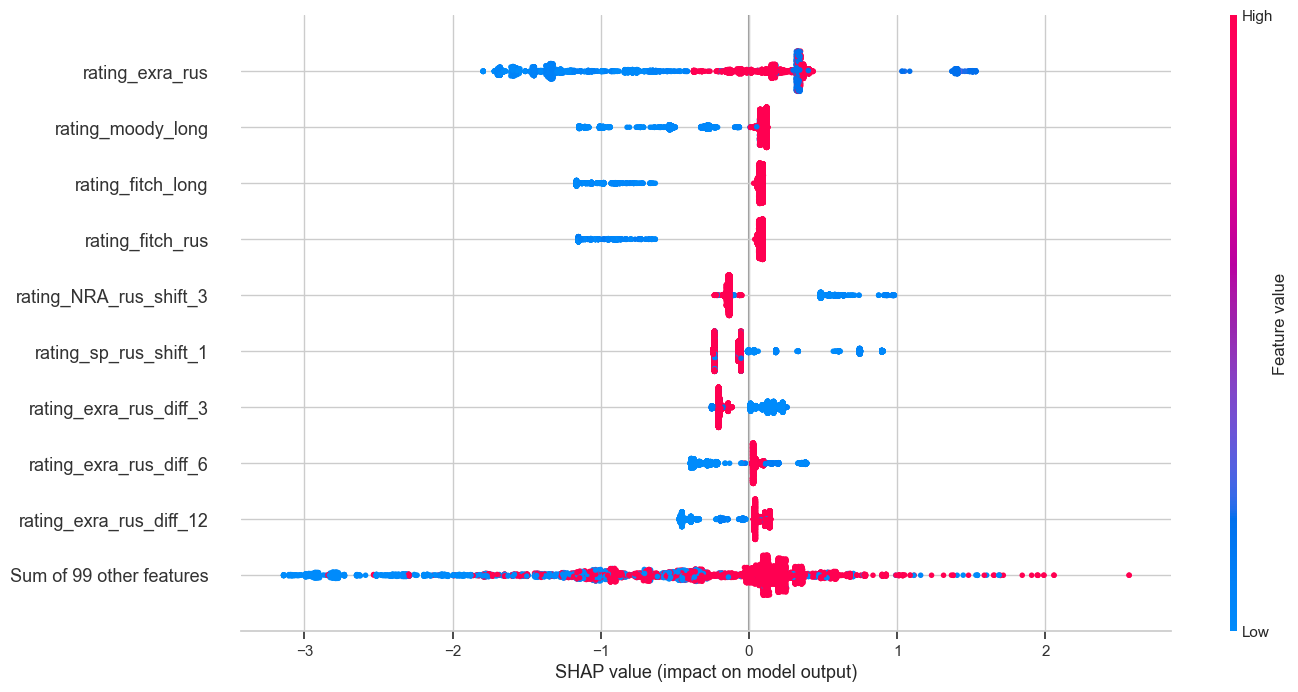

In [91]:
explainer = shap.Explainer(GBC2)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values=shap_values, plot_size=(15, 8))

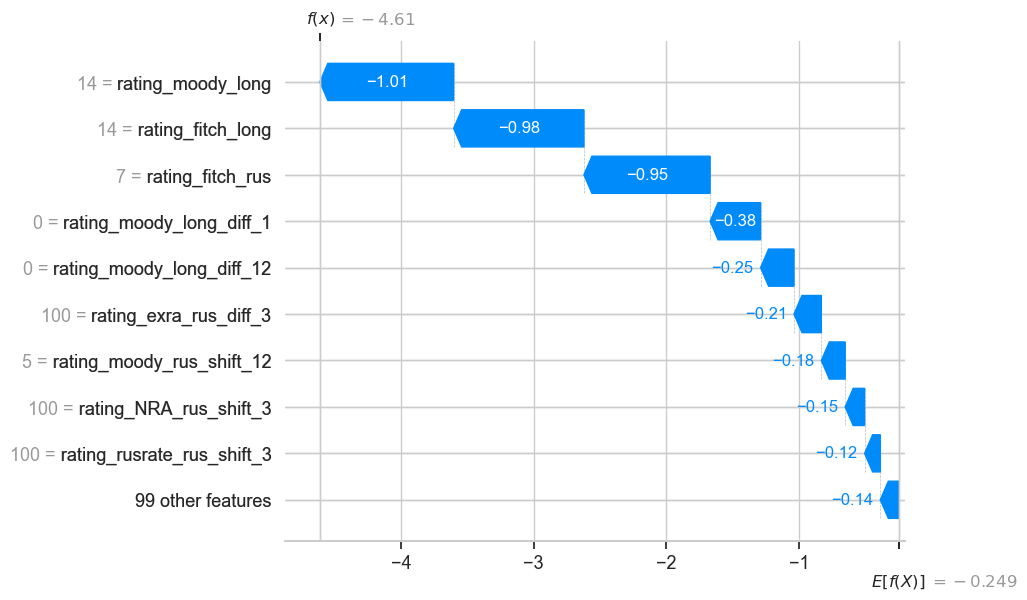

In [92]:
shap.plots.waterfall(shap_values[2])

In [93]:
y_pred = GBC2.predict_proba(X_val)

_, n_classes = y_pred.shape

for i in range(n_classes):

    # Computing best threshold for i-th class
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred[:, i], pos_label=i)

    # compute f-1
    f1 = 2 * precision * recall / (precision + recall * 0.1)

    # pick up the best threshold's index
    best_idx = np.argmax(f1)
    print(f'For class {i} the best possible threshold is {thresholds[best_idx]:.3f} wich leads to f1_modified={f1[best_idx]:.3f}')
    
threshold_registration = thresholds[best_idx]

For class 0 the best possible threshold is 0.052 wich leads to f1_modified=1.815
For class 1 the best possible threshold is 0.899 wich leads to f1_modified=nan


invalid value encountered in divide


In [94]:
oot_proba = GBC2.predict_proba(X_oot)[:, 1]
proba_calibration = GBC2.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(GBC2.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(GBC2.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [95]:
exp_cal_er_GBC = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('GBC = ' + str(exp_cal_er_GBC))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

GBC = 0.19193548869810295
Изотоническая регрессия = 0.005989762040322935
Логистическая регрессия = 0.025023703392401314


In [96]:
proba_test_isotonic_GBC = prb_isotonic_regress

# RandomForest

In [97]:
RFC2 = RandomForestClassifier(max_depth=2, random_state=911, n_estimators=2000, oob_score=True, bootstrap=True, criterion='entropy', verbose=1, n_jobs=-1)
RFC2.fit(X_train_resampled, y_train_resampled)

accuracy_score(y_val, RFC2.predict(X_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Do

0.5799086757990868

In [98]:
print(classification_report(y_val, RFC2.predict(X_val)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s


              precision    recall  f1-score   support

           0       0.99      0.58      0.73      1291
           1       0.03      0.74      0.06        23

    accuracy                           0.58      1314
   macro avg       0.51      0.66      0.39      1314
weighted avg       0.98      0.58      0.72      1314



[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.4s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.4s finished


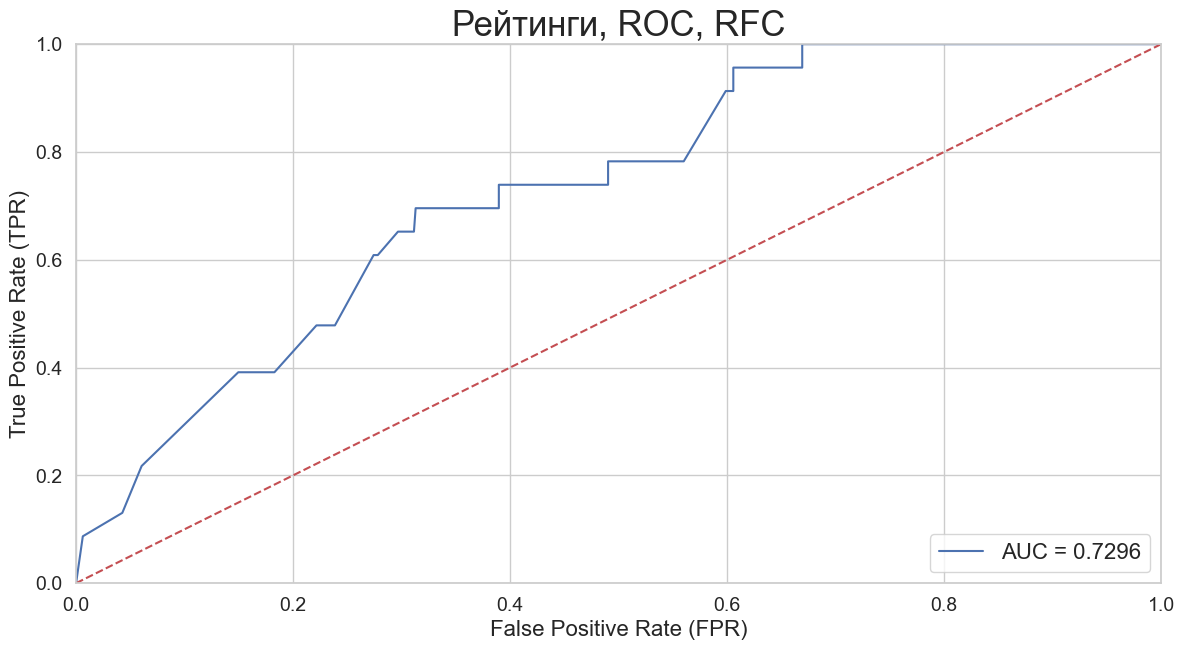

In [99]:
fpr, tpr, threshold = roc_curve(y_val, RFC2.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, RFC', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.4s finished


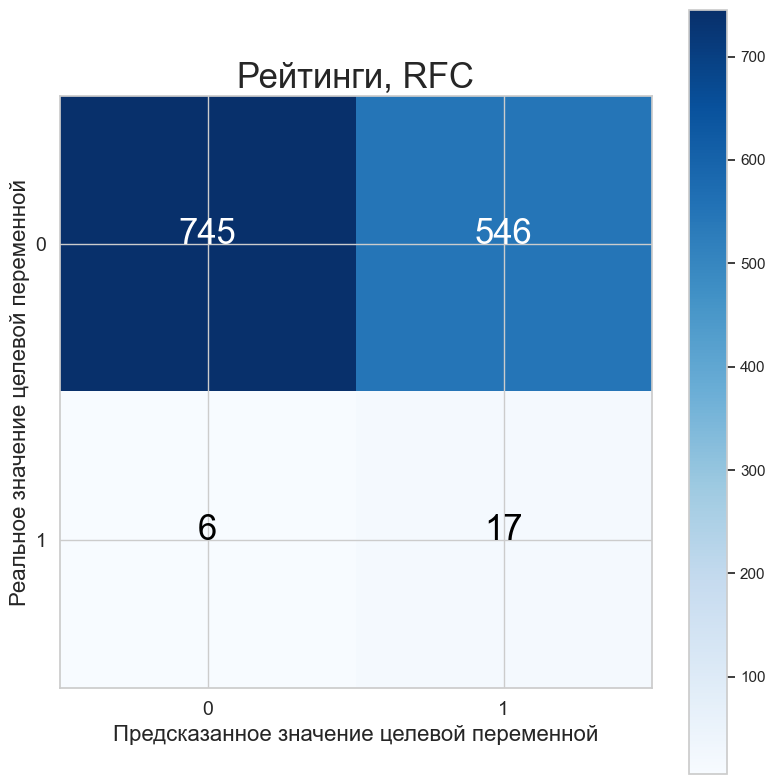

In [100]:
plot_confusion_matrix(confusion_matrix(y_val, RFC2.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, RFC')

In [101]:
# Получить важность признаков
feature_importances = RFC2.feature_importances_

# Получить имена столбцов (имена признаков)
column_names = X_train.columns

# Соотнести имена столбцов с их важностью
importance_data = sorted(zip(column_names, feature_importances), key=lambda x: x[1], reverse=True)

# Вывод 5 самых важных признаков
for col_name, importance in importance_data[:5]:
    print(f'Feature: {col_name}, Importance: {importance}')

Feature: rating_exra_rus, Importance: 0.09817891260636508
Feature: rating_exra_rus_shift_1, Importance: 0.07965717865303834
Feature: rating_fitch_long, Importance: 0.0634807469143481
Feature: rating_fitch_rus, Importance: 0.06320225334423903
Feature: rating_fitch_long_diff_1, Importance: 0.05082917836914864


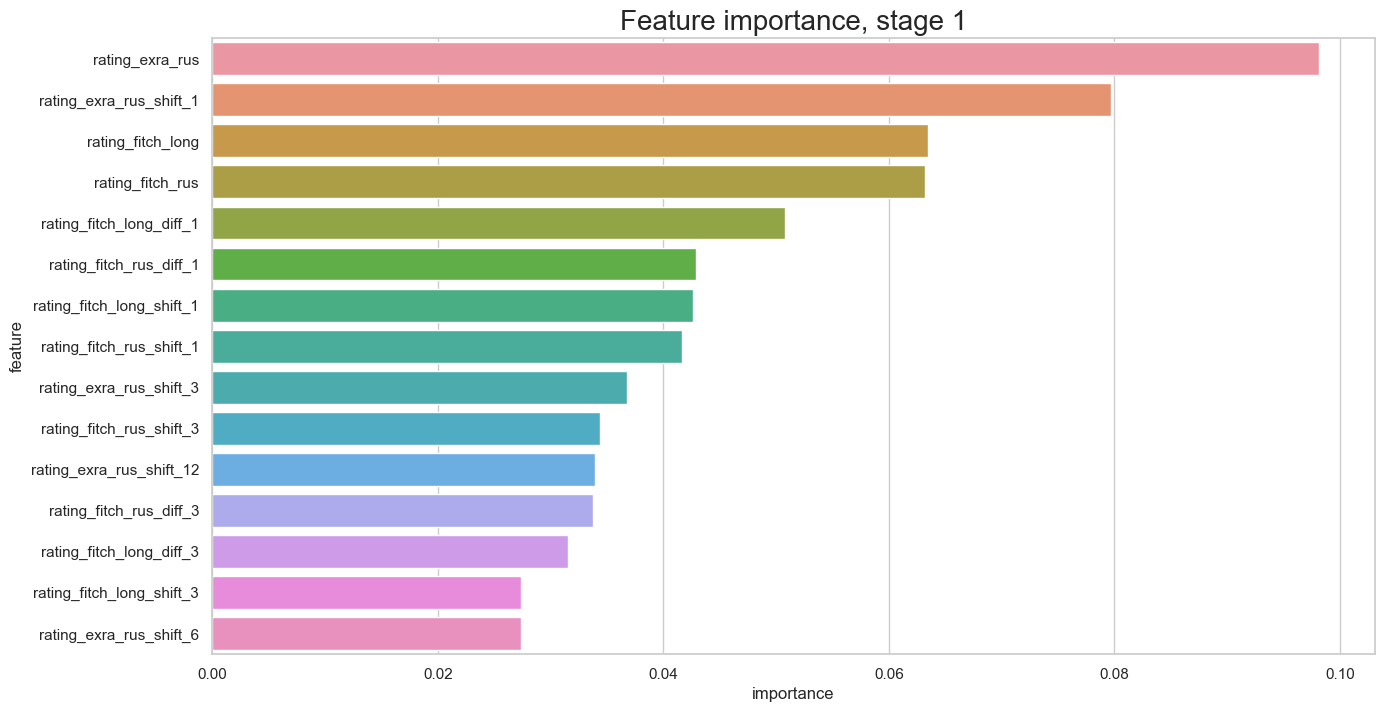

In [102]:
# Создать pandas DataFrame, соотнести имена столбцов с их важностью
df_feature_importances = pd.DataFrame({"feature": column_names, "importance": feature_importances}).sort_values(by="importance", ascending=False)

# Построить график
plt.figure(figsize=(15, 8))
sns.barplot(data=df_feature_importances[:15], x="importance", y="feature")
plt.title("Feature importance, stage 1", fontsize=20)
plt.show()

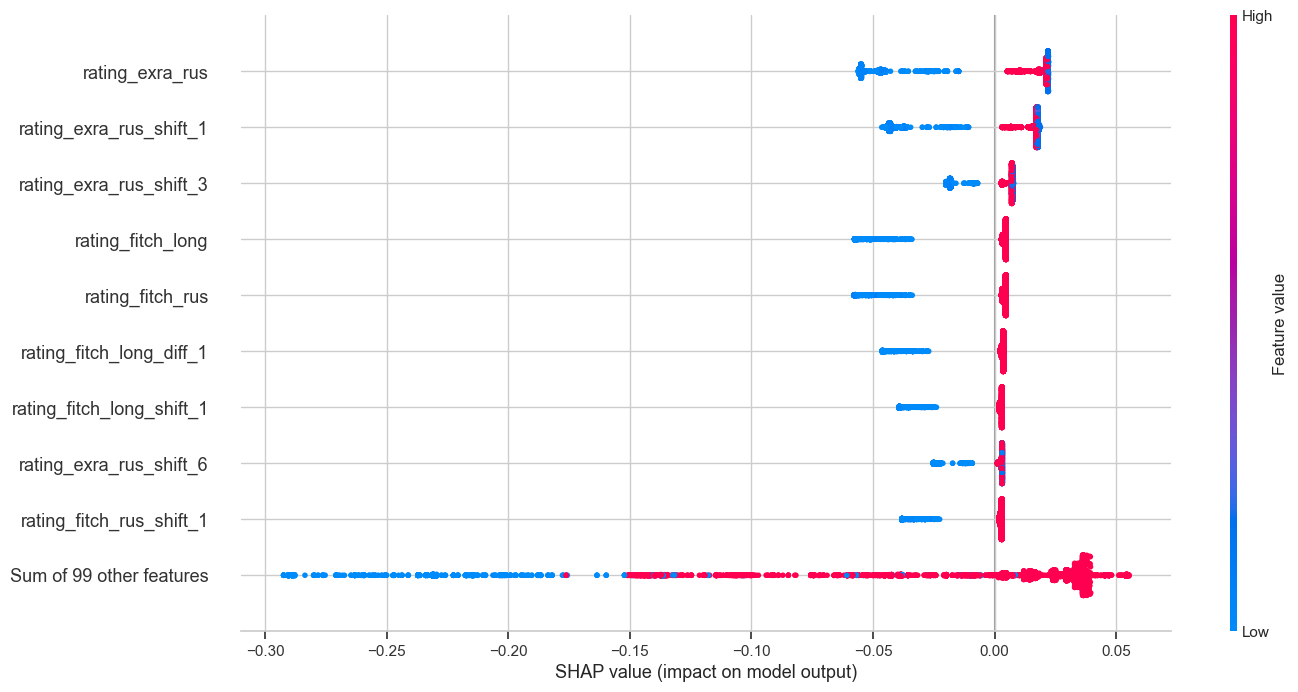

In [103]:
explainer = shap.Explainer(RFC2)
shap_values = explainer(X_train_resampled)

shap.plots.beeswarm(shap_values=shap_values[:, :, 1], plot_size=(15, 8))

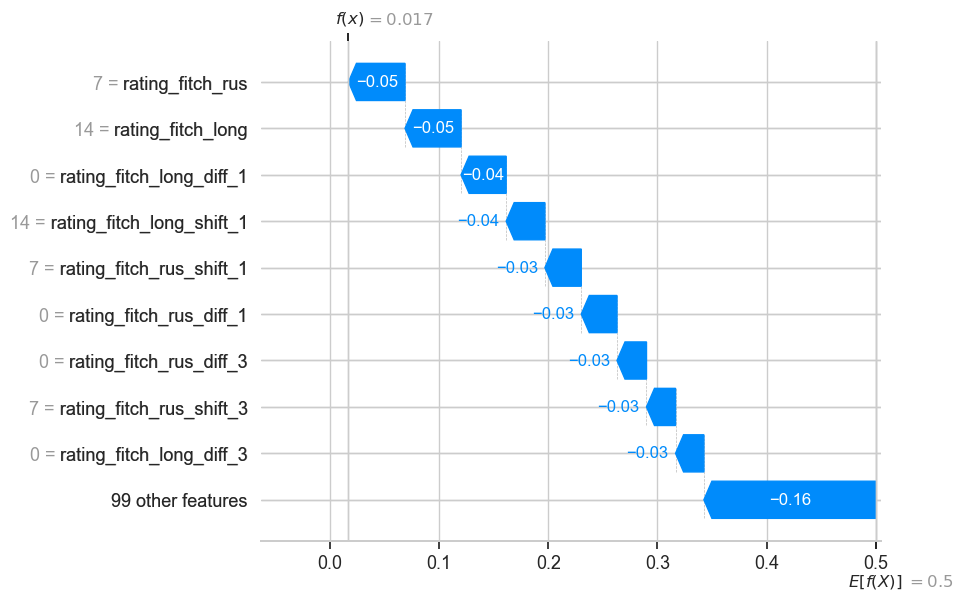

In [104]:
shap.plots.waterfall(shap_values[:, :, 1][2])

In [105]:
oot_proba = RFC2.predict_proba(X_oot)[:, 1]
proba_calibration = RFC2.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(RFC2.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(RFC2.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 

In [106]:
exp_cal_er_RFC = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('RFC = ' + str(exp_cal_er_RFC))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

RFC = 0.3408996998347145
Изотоническая регрессия = 0.016441661292443486
Логистическая регрессия = 0.014791006749684027


In [107]:
proba_test_isotonic_RFC = prb_isotonic_regress

## DecisionTree

In [108]:
DC2 = DecisionTreeClassifier(max_depth=6)
DC2.fit(X_train_resampled, y_train_resampled)
roc_auc_score(y_val, DC2.predict_proba(X_val)[:,1])

0.7764793048866736

In [109]:
print(classification_report(y_val, DC2.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      1291
           1       0.04      0.83      0.08        23

    accuracy                           0.67      1314
   macro avg       0.52      0.75      0.44      1314
weighted avg       0.98      0.67      0.79      1314



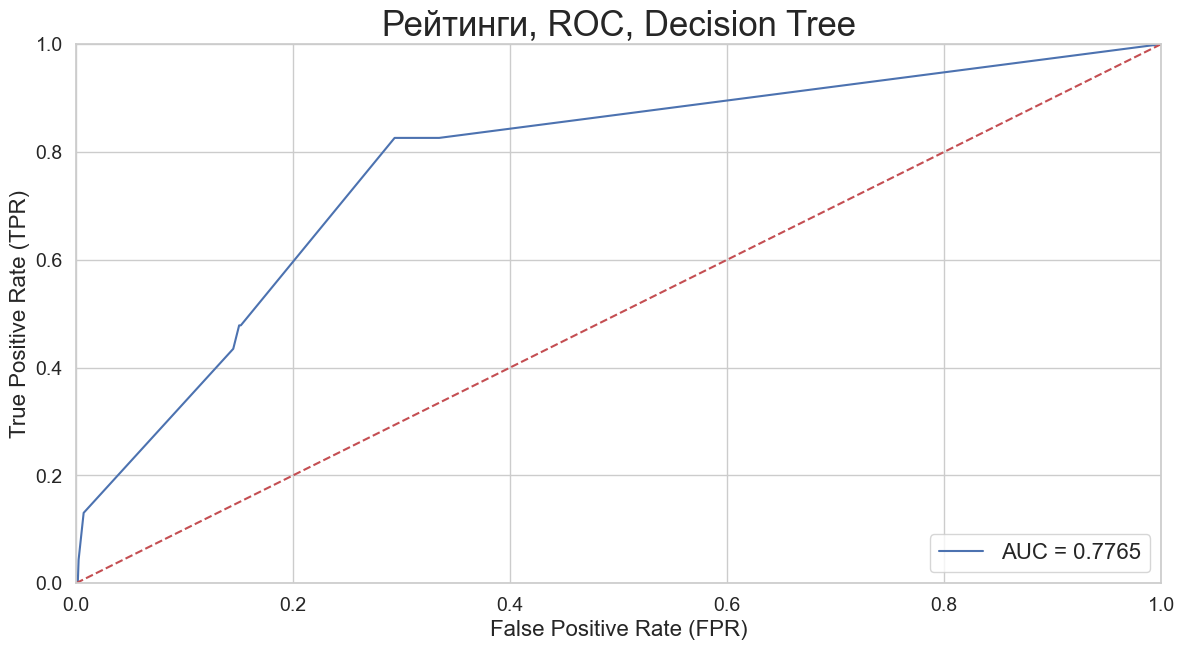

In [110]:
fpr, tpr, threshold = roc_curve(y_val, DC2.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, Decision Tree', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

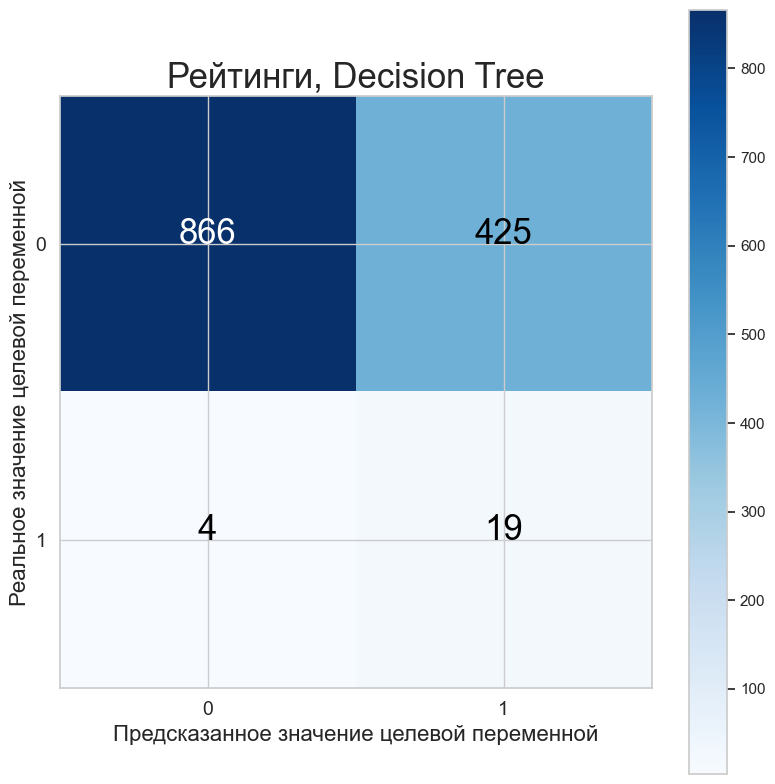

In [111]:
plot_confusion_matrix(confusion_matrix(y_val, DC2.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, Decision Tree')

In [112]:
oot_proba = DC2.predict_proba(X_oot)[:, 1]
roc_auc_score(y_oot, DC2.predict_proba(X_oot)[:,1])

0.6638569604086845

In [113]:
print(classification_report(y_oot, DC2.predict(X_oot)))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      1044
           1       0.03      0.40      0.05        15

    accuracy                           0.77      1059
   macro avg       0.51      0.59      0.46      1059
weighted avg       0.98      0.77      0.86      1059



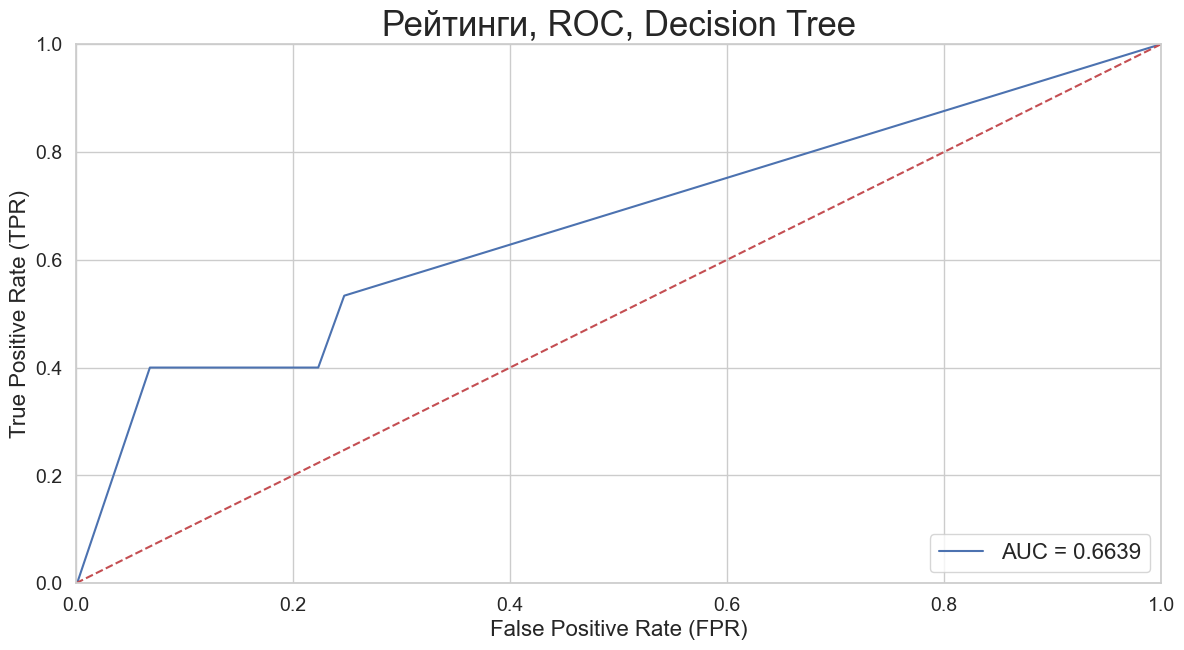

In [114]:
fpr, tpr, threshold = roc_curve(y_oot, DC2.predict_proba(X_oot)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, Decision Tree', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

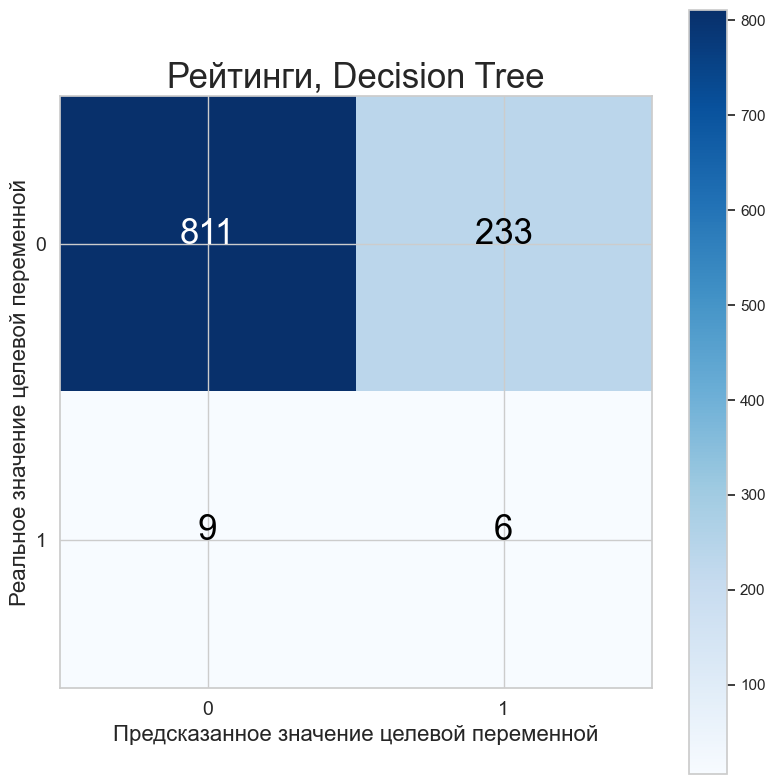

In [115]:
plot_confusion_matrix(confusion_matrix(y_oot, DC2.predict(X_oot)), classes=set(y_oot),
                      title='Рейтинги, Decision Tree')

In [116]:
proba_calibration = DC2.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(DC2.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(DC2.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [117]:
exp_cal_er_dc = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('Дерево = ' + str(exp_cal_er_dc))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

Дерево = 0.15277881405387236
Изотоническая регрессия = 0.009310670443814928
Логистическая регрессия = 0.0060494137431166325


In [118]:
proba_test_logreg_DC = prb_isotonic_regress

## SVM

In [119]:
svm2 = SVC(kernel='rbf', gamma='scale', C=100, probability=True)
svm2.fit(X_train_resampled, y_train_resampled)

svm2.score(X_val, y_val)

0.7754946727549468

In [120]:
print(classification_report(y_val, svm.predict(X_val)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1291
           1       0.50      0.17      0.26        23

    accuracy                           0.98      1314
   macro avg       0.74      0.59      0.62      1314
weighted avg       0.98      0.98      0.98      1314



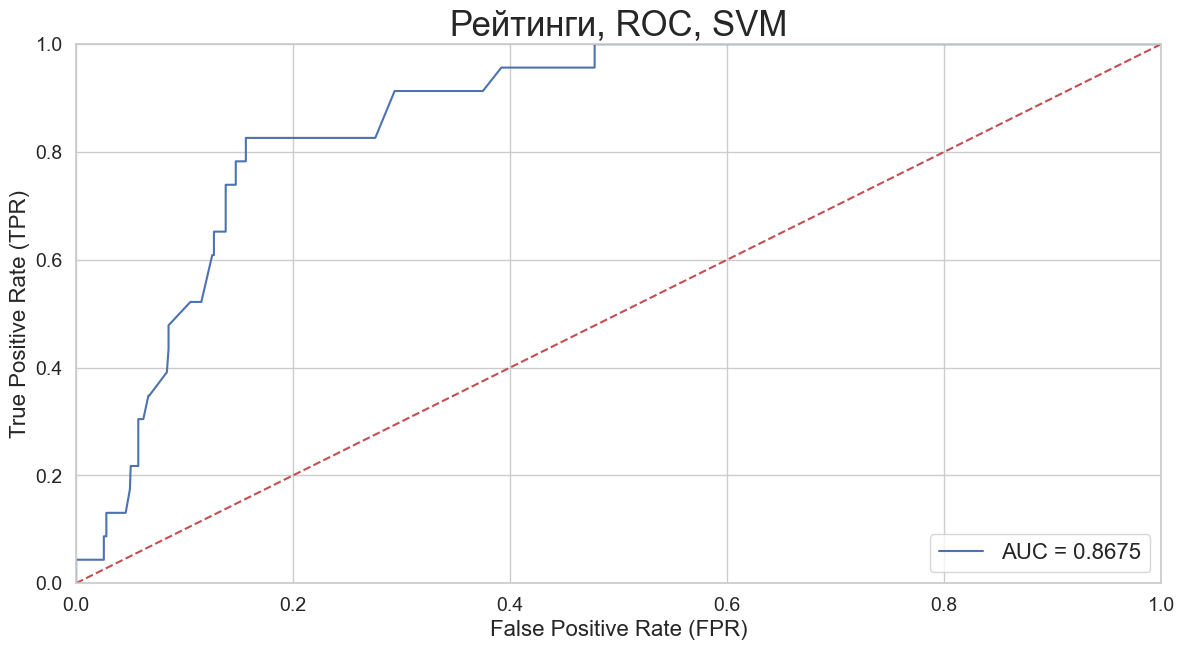

In [121]:
fpr, tpr, threshold = roc_curve(y_val, svm2.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, SVM', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

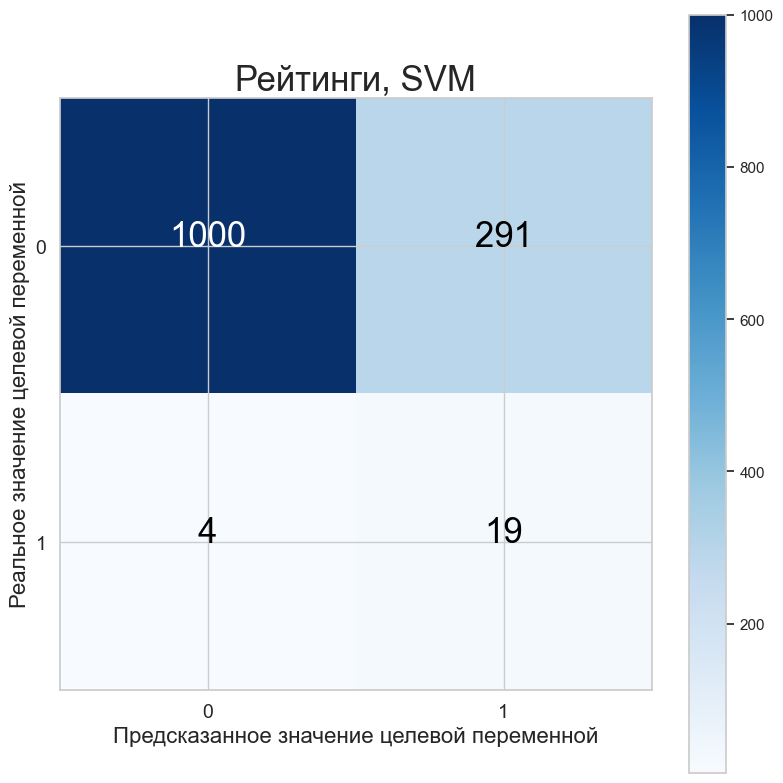

In [122]:
plot_confusion_matrix(confusion_matrix(y_val, svm2.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, SVM')

In [123]:
print(classification_report(y_oot, svm2.predict(X_oot)))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1044
           1       0.04      0.53      0.07        15

    accuracy                           0.79      1059
   macro avg       0.51      0.66      0.47      1059
weighted avg       0.98      0.79      0.87      1059



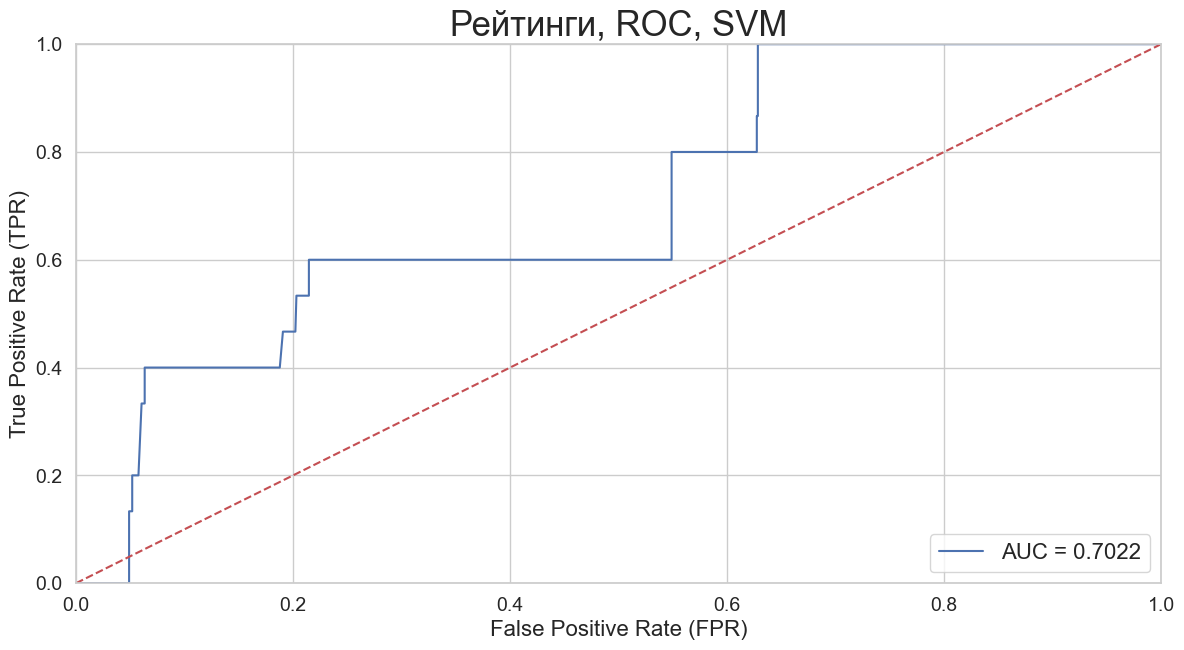

In [124]:
fpr, tpr, threshold = roc_curve(y_oot, svm2.predict_proba(X_oot)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, SVM', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

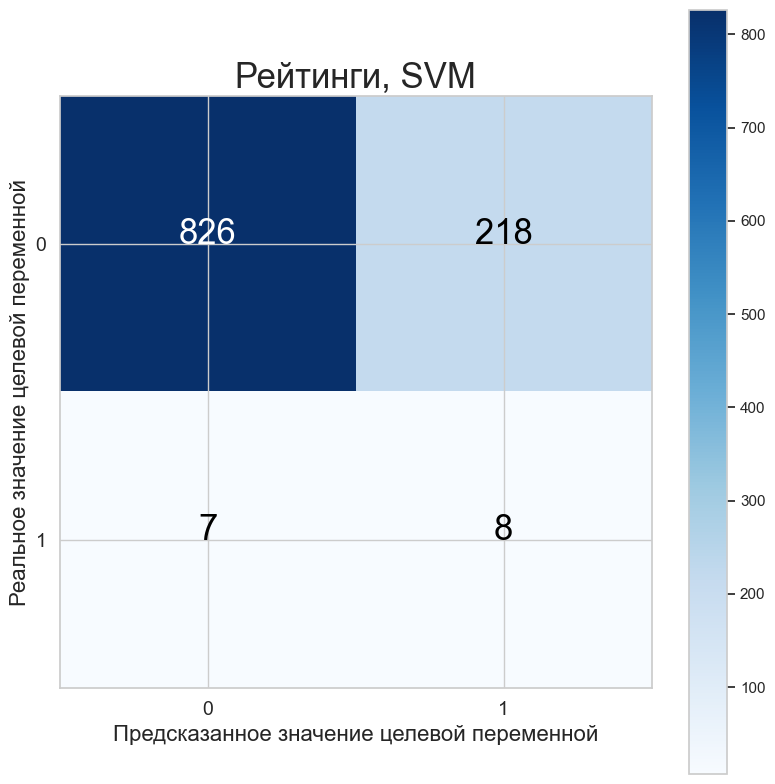

In [125]:
plot_confusion_matrix(confusion_matrix(y_oot, svm2.predict(X_oot)), classes=set(y_oot),
                      title='Рейтинги, SVM')

In [126]:
oot_proba = svm2.predict_proba(X_oot)[:, 1]
proba_calibration = svm2.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(svm2.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(svm2.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [127]:
exp_cal_er_svm = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('SVM = ' + str(exp_cal_er_svm))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

SVM = 0.18232620051482304
Изотоническая регрессия = 0.0015118323521266484
Логистическая регрессия = 0.016110934741640263


In [128]:
proba_test_logreg_svm = prb_isotonic_regress

## LogisticRegression

In [129]:
logistic2 = LogisticRegression(C=0.5, penalty = 'l2', max_iter=100, n_jobs=-1, random_state=42)
logistic2.fit(X_train_resampled, y_train_resampled)
logistic2.score(X_val, y_val)

0.7024353120243532

In [130]:
print(classification_report(y_val, logistic2.predict(X_val)))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1291
           1       0.04      0.70      0.08        23

    accuracy                           0.70      1314
   macro avg       0.52      0.70      0.45      1314
weighted avg       0.98      0.70      0.81      1314



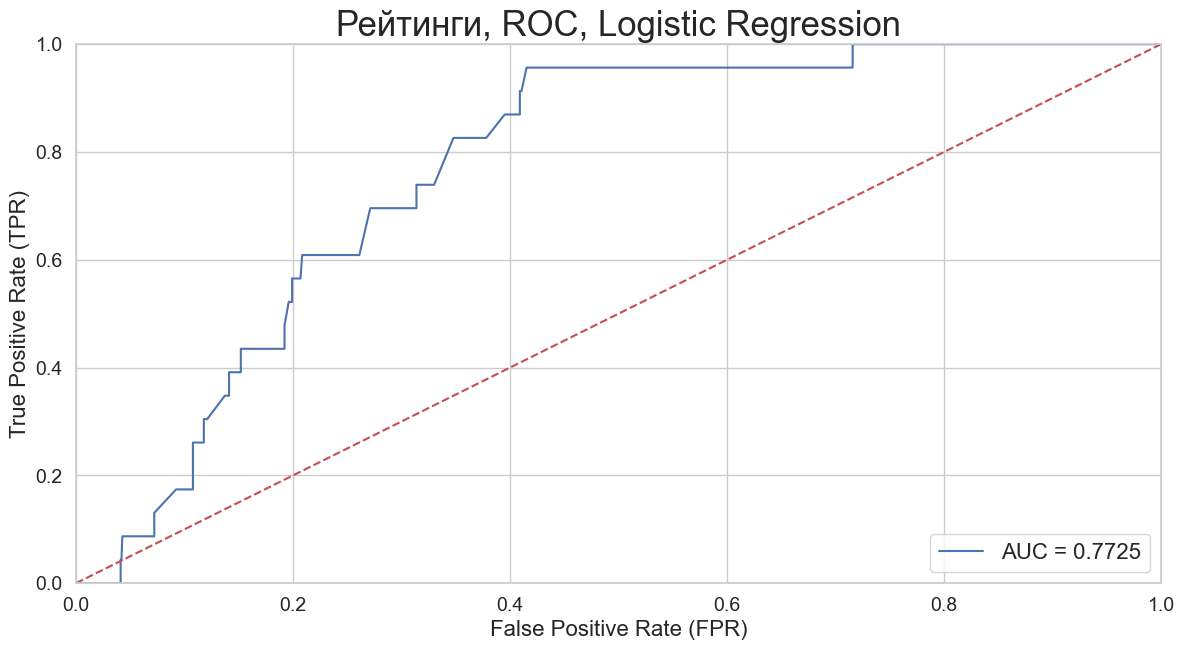

In [131]:
fpr, tpr, threshold = roc_curve(y_val, logistic2.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, Logistic Regression', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

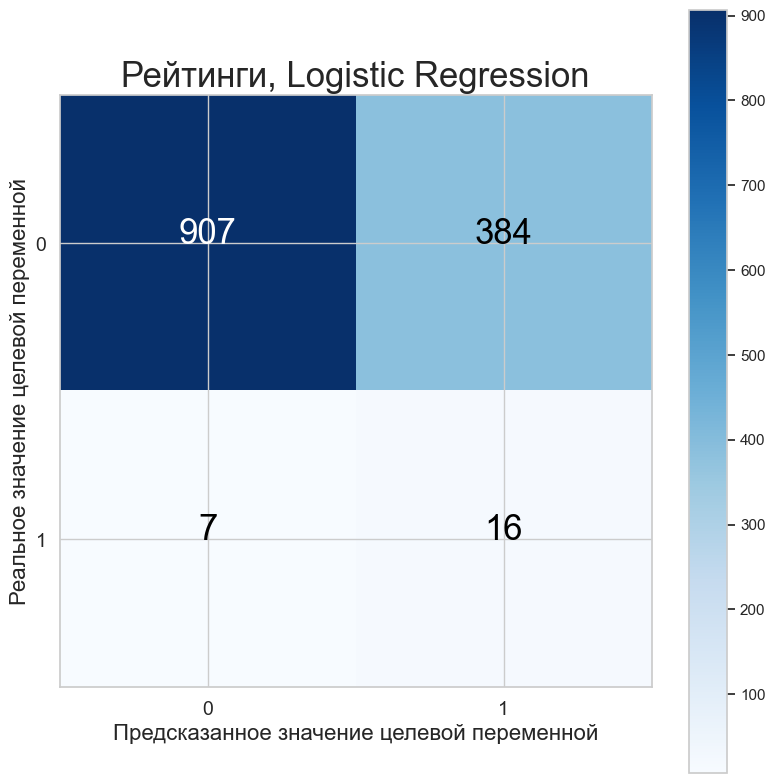

In [132]:
plot_confusion_matrix(confusion_matrix(y_val, logistic2.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, Logistic Regression')

In [133]:
oot_proba = logistic2.predict_proba(X_oot)[:, 1]
proba_calibration = logistic2.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(logistic2.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(logistic.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [134]:
exp_cal_er_logistic = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('Logistic Regression (default) = ' + str(exp_cal_er_logistic))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

Logistic Regression (default) = 0.24842390839827244
Изотоническая регрессия = 0.01307751661345285
Логистическая регрессия = 0.0198868465641392


In [135]:
proba_test_logistic_default = prb_isotonic_regress

## CatBoost

In [136]:
cb = CatBoostClassifier()
cb.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val))

accuracy_score(y_val, cb.predict(X_val))

Learning rate set to 0.056298
0:	learn: 0.6550328	test: 0.6414631	best: 0.6414631 (0)	total: 149ms	remaining: 2m 28s
1:	learn: 0.6203727	test: 0.5937877	best: 0.5937877 (1)	total: 161ms	remaining: 1m 20s
2:	learn: 0.5934861	test: 0.5583227	best: 0.5583227 (2)	total: 172ms	remaining: 57.3s
3:	learn: 0.5694286	test: 0.5279340	best: 0.5279340 (3)	total: 186ms	remaining: 46.3s
4:	learn: 0.5490986	test: 0.5029810	best: 0.5029810 (4)	total: 201ms	remaining: 40s
5:	learn: 0.5333429	test: 0.4869873	best: 0.4869873 (5)	total: 214ms	remaining: 35.5s
6:	learn: 0.5183839	test: 0.4750128	best: 0.4750128 (6)	total: 228ms	remaining: 32.4s
7:	learn: 0.5053070	test: 0.4628176	best: 0.4628176 (7)	total: 242ms	remaining: 30s
8:	learn: 0.4910251	test: 0.4479137	best: 0.4479137 (8)	total: 254ms	remaining: 28s
9:	learn: 0.4796782	test: 0.4373069	best: 0.4373069 (9)	total: 268ms	remaining: 26.5s
10:	learn: 0.4696788	test: 0.4312656	best: 0.4312656 (10)	total: 283ms	remaining: 25.4s
11:	learn: 0.4599245	test:

98:	learn: 0.2618811	test: 0.2859871	best: 0.2859654 (97)	total: 1.48s	remaining: 13.4s
99:	learn: 0.2608777	test: 0.2856853	best: 0.2856853 (99)	total: 1.49s	remaining: 13.4s
100:	learn: 0.2603033	test: 0.2852137	best: 0.2852137 (100)	total: 1.5s	remaining: 13.4s
101:	learn: 0.2597979	test: 0.2850322	best: 0.2850322 (101)	total: 1.52s	remaining: 13.4s
102:	learn: 0.2590031	test: 0.2842173	best: 0.2842173 (102)	total: 1.53s	remaining: 13.3s
103:	learn: 0.2583466	test: 0.2840080	best: 0.2840080 (103)	total: 1.54s	remaining: 13.3s
104:	learn: 0.2573440	test: 0.2831792	best: 0.2831792 (104)	total: 1.56s	remaining: 13.3s
105:	learn: 0.2563528	test: 0.2819502	best: 0.2819502 (105)	total: 1.57s	remaining: 13.3s
106:	learn: 0.2557448	test: 0.2811420	best: 0.2811420 (106)	total: 1.58s	remaining: 13.2s
107:	learn: 0.2545822	test: 0.2793842	best: 0.2793842 (107)	total: 1.6s	remaining: 13.2s
108:	learn: 0.2541612	test: 0.2791182	best: 0.2791182 (108)	total: 1.61s	remaining: 13.2s
109:	learn: 0.25

199:	learn: 0.2112465	test: 0.2419309	best: 0.2419309 (199)	total: 2.78s	remaining: 11.1s
200:	learn: 0.2112228	test: 0.2419442	best: 0.2419309 (199)	total: 2.79s	remaining: 11.1s
201:	learn: 0.2109596	test: 0.2416578	best: 0.2416578 (201)	total: 2.8s	remaining: 11.1s
202:	learn: 0.2103368	test: 0.2410558	best: 0.2410558 (202)	total: 2.81s	remaining: 11s
203:	learn: 0.2100330	test: 0.2408918	best: 0.2408918 (203)	total: 2.83s	remaining: 11s
204:	learn: 0.2095674	test: 0.2405673	best: 0.2405673 (204)	total: 2.84s	remaining: 11s
205:	learn: 0.2092951	test: 0.2402128	best: 0.2402128 (205)	total: 2.85s	remaining: 11s
206:	learn: 0.2086272	test: 0.2395284	best: 0.2395284 (206)	total: 2.87s	remaining: 11s
207:	learn: 0.2083649	test: 0.2395427	best: 0.2395284 (206)	total: 2.88s	remaining: 11s
208:	learn: 0.2078711	test: 0.2390479	best: 0.2390479 (208)	total: 2.89s	remaining: 11s
209:	learn: 0.2078447	test: 0.2390674	best: 0.2390479 (208)	total: 2.91s	remaining: 10.9s
210:	learn: 0.2075976	tes

300:	learn: 0.1872019	test: 0.2219807	best: 0.2219807 (300)	total: 4.09s	remaining: 9.5s
301:	learn: 0.1870011	test: 0.2218866	best: 0.2218866 (301)	total: 4.1s	remaining: 9.48s
302:	learn: 0.1867055	test: 0.2215559	best: 0.2215559 (302)	total: 4.12s	remaining: 9.47s
303:	learn: 0.1865555	test: 0.2215327	best: 0.2215327 (303)	total: 4.13s	remaining: 9.45s
304:	learn: 0.1864154	test: 0.2214537	best: 0.2214537 (304)	total: 4.14s	remaining: 9.44s
305:	learn: 0.1863803	test: 0.2214824	best: 0.2214537 (304)	total: 4.15s	remaining: 9.42s
306:	learn: 0.1860712	test: 0.2211280	best: 0.2211280 (306)	total: 4.17s	remaining: 9.4s
307:	learn: 0.1860410	test: 0.2211101	best: 0.2211101 (307)	total: 4.18s	remaining: 9.38s
308:	learn: 0.1860345	test: 0.2211182	best: 0.2211101 (307)	total: 4.19s	remaining: 9.37s
309:	learn: 0.1857749	test: 0.2208933	best: 0.2208933 (309)	total: 4.2s	remaining: 9.35s
310:	learn: 0.1857568	test: 0.2208267	best: 0.2208267 (310)	total: 4.21s	remaining: 9.33s
311:	learn: 0.

402:	learn: 0.1757504	test: 0.2117875	best: 0.2117875 (402)	total: 5.34s	remaining: 7.92s
403:	learn: 0.1756328	test: 0.2117013	best: 0.2117013 (403)	total: 5.36s	remaining: 7.91s
404:	learn: 0.1756245	test: 0.2116784	best: 0.2116784 (404)	total: 5.37s	remaining: 7.89s
405:	learn: 0.1754666	test: 0.2115353	best: 0.2115353 (405)	total: 5.38s	remaining: 7.88s
406:	learn: 0.1752030	test: 0.2112080	best: 0.2112080 (406)	total: 5.4s	remaining: 7.87s
407:	learn: 0.1751953	test: 0.2112436	best: 0.2112080 (406)	total: 5.42s	remaining: 7.86s
408:	learn: 0.1751119	test: 0.2112202	best: 0.2112080 (406)	total: 5.43s	remaining: 7.84s
409:	learn: 0.1748858	test: 0.2109549	best: 0.2109549 (409)	total: 5.44s	remaining: 7.83s
410:	learn: 0.1748041	test: 0.2108470	best: 0.2108470 (410)	total: 5.46s	remaining: 7.82s
411:	learn: 0.1745874	test: 0.2107569	best: 0.2107569 (411)	total: 5.47s	remaining: 7.81s
412:	learn: 0.1744706	test: 0.2106466	best: 0.2106466 (412)	total: 5.48s	remaining: 7.79s
413:	learn:

500:	learn: 0.1691644	test: 0.2078274	best: 0.2078274 (500)	total: 6.62s	remaining: 6.6s
501:	learn: 0.1690862	test: 0.2078240	best: 0.2078240 (501)	total: 6.64s	remaining: 6.59s
502:	learn: 0.1690381	test: 0.2077910	best: 0.2077910 (502)	total: 6.65s	remaining: 6.57s
503:	learn: 0.1689875	test: 0.2077880	best: 0.2077880 (503)	total: 6.67s	remaining: 6.56s
504:	learn: 0.1689602	test: 0.2077794	best: 0.2077794 (504)	total: 6.68s	remaining: 6.55s
505:	learn: 0.1688953	test: 0.2076606	best: 0.2076606 (505)	total: 6.7s	remaining: 6.54s
506:	learn: 0.1688558	test: 0.2076290	best: 0.2076290 (506)	total: 6.71s	remaining: 6.53s
507:	learn: 0.1688525	test: 0.2076182	best: 0.2076182 (507)	total: 6.72s	remaining: 6.51s
508:	learn: 0.1688484	test: 0.2076113	best: 0.2076113 (508)	total: 6.74s	remaining: 6.5s
509:	learn: 0.1688446	test: 0.2076241	best: 0.2076113 (508)	total: 6.75s	remaining: 6.49s
510:	learn: 0.1688211	test: 0.2076092	best: 0.2076092 (510)	total: 6.76s	remaining: 6.47s
511:	learn: 0

598:	learn: 0.1656967	test: 0.2055771	best: 0.2055771 (598)	total: 7.87s	remaining: 5.27s
599:	learn: 0.1656610	test: 0.2055352	best: 0.2055352 (599)	total: 7.88s	remaining: 5.25s
600:	learn: 0.1656008	test: 0.2055579	best: 0.2055352 (599)	total: 7.89s	remaining: 5.24s
601:	learn: 0.1655671	test: 0.2055622	best: 0.2055352 (599)	total: 7.91s	remaining: 5.23s
602:	learn: 0.1655338	test: 0.2055813	best: 0.2055352 (599)	total: 7.92s	remaining: 5.21s
603:	learn: 0.1655023	test: 0.2055658	best: 0.2055352 (599)	total: 7.93s	remaining: 5.2s
604:	learn: 0.1654918	test: 0.2055974	best: 0.2055352 (599)	total: 7.94s	remaining: 5.19s
605:	learn: 0.1654331	test: 0.2055945	best: 0.2055352 (599)	total: 7.96s	remaining: 5.17s
606:	learn: 0.1654060	test: 0.2055324	best: 0.2055324 (606)	total: 7.97s	remaining: 5.16s
607:	learn: 0.1653514	test: 0.2054877	best: 0.2054877 (607)	total: 7.98s	remaining: 5.14s
608:	learn: 0.1653403	test: 0.2054717	best: 0.2054717 (608)	total: 7.99s	remaining: 5.13s
609:	learn:

700:	learn: 0.1624848	test: 0.2047263	best: 0.2046330 (674)	total: 9.13s	remaining: 3.89s
701:	learn: 0.1624459	test: 0.2046599	best: 0.2046330 (674)	total: 9.14s	remaining: 3.88s
702:	learn: 0.1624280	test: 0.2046908	best: 0.2046330 (674)	total: 9.15s	remaining: 3.87s
703:	learn: 0.1624257	test: 0.2046895	best: 0.2046330 (674)	total: 9.17s	remaining: 3.85s
704:	learn: 0.1624048	test: 0.2047018	best: 0.2046330 (674)	total: 9.18s	remaining: 3.84s
705:	learn: 0.1623793	test: 0.2047084	best: 0.2046330 (674)	total: 9.19s	remaining: 3.83s
706:	learn: 0.1623770	test: 0.2047070	best: 0.2046330 (674)	total: 9.21s	remaining: 3.81s
707:	learn: 0.1623705	test: 0.2047153	best: 0.2046330 (674)	total: 9.22s	remaining: 3.8s
708:	learn: 0.1623371	test: 0.2046829	best: 0.2046330 (674)	total: 9.23s	remaining: 3.79s
709:	learn: 0.1623255	test: 0.2046634	best: 0.2046330 (674)	total: 9.24s	remaining: 3.77s
710:	learn: 0.1623126	test: 0.2046585	best: 0.2046330 (674)	total: 9.25s	remaining: 3.76s
711:	learn:

800:	learn: 0.1604799	test: 0.2045362	best: 0.2044675 (784)	total: 10.4s	remaining: 2.58s
801:	learn: 0.1604765	test: 0.2045395	best: 0.2044675 (784)	total: 10.4s	remaining: 2.57s
802:	learn: 0.1604478	test: 0.2045299	best: 0.2044675 (784)	total: 10.4s	remaining: 2.56s
803:	learn: 0.1604291	test: 0.2044982	best: 0.2044675 (784)	total: 10.4s	remaining: 2.54s
804:	learn: 0.1604132	test: 0.2045360	best: 0.2044675 (784)	total: 10.4s	remaining: 2.53s
805:	learn: 0.1603955	test: 0.2045564	best: 0.2044675 (784)	total: 10.5s	remaining: 2.52s
806:	learn: 0.1603814	test: 0.2045935	best: 0.2044675 (784)	total: 10.5s	remaining: 2.5s
807:	learn: 0.1603638	test: 0.2045766	best: 0.2044675 (784)	total: 10.5s	remaining: 2.49s
808:	learn: 0.1603594	test: 0.2045658	best: 0.2044675 (784)	total: 10.5s	remaining: 2.48s
809:	learn: 0.1603047	test: 0.2045224	best: 0.2044675 (784)	total: 10.5s	remaining: 2.46s
810:	learn: 0.1603005	test: 0.2045114	best: 0.2044675 (784)	total: 10.5s	remaining: 2.45s
811:	learn:

900:	learn: 0.1590335	test: 0.2044993	best: 0.2042276 (878)	total: 11.7s	remaining: 1.28s
901:	learn: 0.1590205	test: 0.2044928	best: 0.2042276 (878)	total: 11.7s	remaining: 1.27s
902:	learn: 0.1589930	test: 0.2044922	best: 0.2042276 (878)	total: 11.7s	remaining: 1.25s
903:	learn: 0.1589539	test: 0.2044695	best: 0.2042276 (878)	total: 11.7s	remaining: 1.24s
904:	learn: 0.1589516	test: 0.2044593	best: 0.2042276 (878)	total: 11.7s	remaining: 1.23s
905:	learn: 0.1589428	test: 0.2044555	best: 0.2042276 (878)	total: 11.7s	remaining: 1.22s
906:	learn: 0.1589341	test: 0.2044199	best: 0.2042276 (878)	total: 11.7s	remaining: 1.2s
907:	learn: 0.1589229	test: 0.2044151	best: 0.2042276 (878)	total: 11.7s	remaining: 1.19s
908:	learn: 0.1589070	test: 0.2044152	best: 0.2042276 (878)	total: 11.8s	remaining: 1.18s
909:	learn: 0.1588982	test: 0.2044315	best: 0.2042276 (878)	total: 11.8s	remaining: 1.16s
910:	learn: 0.1588980	test: 0.2044289	best: 0.2042276 (878)	total: 11.8s	remaining: 1.15s
911:	learn:

0.8843226788432268

In [137]:
print(classification_report(y_val, cb.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1291
           1       0.11      0.78      0.19        23

    accuracy                           0.88      1314
   macro avg       0.55      0.83      0.56      1314
weighted avg       0.98      0.88      0.92      1314



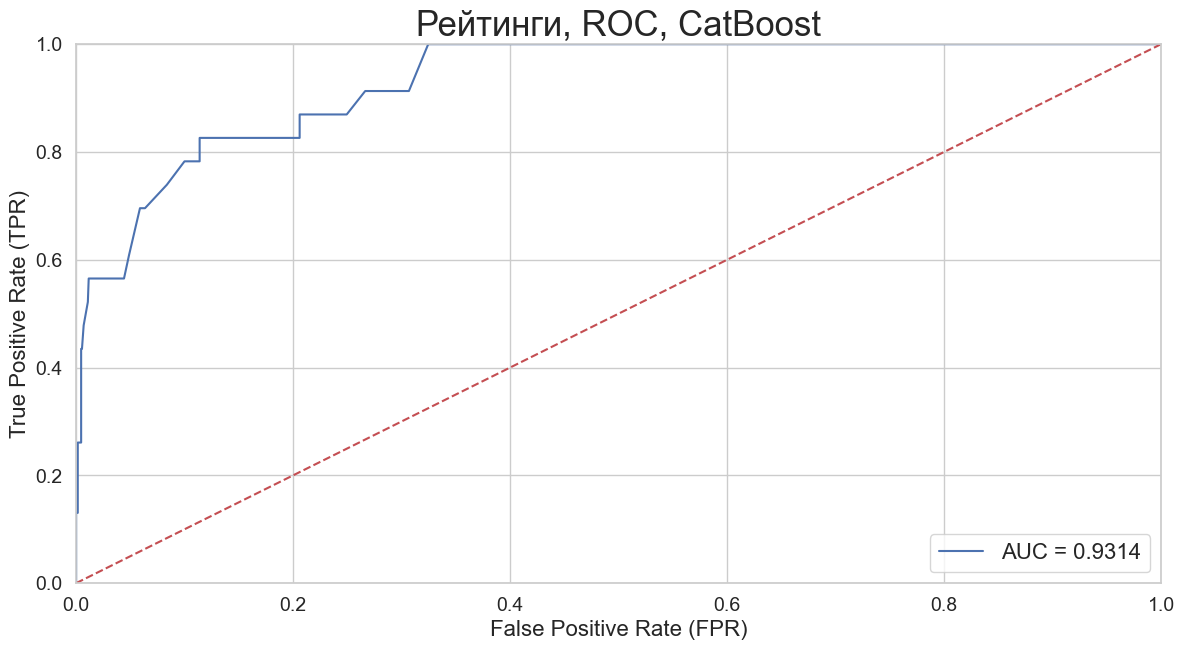

In [138]:
fpr, tpr, threshold = roc_curve(y_val, cb.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(14, 7))
plt.title('Рейтинги, ROC, CatBoost', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 16)
plt.xlabel('False Positive Rate (FPR)', fontsize = 16)
plt.show()

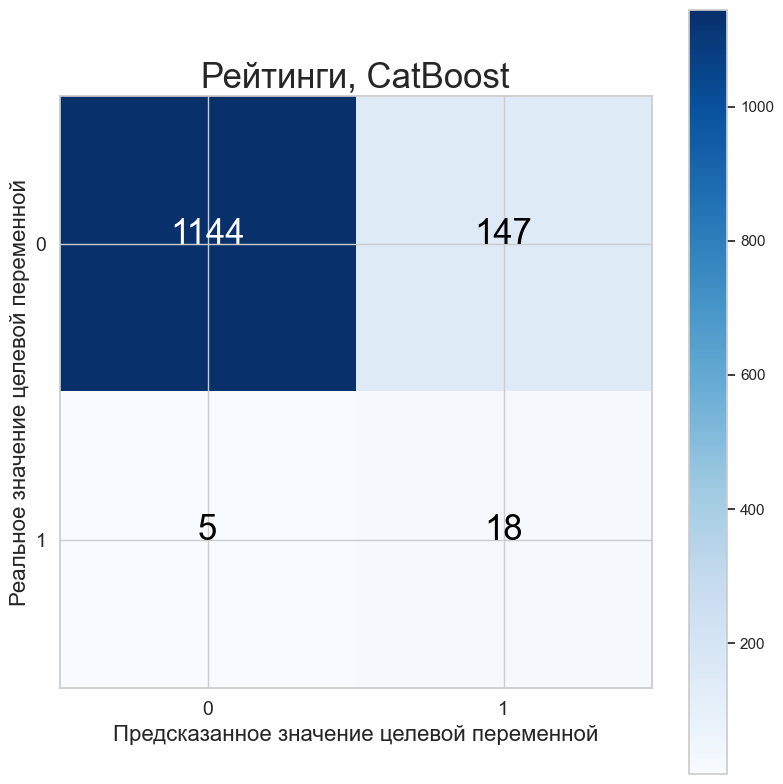

In [139]:
plot_confusion_matrix(confusion_matrix(y_val, cb.predict(X_val)), classes=set(y_val),
                      title='Рейтинги, CatBoost')

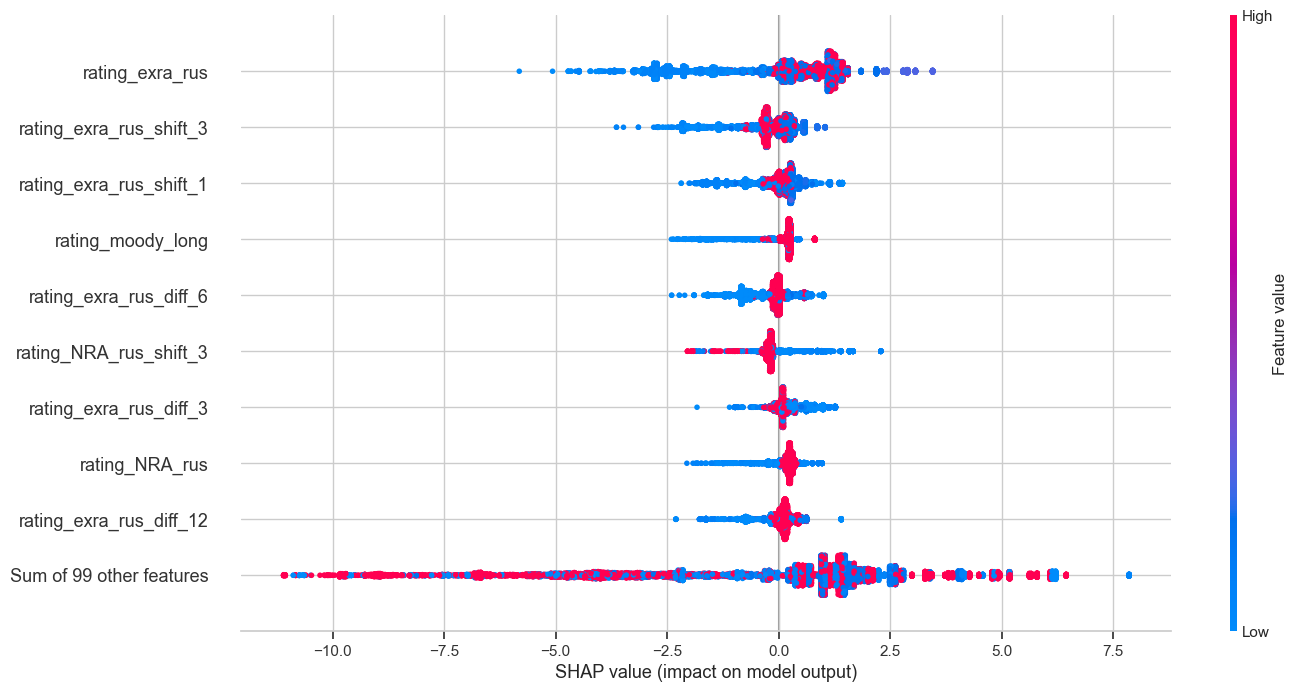

In [140]:
explainer = shap.Explainer(cb)
shap_values = explainer(X_train_resampled)

shap.plots.beeswarm(shap_values=shap_values, plot_size=(15, 8))

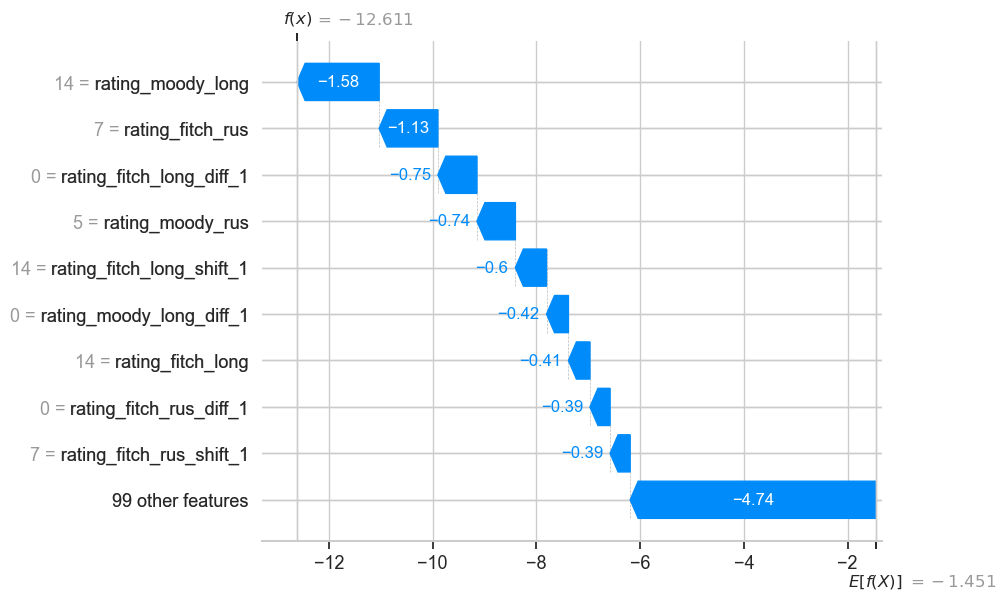

In [141]:
shap.plots.waterfall(shap_values[2])

In [142]:
oot_proba = cb.predict_proba(X_oot)[:, 1]
proba_calibration = cb.predict_proba(X_calibration)[:, 1]

isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_calibration, y_calibration) 
prb_isotonic_regress = isotonic_regress.predict(cb.predict_proba(X_oot)[:, 1])

log_reg = LogisticRegression().fit(proba_calibration.reshape(-1, 1), y_calibration)
proba_test_logreg = log_reg.predict_proba(cb.predict_proba(X_oot)[:, 1].reshape(-1, 1))[:, 1]

In [143]:
exp_cal_er_GBC = expected_calibration_error(y_oot, oot_proba)
exp_cal_er_iso = expected_calibration_error(y_oot, prb_isotonic_regress)
exp_cal_er_ = expected_calibration_error(y_oot, proba_test_logreg)
print('GBC = ' + str(exp_cal_er_GBC))
print('Изотоническая регрессия = ' + str(exp_cal_er_iso))
print('Логистическая регрессия = ' + str(exp_cal_er_)) # the best

GBC = 0.06974195196378873
Изотоническая регрессия = 0.002138633800266498
Логистическая регрессия = 0.020290878208982784


In [144]:
proba_test_isotonic_cb = prb_isotonic_regress

## Upsampling results

In [145]:
def calculate_metrics(y_true, y_proba):
    roc_auc = roc_auc_score(y_true, y_proba)
    
    # Коэффициент Джини можно вычислить как 2 * ROC AUC - 1
    gini = 2 * roc_auc - 1
             
    return roc_auc, gini

In [146]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_logistic_default)
print(f"ROC AUC, Logistic Regression: {roc_auc}")
print(f"Gini, Logistic Regression: {gini}")

ROC AUC, Logistic Regression: 0.7833652618135376
Gini, Logistic Regression: 0.5667305236270752


In [147]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_logreg_DC)
print(f"ROC AUC, Decision Tree: {roc_auc}")
print(f"Gini, Decision Tree: {gini}")

ROC AUC, Decision Tree: 0.6742017879948914
Gini, Decision Tree: 0.3484035759897828


In [148]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_logreg_svm)
print(f"ROC AUC, SVM: {roc_auc}")
print(f"Gini, SVM: {gini}")

ROC AUC, SVM: 0.6330459770114942
Gini, SVM: 0.26609195402298846


In [149]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_isotonic_GBC)
print(f"ROC AUC, GBC: {roc_auc}")
print(f"Gini, GBC: {gini}")

ROC AUC, GBC: 0.7862707535121328
Gini, GBC: 0.5725415070242657


In [150]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_isotonic_RFC)
print(f"ROC AUC, RFC: {roc_auc}")
print(f"Gini, RFC: {gini}")

ROC AUC, RFC: 0.7044061302681992
Gini, RFC: 0.4088122605363984


In [151]:
roc_auc, gini = calculate_metrics(y_oot, proba_test_isotonic_cb)
print(f"ROC AUC, CB: {roc_auc}")
print(f"Gini, CB: {gini}")

ROC AUC, CB: 0.6846743295019156
Gini, CB: 0.3693486590038313


color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.


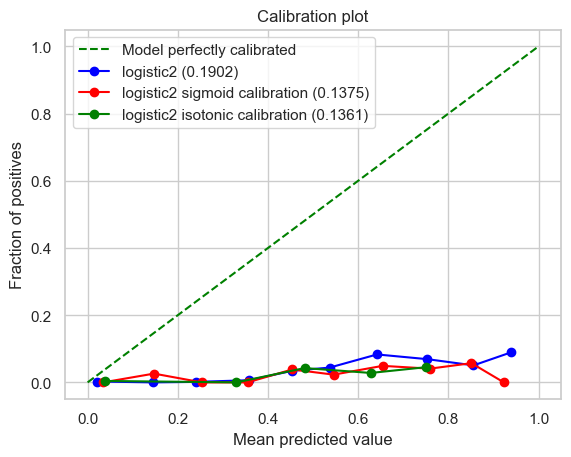

In [152]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Model perfectly calibrated", color='green')
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot')

logistic2.fit(X_train_resampled, y_train_resampled)

prob_pos_rfc = logistic2.predict_proba(X_train)[:, 1]
model_rfc_score = brier_score_loss(y_train, prob_pos_rfc, pos_label=y_train.max())
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_train, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "go-", color='blue', label=f'logistic2 ({round(model_rfc_score, 4)})')

calibrator_sigmoid = CalibratedClassifierCV(logistic2, cv='prefit', method='sigmoid')
calibrator_sigmoid.fit(X_train_resampled, y_train_resampled)
sigmoid_prob_pos_rfc = calibrator_sigmoid.predict_proba(X_oot)[:, 1]
calibrated_model_sigmoid_score = brier_score_loss(y_oot, sigmoid_prob_pos_rfc, pos_label=y_oot.max())
sigmoid_fraction_of_positives_rfc, sigmoid_mean_predicted_value_rfc = calibration_curve(y_oot, sigmoid_prob_pos_rfc, n_bins=10)
ax.plot(sigmoid_mean_predicted_value_rfc, sigmoid_fraction_of_positives_rfc, "go-", color='red', label=f'logistic2 sigmoid calibration ({round(calibrated_model_sigmoid_score, 4)})')

calibrator_isotonic = CalibratedClassifierCV(logistic2, cv='prefit', method='isotonic')
calibrator_isotonic.fit(X_train_resampled, y_train_resampled)
isotonic_prob_pos_rfc = calibrator_isotonic.predict_proba(X_oot)[:, 1]
calibrated_model_isotonic_score = brier_score_loss(y_oot, isotonic_prob_pos_rfc, pos_label=y_train.max())
isotonic_fraction_of_positives_rfc, isotonic_mean_predicted_value_rfc = calibration_curve(y_oot, isotonic_prob_pos_rfc, n_bins=10)
ax.plot(isotonic_mean_predicted_value_rfc, isotonic_fraction_of_positives_rfc, "go-", color='green', label=f'logistic2 isotonic calibration ({round(calibrated_model_isotonic_score, 4)})')


ax.legend(loc="upper left")
plt.show()

color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.


Learning rate set to 0.027823
0:	learn: 0.6737017	total: 12.3ms	remaining: 12.3s
1:	learn: 0.6545264	total: 23.8ms	remaining: 11.9s
2:	learn: 0.6381170	total: 35ms	remaining: 11.6s
3:	learn: 0.6224931	total: 46.4ms	remaining: 11.5s
4:	learn: 0.6081389	total: 58.8ms	remaining: 11.7s
5:	learn: 0.5947339	total: 71.2ms	remaining: 11.8s
6:	learn: 0.5821182	total: 83.5ms	remaining: 11.8s
7:	learn: 0.5711083	total: 95.8ms	remaining: 11.9s
8:	learn: 0.5609971	total: 108ms	remaining: 11.9s
9:	learn: 0.5507794	total: 120ms	remaining: 11.9s
10:	learn: 0.5416840	total: 133ms	remaining: 12s
11:	learn: 0.5335103	total: 146ms	remaining: 12s
12:	learn: 0.5257855	total: 159ms	remaining: 12s
13:	learn: 0.5163701	total: 172ms	remaining: 12.1s
14:	learn: 0.5099657	total: 184ms	remaining: 12.1s
15:	learn: 0.5040143	total: 196ms	remaining: 12.1s
16:	learn: 0.4988441	total: 209ms	remaining: 12.1s
17:	learn: 0.4928879	total: 221ms	remaining: 12s
18:	learn: 0.4866230	total: 234ms	remaining: 12.1s
19:	learn: 0.

168:	learn: 0.2703426	total: 2.14s	remaining: 10.5s
169:	learn: 0.2698754	total: 2.15s	remaining: 10.5s
170:	learn: 0.2696488	total: 2.16s	remaining: 10.5s
171:	learn: 0.2695762	total: 2.17s	remaining: 10.5s
172:	learn: 0.2691495	total: 2.19s	remaining: 10.5s
173:	learn: 0.2689172	total: 2.2s	remaining: 10.4s
174:	learn: 0.2685700	total: 2.21s	remaining: 10.4s
175:	learn: 0.2681736	total: 2.22s	remaining: 10.4s
176:	learn: 0.2679232	total: 2.23s	remaining: 10.4s
177:	learn: 0.2678038	total: 2.25s	remaining: 10.4s
178:	learn: 0.2673602	total: 2.26s	remaining: 10.4s
179:	learn: 0.2667641	total: 2.27s	remaining: 10.3s
180:	learn: 0.2662533	total: 2.28s	remaining: 10.3s
181:	learn: 0.2652795	total: 2.29s	remaining: 10.3s
182:	learn: 0.2648133	total: 2.31s	remaining: 10.3s
183:	learn: 0.2646844	total: 2.32s	remaining: 10.3s
184:	learn: 0.2643135	total: 2.33s	remaining: 10.3s
185:	learn: 0.2639975	total: 2.35s	remaining: 10.3s
186:	learn: 0.2634411	total: 2.36s	remaining: 10.3s
187:	learn: 0

331:	learn: 0.2280387	total: 4.24s	remaining: 8.54s
332:	learn: 0.2278674	total: 4.26s	remaining: 8.53s
333:	learn: 0.2275907	total: 4.27s	remaining: 8.51s
334:	learn: 0.2270654	total: 4.28s	remaining: 8.5s
335:	learn: 0.2269018	total: 4.29s	remaining: 8.49s
336:	learn: 0.2268785	total: 4.31s	remaining: 8.47s
337:	learn: 0.2268564	total: 4.32s	remaining: 8.46s
338:	learn: 0.2265663	total: 4.33s	remaining: 8.44s
339:	learn: 0.2265306	total: 4.34s	remaining: 8.43s
340:	learn: 0.2263472	total: 4.35s	remaining: 8.41s
341:	learn: 0.2260924	total: 4.37s	remaining: 8.4s
342:	learn: 0.2257982	total: 4.38s	remaining: 8.39s
343:	learn: 0.2257720	total: 4.39s	remaining: 8.37s
344:	learn: 0.2257254	total: 4.4s	remaining: 8.36s
345:	learn: 0.2253349	total: 4.42s	remaining: 8.35s
346:	learn: 0.2248692	total: 4.43s	remaining: 8.33s
347:	learn: 0.2246840	total: 4.44s	remaining: 8.32s
348:	learn: 0.2246711	total: 4.45s	remaining: 8.3s
349:	learn: 0.2241672	total: 4.46s	remaining: 8.29s
350:	learn: 0.22

495:	learn: 0.2010474	total: 6.35s	remaining: 6.45s
496:	learn: 0.2008941	total: 6.36s	remaining: 6.44s
497:	learn: 0.2007540	total: 6.38s	remaining: 6.43s
498:	learn: 0.2006453	total: 6.39s	remaining: 6.42s
499:	learn: 0.2004739	total: 6.4s	remaining: 6.4s
500:	learn: 0.2003237	total: 6.42s	remaining: 6.39s
501:	learn: 0.2003064	total: 6.43s	remaining: 6.38s
502:	learn: 0.2002034	total: 6.44s	remaining: 6.36s
503:	learn: 0.2000558	total: 6.45s	remaining: 6.35s
504:	learn: 0.1999186	total: 6.46s	remaining: 6.33s
505:	learn: 0.1997863	total: 6.47s	remaining: 6.32s
506:	learn: 0.1996505	total: 6.49s	remaining: 6.31s
507:	learn: 0.1995513	total: 6.5s	remaining: 6.3s
508:	learn: 0.1994631	total: 6.51s	remaining: 6.28s
509:	learn: 0.1992959	total: 6.53s	remaining: 6.27s
510:	learn: 0.1991685	total: 6.54s	remaining: 6.26s
511:	learn: 0.1990486	total: 6.55s	remaining: 6.25s
512:	learn: 0.1988488	total: 6.57s	remaining: 6.24s
513:	learn: 0.1986305	total: 6.58s	remaining: 6.22s
514:	learn: 0.19

666:	learn: 0.1856022	total: 8.46s	remaining: 4.22s
667:	learn: 0.1855186	total: 8.48s	remaining: 4.21s
668:	learn: 0.1854335	total: 8.49s	remaining: 4.2s
669:	learn: 0.1853427	total: 8.5s	remaining: 4.19s
670:	learn: 0.1852853	total: 8.51s	remaining: 4.17s
671:	learn: 0.1852259	total: 8.53s	remaining: 4.16s
672:	learn: 0.1851268	total: 8.54s	remaining: 4.15s
673:	learn: 0.1850953	total: 8.55s	remaining: 4.14s
674:	learn: 0.1850390	total: 8.56s	remaining: 4.12s
675:	learn: 0.1849652	total: 8.58s	remaining: 4.11s
676:	learn: 0.1848569	total: 8.59s	remaining: 4.1s
677:	learn: 0.1847779	total: 8.6s	remaining: 4.08s
678:	learn: 0.1847102	total: 8.61s	remaining: 4.07s
679:	learn: 0.1846635	total: 8.62s	remaining: 4.06s
680:	learn: 0.1846140	total: 8.64s	remaining: 4.04s
681:	learn: 0.1845575	total: 8.65s	remaining: 4.03s
682:	learn: 0.1844430	total: 8.66s	remaining: 4.02s
683:	learn: 0.1844083	total: 8.67s	remaining: 4.01s
684:	learn: 0.1843360	total: 8.68s	remaining: 3.99s
685:	learn: 0.18

839:	learn: 0.1759027	total: 10.6s	remaining: 2.02s
840:	learn: 0.1758509	total: 10.6s	remaining: 2s
841:	learn: 0.1758422	total: 10.6s	remaining: 1.99s
842:	learn: 0.1757966	total: 10.6s	remaining: 1.98s
843:	learn: 0.1757624	total: 10.6s	remaining: 1.97s
844:	learn: 0.1757563	total: 10.6s	remaining: 1.95s
845:	learn: 0.1757267	total: 10.7s	remaining: 1.94s
846:	learn: 0.1756999	total: 10.7s	remaining: 1.93s
847:	learn: 0.1756669	total: 10.7s	remaining: 1.92s
848:	learn: 0.1756310	total: 10.7s	remaining: 1.9s
849:	learn: 0.1755538	total: 10.7s	remaining: 1.89s
850:	learn: 0.1755329	total: 10.7s	remaining: 1.88s
851:	learn: 0.1754709	total: 10.8s	remaining: 1.87s
852:	learn: 0.1754442	total: 10.8s	remaining: 1.85s
853:	learn: 0.1753943	total: 10.8s	remaining: 1.84s
854:	learn: 0.1753930	total: 10.8s	remaining: 1.83s
855:	learn: 0.1753918	total: 10.8s	remaining: 1.82s
856:	learn: 0.1753532	total: 10.8s	remaining: 1.8s
857:	learn: 0.1753494	total: 10.8s	remaining: 1.79s
858:	learn: 0.175

color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.


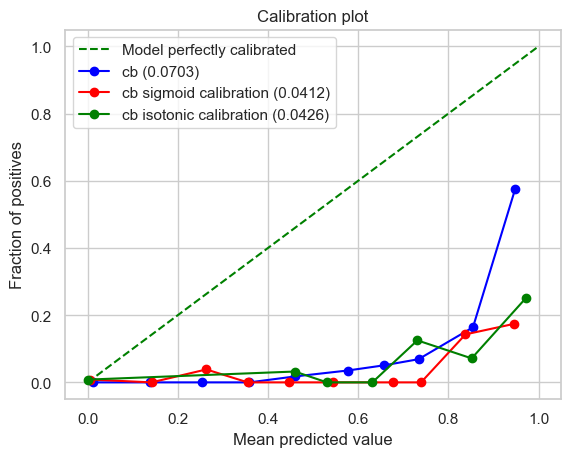

In [153]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Model perfectly calibrated", color='green')
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot')

cb.fit(X_train_resampled, y_train_resampled)

prob_pos_rfc = cb.predict_proba(X_train)[:, 1]
model_rfc_score = brier_score_loss(y_train, prob_pos_rfc, pos_label=y_train.max())
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_train, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "go-", color='blue', label=f'cb ({round(model_rfc_score, 4)})')

calibrator_sigmoid = CalibratedClassifierCV(cb, cv='prefit', method='sigmoid')
calibrator_sigmoid.fit(X_train_resampled, y_train_resampled)
sigmoid_prob_pos_rfc = calibrator_sigmoid.predict_proba(X_oot)[:, 1]
calibrated_model_sigmoid_score = brier_score_loss(y_oot, sigmoid_prob_pos_rfc, pos_label=y_oot.max())
sigmoid_fraction_of_positives_rfc, sigmoid_mean_predicted_value_rfc = calibration_curve(y_oot, sigmoid_prob_pos_rfc, n_bins=10)
ax.plot(sigmoid_mean_predicted_value_rfc, sigmoid_fraction_of_positives_rfc, "go-", color='red', label=f'cb sigmoid calibration ({round(calibrated_model_sigmoid_score, 4)})')

calibrator_isotonic = CalibratedClassifierCV(cb, cv='prefit', method='isotonic')
calibrator_isotonic.fit(X_train_resampled, y_train_resampled)
isotonic_prob_pos_rfc = calibrator_isotonic.predict_proba(X_oot)[:, 1]
calibrated_model_isotonic_score = brier_score_loss(y_oot, isotonic_prob_pos_rfc, pos_label=y_train.max())
isotonic_fraction_of_positives_rfc, isotonic_mean_predicted_value_rfc = calibration_curve(y_oot, isotonic_prob_pos_rfc, n_bins=10)
ax.plot(isotonic_mean_predicted_value_rfc, isotonic_fraction_of_positives_rfc, "go-", color='green', label=f'cb isotonic calibration ({round(calibrated_model_isotonic_score, 4)})')


ax.legend(loc="upper left")
plt.show()

color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3814           0.0051           25.47s
         2           1.3768           0.0051           23.95s
         3           1.3716           0.0050           23.44s
         4           1.3662           0.0048           22.80s
         5           1.3615           0.0048           22.71s
         6           1.3577           0.0048           22.40s
         7           1.3519           0.0045           23.02s
         8           1.3491           0.0045           23.30s
         9           1.3443           0.0044           23.01s
        10           1.3402           0.0041           23.08s
        20           1.2992           0.0036           28.03s
        30           1.2657           0.0031           26.89s
        40           1.2358           0.0025           25.75s
        50           1.2098           0.0023           24.46s
        60           1.1878           0.0021           23.77s
       

color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.


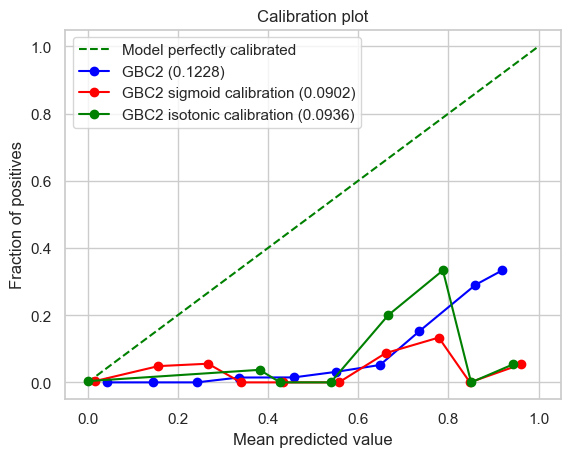

In [154]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Model perfectly calibrated", color='green')
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot')

GBC2.fit(X_train_resampled, y_train_resampled)

prob_pos_rfc = GBC2.predict_proba(X_train)[:, 1]
model_rfc_score = brier_score_loss(y_train, prob_pos_rfc, pos_label=y_train.max())
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_train, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "go-", color='blue', label=f'GBC2 ({round(model_rfc_score, 4)})')

calibrator_sigmoid = CalibratedClassifierCV(GBC2, cv='prefit', method='sigmoid')
calibrator_sigmoid.fit(X_train_resampled, y_train_resampled)
sigmoid_prob_pos_rfc = calibrator_sigmoid.predict_proba(X_oot)[:, 1]
calibrated_model_sigmoid_score = brier_score_loss(y_oot, sigmoid_prob_pos_rfc, pos_label=y_oot.max())
sigmoid_fraction_of_positives_rfc, sigmoid_mean_predicted_value_rfc = calibration_curve(y_oot, sigmoid_prob_pos_rfc, n_bins=10)
ax.plot(sigmoid_mean_predicted_value_rfc, sigmoid_fraction_of_positives_rfc, "go-", color='red', label=f'GBC2 sigmoid calibration ({round(calibrated_model_sigmoid_score, 4)})')

calibrator_isotonic = CalibratedClassifierCV(GBC2, cv='prefit', method='isotonic')
calibrator_isotonic.fit(X_train_resampled, y_train_resampled)
isotonic_prob_pos_rfc = calibrator_isotonic.predict_proba(X_oot)[:, 1]
calibrated_model_isotonic_score = brier_score_loss(y_oot, isotonic_prob_pos_rfc, pos_label=y_train.max())
isotonic_fraction_of_positives_rfc, isotonic_mean_predicted_value_rfc = calibration_curve(y_oot, isotonic_prob_pos_rfc, n_bins=10)
ax.plot(isotonic_mean_predicted_value_rfc, isotonic_fraction_of_positives_rfc, "go-", color='green', label=f'GBC2 isotonic calibration ({round(calibrated_model_isotonic_score, 4)})')


ax.legend(loc="upper left")
plt.show()

color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Pa

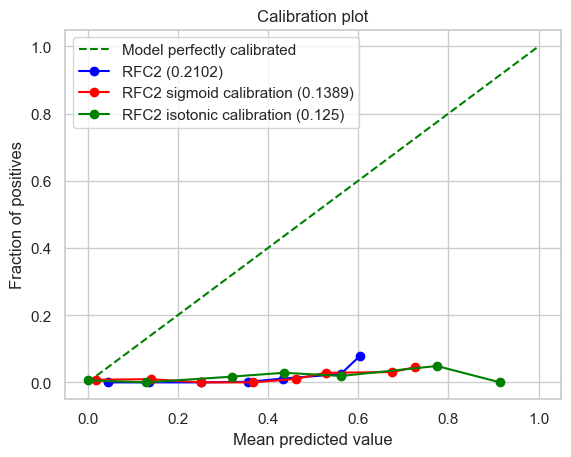

In [155]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Model perfectly calibrated", color='green')
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot')

RFC2.fit(X_train_resampled, y_train_resampled)

prob_pos_rfc = RFC2.predict_proba(X_train)[:, 1]
model_rfc_score = brier_score_loss(y_train, prob_pos_rfc, pos_label=y_train.max())
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_train, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "go-", color='blue', label=f'RFC2 ({round(model_rfc_score, 4)})')

calibrator_sigmoid = CalibratedClassifierCV(RFC2, cv='prefit', method='sigmoid')
calibrator_sigmoid.fit(X_train_resampled, y_train_resampled)
sigmoid_prob_pos_rfc = calibrator_sigmoid.predict_proba(X_oot)[:, 1]
calibrated_model_sigmoid_score = brier_score_loss(y_oot, sigmoid_prob_pos_rfc, pos_label=y_oot.max())
sigmoid_fraction_of_positives_rfc, sigmoid_mean_predicted_value_rfc = calibration_curve(y_oot, sigmoid_prob_pos_rfc, n_bins=10)
ax.plot(sigmoid_mean_predicted_value_rfc, sigmoid_fraction_of_positives_rfc, "go-", color='red', label=f'RFC2 sigmoid calibration ({round(calibrated_model_sigmoid_score, 4)})')

calibrator_isotonic = CalibratedClassifierCV(RFC2, cv='prefit', method='isotonic')
calibrator_isotonic.fit(X_train_resampled, y_train_resampled)
isotonic_prob_pos_rfc = calibrator_isotonic.predict_proba(X_oot)[:, 1]
calibrated_model_isotonic_score = brier_score_loss(y_oot, isotonic_prob_pos_rfc, pos_label=y_train.max())
isotonic_fraction_of_positives_rfc, isotonic_mean_predicted_value_rfc = calibration_curve(y_oot, isotonic_prob_pos_rfc, n_bins=10)
ax.plot(isotonic_mean_predicted_value_rfc, isotonic_fraction_of_positives_rfc, "go-", color='green', label=f'RFC2 isotonic calibration ({round(calibrated_model_isotonic_score, 4)})')


ax.legend(loc="upper left")
plt.show()

# ИТОГ

In [156]:
roc_auc_score(y_oot, RFC2.predict_proba(X_oot)[:, 1])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.3s finished


0.7017879948914432

In [157]:
roc_auc_score(y_oot, GBC2.predict_proba(X_oot)[:, 1])

0.7975095785440613

In [158]:
roc_auc_score(y_oot, cb.predict_proba(X_oot)[:, 1])

0.8237547892720307

In [160]:
base_metric = roc_auc_score(y_train, cb.predict_proba(X_train)[:, -1])
feature_importances = {}
for col in tqdm(X_train.columns):
    X_train_1 = X_train.copy()
    X_train_1[col] = X_train_1[col].sample(frac=1,random_state=13).reset_index(drop=True)
    feature_importances[col] = base_metric - roc_auc_score(y_train, cb.predict_proba(X_train_1)[:, -1])
features_ordered = list(list(zip(*sorted(feature_importances.items(),key=lambda tpl: tpl[1], reverse=True)))[0])
features_step = 2
results_dct_val = {}
results_dct_train = {}
results_train = []
results_val = []
num_factors=len(X_train.columns)
tickets=np.arange(1,(num_factors+num_factors%features_step+features_step)//features_step)*features_step+num_factors%features_step

for i, features_number in tqdm(enumerate(tickets[::-1])):
    clear_output(wait=True)
    features_curr = features_ordered[:features_number]
    model_new = cb
    model_new.fit(X_train[features_curr],y_train, verbose=False)
    results_dct_train[features_number] = roc_auc_score(y_train, model_new.predict_proba(X_train[features_curr])[:, -1]) * 100
    results_train.append(roc_auc_score(y_train, model_new.predict_proba(X_train[features_curr])[:, -1]) *100)
    results_dct_val[features_number] = roc_auc_score(y_val, model_new.predict_proba(X_val[features_curr])[:, -1]) * 100
    results_val.append(roc_auc_score(y_val, model_new.predict_proba(X_val[features_curr])[:, -1]) *100)

54it [06:03,  6.72s/it]


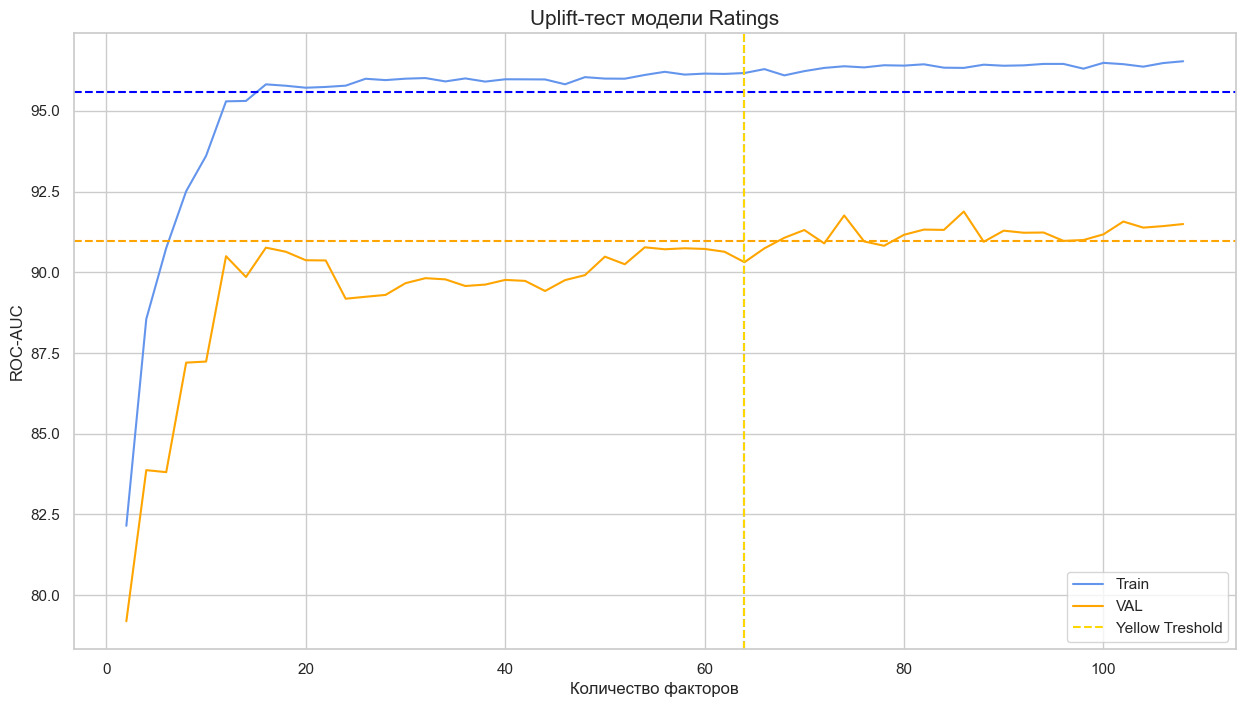

In [161]:
fig,ax=plt.subplots(figsize=(15,8))
ax.set_title('Uplift-тест модели Ratings',fontsize=15)
ax.set_ylabel('ROC-AUC')
ax.set_xlabel('Количество факторов')
ax.plot(tickets[:],results_train[::-1],label='Train',color='cornflowerblue')
ax.plot(tickets[:],results_val[::-1],label='VAL',color='orange')
ax.axvline(int(0.6 * len(features_ordered)), linestyle="dashed", color="gray")
ax.axhline(max(results_train) * 0.99, linestyle="dashed", color="blue")
ax.axhline(max(results_val) * 0.99, linestyle="dashed", color="orange")
yellow_numbers=[val for val in tickets if val<=len(features_ordered)*0.6]
ax.axvline(yellow_numbers[-1],color='gold',linestyle='--',label='Yellow Treshold')
ax.legend(loc='best')
plt.show()

Берем лучшие 18 фичей, где обучение на Train выходит на плато, а на Val почти соответствует уровню 99% от максимального

In [162]:
cb.fit(X_train[features_ordered[:18]], y_train)

Learning rate set to 0.020918
0:	learn: 0.6539146	total: 4.67ms	remaining: 4.67s
1:	learn: 0.6167835	total: 9.81ms	remaining: 4.89s
2:	learn: 0.5839766	total: 15ms	remaining: 4.99s
3:	learn: 0.5515045	total: 20.5ms	remaining: 5.12s
4:	learn: 0.5227808	total: 26.2ms	remaining: 5.21s
5:	learn: 0.4922116	total: 32ms	remaining: 5.29s
6:	learn: 0.4662688	total: 38ms	remaining: 5.39s
7:	learn: 0.4441584	total: 43.4ms	remaining: 5.39s
8:	learn: 0.4225451	total: 48.2ms	remaining: 5.31s
9:	learn: 0.4005461	total: 53.1ms	remaining: 5.26s
10:	learn: 0.3804874	total: 58.5ms	remaining: 5.26s
11:	learn: 0.3621976	total: 63.5ms	remaining: 5.23s
12:	learn: 0.3461176	total: 68.6ms	remaining: 5.21s
13:	learn: 0.3297468	total: 75.1ms	remaining: 5.29s
14:	learn: 0.3151193	total: 81.6ms	remaining: 5.36s
15:	learn: 0.3012797	total: 86.8ms	remaining: 5.34s
16:	learn: 0.2890603	total: 91.9ms	remaining: 5.32s
17:	learn: 0.2774879	total: 97.5ms	remaining: 5.32s
18:	learn: 0.2665687	total: 103ms	remaining: 5.32s

189:	learn: 0.0832492	total: 1.01s	remaining: 4.3s
190:	learn: 0.0831655	total: 1.01s	remaining: 4.29s
191:	learn: 0.0831255	total: 1.02s	remaining: 4.28s
192:	learn: 0.0830804	total: 1.02s	remaining: 4.28s
193:	learn: 0.0830108	total: 1.03s	remaining: 4.27s
194:	learn: 0.0829695	total: 1.03s	remaining: 4.26s
195:	learn: 0.0828951	total: 1.04s	remaining: 4.26s
196:	learn: 0.0828339	total: 1.04s	remaining: 4.25s
197:	learn: 0.0827801	total: 1.05s	remaining: 4.25s
198:	learn: 0.0827204	total: 1.05s	remaining: 4.24s
199:	learn: 0.0826503	total: 1.06s	remaining: 4.24s
200:	learn: 0.0825426	total: 1.06s	remaining: 4.23s
201:	learn: 0.0824910	total: 1.07s	remaining: 4.23s
202:	learn: 0.0824400	total: 1.07s	remaining: 4.22s
203:	learn: 0.0824012	total: 1.08s	remaining: 4.21s
204:	learn: 0.0823829	total: 1.08s	remaining: 4.21s
205:	learn: 0.0823397	total: 1.09s	remaining: 4.2s
206:	learn: 0.0822519	total: 1.09s	remaining: 4.19s
207:	learn: 0.0822037	total: 1.1s	remaining: 4.18s
208:	learn: 0.0

375:	learn: 0.0748710	total: 1.99s	remaining: 3.31s
376:	learn: 0.0748367	total: 2s	remaining: 3.3s
377:	learn: 0.0747825	total: 2s	remaining: 3.3s
378:	learn: 0.0747324	total: 2.01s	remaining: 3.29s
379:	learn: 0.0747056	total: 2.01s	remaining: 3.29s
380:	learn: 0.0746753	total: 2.02s	remaining: 3.28s
381:	learn: 0.0746231	total: 2.02s	remaining: 3.27s
382:	learn: 0.0746111	total: 2.03s	remaining: 3.27s
383:	learn: 0.0745351	total: 2.03s	remaining: 3.26s
384:	learn: 0.0744711	total: 2.04s	remaining: 3.26s
385:	learn: 0.0744498	total: 2.04s	remaining: 3.25s
386:	learn: 0.0744088	total: 2.05s	remaining: 3.25s
387:	learn: 0.0743496	total: 2.06s	remaining: 3.24s
388:	learn: 0.0743119	total: 2.06s	remaining: 3.24s
389:	learn: 0.0742670	total: 2.07s	remaining: 3.23s
390:	learn: 0.0742244	total: 2.07s	remaining: 3.23s
391:	learn: 0.0741955	total: 2.08s	remaining: 3.22s
392:	learn: 0.0741732	total: 2.08s	remaining: 3.22s
393:	learn: 0.0741301	total: 2.09s	remaining: 3.22s
394:	learn: 0.074112

571:	learn: 0.0684485	total: 3.01s	remaining: 2.25s
572:	learn: 0.0684362	total: 3.02s	remaining: 2.25s
573:	learn: 0.0684169	total: 3.02s	remaining: 2.24s
574:	learn: 0.0683873	total: 3.03s	remaining: 2.24s
575:	learn: 0.0683486	total: 3.03s	remaining: 2.23s
576:	learn: 0.0683218	total: 3.04s	remaining: 2.23s
577:	learn: 0.0682927	total: 3.04s	remaining: 2.22s
578:	learn: 0.0682702	total: 3.05s	remaining: 2.22s
579:	learn: 0.0682202	total: 3.05s	remaining: 2.21s
580:	learn: 0.0681766	total: 3.06s	remaining: 2.21s
581:	learn: 0.0681733	total: 3.07s	remaining: 2.2s
582:	learn: 0.0681579	total: 3.07s	remaining: 2.2s
583:	learn: 0.0681361	total: 3.08s	remaining: 2.19s
584:	learn: 0.0680942	total: 3.08s	remaining: 2.19s
585:	learn: 0.0680533	total: 3.09s	remaining: 2.18s
586:	learn: 0.0680404	total: 3.09s	remaining: 2.17s
587:	learn: 0.0680003	total: 3.1s	remaining: 2.17s
588:	learn: 0.0679914	total: 3.1s	remaining: 2.16s
589:	learn: 0.0679589	total: 3.1s	remaining: 2.16s
590:	learn: 0.067

761:	learn: 0.0643258	total: 3.99s	remaining: 1.25s
762:	learn: 0.0643110	total: 4s	remaining: 1.24s
763:	learn: 0.0643027	total: 4s	remaining: 1.24s
764:	learn: 0.0642885	total: 4.01s	remaining: 1.23s
765:	learn: 0.0642724	total: 4.02s	remaining: 1.23s
766:	learn: 0.0642625	total: 4.02s	remaining: 1.22s
767:	learn: 0.0642455	total: 4.03s	remaining: 1.22s
768:	learn: 0.0642034	total: 4.03s	remaining: 1.21s
769:	learn: 0.0641951	total: 4.04s	remaining: 1.21s
770:	learn: 0.0641872	total: 4.04s	remaining: 1.2s
771:	learn: 0.0641857	total: 4.05s	remaining: 1.2s
772:	learn: 0.0641725	total: 4.05s	remaining: 1.19s
773:	learn: 0.0641649	total: 4.06s	remaining: 1.19s
774:	learn: 0.0641460	total: 4.06s	remaining: 1.18s
775:	learn: 0.0641222	total: 4.07s	remaining: 1.17s
776:	learn: 0.0641179	total: 4.08s	remaining: 1.17s
777:	learn: 0.0640780	total: 4.08s	remaining: 1.16s
778:	learn: 0.0640550	total: 4.08s	remaining: 1.16s
779:	learn: 0.0640471	total: 4.09s	remaining: 1.15s
780:	learn: 0.064038

948:	learn: 0.0610811	total: 5s	remaining: 268ms
949:	learn: 0.0610752	total: 5s	remaining: 263ms
950:	learn: 0.0610580	total: 5.01s	remaining: 258ms
951:	learn: 0.0610512	total: 5.01s	remaining: 253ms
952:	learn: 0.0610273	total: 5.02s	remaining: 247ms
953:	learn: 0.0610232	total: 5.02s	remaining: 242ms
954:	learn: 0.0609959	total: 5.03s	remaining: 237ms
955:	learn: 0.0609936	total: 5.03s	remaining: 232ms
956:	learn: 0.0609771	total: 5.04s	remaining: 226ms
957:	learn: 0.0609605	total: 5.04s	remaining: 221ms
958:	learn: 0.0609522	total: 5.05s	remaining: 216ms
959:	learn: 0.0609398	total: 5.05s	remaining: 211ms
960:	learn: 0.0609301	total: 5.06s	remaining: 205ms
961:	learn: 0.0609180	total: 5.07s	remaining: 200ms
962:	learn: 0.0608916	total: 5.07s	remaining: 195ms
963:	learn: 0.0608766	total: 5.08s	remaining: 190ms
964:	learn: 0.0608611	total: 5.08s	remaining: 184ms
965:	learn: 0.0608424	total: 5.09s	remaining: 179ms
966:	learn: 0.0608261	total: 5.09s	remaining: 174ms
967:	learn: 0.0607

In [163]:
print(f'ROC-AUC OOT: {roc_auc_score(y_oot, cb.predict_proba(X_oot[features_ordered[:18]])[:, -1])}')

ROC-AUC OOT: 0.8816091954022989


In [164]:
for i in features_ordered[:18]:
    print(i, sep='\n')

rating_exra_rus
rating_moody_long
rating_fitch_long
rating_rusrate_rus
rating_exra_rus_shift_3
rating_exra_rus_shift_1
rating_AKM_rus
rating_AKM_rus_diff_12
rating_exra_rus_diff_1
rating_exra_rus_diff_6
rating_exra_rus_diff_12
rating_NRA_rus_shift_3
rating_NRA_rus
rating_exra_rus_shift_6
rating_NRA_rus_diff_12
rating_exra_rus_shift_12
rating_NRA_rus_diff_3
rating_fitch_rus


## Лучшая итоговая модель - CatBoost на апсэмплинге

In [165]:
with open("CB_rating_model.pkl", "wb") as f:
    pickle.dump(cb, f)

In [166]:
oot['pd'] = cb.predict_proba(X_oot[features_ordered[:18]])[:, 1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Вероятности выглядят приемлемо

## Расчет для 6 задания

In [167]:
avangard_bank = oot[oot['number'] == 2879]
expo_bank = oot[oot['number'] == 2998]
ros_bank = oot[oot['number'] == 2272]
alpha_bank = oot[oot['number'] == 1326]
loko_bank = oot[oot['number'] == 2707]

In [168]:
avangard_bank.iloc[-1]['pd']

0.011470566367330595

In [169]:
expo_bank.iloc[-1]['pd']

7.273028231542682e-05

In [170]:
ros_bank.iloc[-1]['pd']

0.008331289661684525

In [171]:
alpha_bank.iloc[-1]['pd']

0.042571354177865554

In [172]:
loko_bank.iloc[-1]['pd']

0.00016783764740745477

### Горизонт 1 год

In [173]:
n_simulations = 1000000

lgd=0.4

PD = [1 - (1 - avangard_bank.iloc[-1]['pd']**4),
      1 - (1 - expo_bank.iloc[-1]['pd'])**4,
      1 - (1 - ros_bank.iloc[-1]['pd'])**4,
      1 - (1 - alpha_bank.iloc[-1]['pd'])**4,
      1 - (1 - loko_bank.iloc[-1]['pd'])**4]

avangard_loss = np.random.binomial(n=1, p=PD[0], size=[n_simulations]) * 200000000 * lgd
expobank_loss = np.random.binomial(n=1, p=PD[1], size=[n_simulations]) * 200000000 * lgd
rosbank_loss = np.random.binomial(n=1, p=PD[2], size=[n_simulations]) * 200000000 * lgd
alfabank_loss = np.random.binomial(n=1, p=PD[3], size=[n_simulations]) * 200000000 * lgd
lokobank_loss = np.random.binomial(n=1, p=PD[4], size=[n_simulations]) * 200000000 * lgd

In [174]:
total_loss = map(sum, zip(avangard_loss, expobank_loss, rosbank_loss, alfabank_loss, lokobank_loss))

In [175]:
loss_df = pd.DataFrame({'Loss': list(total_loss)}).sort_values(by='Loss', ascending=False)
loss_df.head()

Loss
205399  240000000.0
684540  240000000.0
227564  240000000.0
995214  240000000.0
983129  160000000.0

In [176]:
loss_df.describe(percentiles=[0.999]).T

count        mean           std  min  50%        99.9%          max
Loss  1000000.0  15528640.0  3.273166e+07  0.0  0.0  160000000.0  240000000.0

VaR 99.9% = 160000000

EL = 15528640

UL = 144471360

### Горизонт 5 лет

In [177]:
n_simulations = 1000000

lgd=0.4

PD5 = [1 - (1 - avangard_bank.iloc[-1]['pd']**20),
      1 - (1 - expo_bank.iloc[-1]['pd'])**20,
      1 - (1 - ros_bank.iloc[-1]['pd'])**20,
      1 - (1 - alpha_bank.iloc[-1]['pd'])**20,
      1 - (1 - loko_bank.iloc[-1]['pd'])**20]

avangard_loss5 = np.random.binomial(n=1, p=PD5[0], size=[n_simulations]) * 200000000 * lgd
expobank_loss5 = np.random.binomial(n=1, p=PD5[1], size=[n_simulations]) * 200000000 * lgd
rosbank_loss5 = np.random.binomial(n=1, p=PD5[2], size=[n_simulations]) * 200000000 * lgd
alfabank_loss5 = np.random.binomial(n=1, p=PD5[3], size=[n_simulations]) * 200000000 * lgd
lokobank_loss5 = np.random.binomial(n=1, p=PD5[4], size=[n_simulations]) * 200000000 * lgd

In [178]:
total_loss5 = map(sum, zip(avangard_loss5, expobank_loss5, rosbank_loss5, alfabank_loss5, lokobank_loss5))

In [179]:
loss_df = pd.DataFrame({'Loss': list(total_loss5)}).sort_values(by='Loss', ascending=False)
loss_df.head()

Loss
910360  320000000.0
336853  240000000.0
865661  240000000.0
204776  240000000.0
665634  240000000.0

In [180]:
loss_df.describe(percentiles=[0.999]).T

count        mean           std  min         50%        99.9%  \
Loss  1000000.0  59193440.0  4.920876e+07  0.0  80000000.0  160000000.0   

              max  
Loss  320000000.0

VaR 99.9% = 160000000

EL = 59193440

UL = 100806560

### Задание b вариант 1

In [181]:
def get_maturity_slope(pd, a=0.11852, b=-0.05478):
    """
        DESCRIPTION:
        ------------
        Credit portfolios consist of instruments with different maturities. Both intuition and
        empirical evidence indicate that long-term credits are riskier than short-term credits. As a
        consequence, the capital requirement should increase with maturity.

        In order to derive the Basel maturity adjustment function, the grid of relative VaR figures
        (in relation to 2.5 years maturity) was smoothed by a statistical regression model.
        This includes the slope of the adjustment function with respect to M decreases as
        the PD increases.

        REFERENCE:
        ----------
        https://www.bis.org/bcbs/irbriskweight.pdf
        4.6. Maturity adjustments

        PARAMS:
        -------
        :param pd: array of PDs from portfolio
        :param a: slope adjustment coefficient 1
        :param b: slope adjustement coefficient 2
        :return maturity_slope: array of Smoothed (regression) maturity adjustment (smoothed over PDs)
    """
    return np.power((a + b * np.log(pd)), 2)


def get_maturity_adjusment(pd, m, y=2.5):
    """
        DESCRIPTION:
        ------------
        Maturity adjustments are the ratios of each of these VaR figures to the VaR
        of a “standard” maturity, which was set at 2.5 years, for each maturity and each rating grade.

        REFERENCE:
        ----------
        https://www.bis.org/bcbs/irbriskweight.pdf
        4.6. Maturity adjustments

        PARAMS:
        -------
        :param pd: array of PDs from portfolio
        :param tenor: array of tenors from portfolio or remaining term to maturity
        :param y: standard maturity, 2.5 years
        :return maturity_adj: array of maturity adjustments used in risk-capital allocation
    """
    slope = get_maturity_slope(pd)
    return np.divide(1 + (m - y) * slope, 1 - 1.5 * slope)

In [187]:
pd_array = np.array(PD5)

m = 2.5 #maturity adjustment

maturity_adj = get_maturity_adjusment(pd_array, m, y=2.5)
avangard_loss5 = np.random.binomial(n=1, p=PD5[0], size=[n_simulations]) * 200000000 * lgd * maturity_adj[0]
expobank_loss5 = np.random.binomial(n=1, p=PD5[1], size=[n_simulations]) * 200000000 * lgd * maturity_adj[1]
rosbank_loss5 = np.random.binomial(n=1, p=PD5[2], size=[n_simulations]) * 200000000 * lgd * maturity_adj[2]
alfabank_loss5 = np.random.binomial(n=1, p=PD5[3], size=[n_simulations]) * 200000000 * lgd * maturity_adj[3]
lokobank_loss5 = np.random.binomial(n=1, p=PD5[4], size=[n_simulations]) * 200000000 * lgd * maturity_adj[4]

In [188]:
total_loss5 = map(sum, zip(avangard_loss5, expobank_loss5, rosbank_loss5, alfabank_loss5, lokobank_loss5))
loss_df = pd.DataFrame({'Loss': list(total_loss5)}).sort_values(by='Loss', ascending=False)
loss_df.describe(percentiles=[0.999]).T

count          mean           std  min           50%         99.9%  \
Loss  1000000.0  6.202173e+07  5.207459e+07  0.0  8.272758e+07  2.097933e+08   

               max  
Loss  3.310951e+08

VaR 99.9% ~= 210000000

EL ~= 62000000

UL = 148000000

### Задание b вариант 2

In [190]:
def get_rho_asset_correlation(pd, k_factor=-50, rho_min=0.12, rho_max=0.24):
    """
        DESCRIPTION:
        -----------
        The single systematic risk factor needed in the ASRF model may be interpreted as reflecting
        the state of the global economy. The degree of the obligor’s exposure to the systematic risk
        factor is expressed by the asset correlation. The asset correlations, in short, show how the
        asset value (e.g. sum of all asset values of a firm) of one borrower depends on the asset
        value of another borrower.

        The asset correlation function is built of two limit correlations of 12% and 24% for very
        high and very low PDs (100% and 0%, respectively). Correlations between these limits are
        modelled by an exponential weighting function that displays the dependency on PD. The
        exponential function decreases rather fast; its pace is determined by the so-called
        “k-factor”, which is set at 50 for corporate exposures.

        REFERENCE:
        ----------
        https://www.bis.org/bcbs/irbriskweight.pdf
        5.2. Supervisory estimates of asset correlations for corporate, bank and sovereign exposures

        PARAMS:
        -------
        :param pd: arrays of PDs from portfolio
        :param k_factor: Set to 50 for corporates exposures
        :param rho_min: 12% min limit, for PDs = 100%
        :param rho_max: 14% max limit, for PDs = 0%
        :return rho: array of assets correlation
    """
    exponential_weights = np.divide((1 - np.exp(k_factor * pd)), (1 - np.exp(k_factor)))
    return rho_min * exponential_weights + rho_max * (1 - exponential_weights)

def conditional_pd(pd, rho, y):
    """
        DESCRIPTION:
        ------------
        The Vasicek model is a one period default model, i.e., loss only occurs when an 
        obligor defaults in a fixed time horizon. Based on Merton‘s firm-value model, to describe 
        the obligor’s default and its correlation structure, we assign each obligor a random
        variable called firm-value.

        The firm-value of obligor n is represented by a common, standard normally distributed factor
        Y component and an idiosyncratic standard normal noise component n.
        The Y factor is the state of the world or business cycle, usually called systematic factor.

        The probability of default of obligor n conditional to a realization of Y = y is given by
        this function.

        REFERENCE:
        ----------
        https://core.ac.uk/download/pdf/41778167.pdf

        PARAMS:
        -------
        :param pd: probability of default of obligor n
        :param rho: asset correlation, to be computed from IRB approach
        :param y: The Y factor is the state of the world or business cycle, usually called
        systematic factor.
        :return pd_conditional: conditional probability of default of obligor n to a realization of
        Y.
    """

    numerator = np.subtract(norm.ppf(pd), np.multiply(np.sqrt(rho), y))
    denominator = np.sqrt(1 - rho)
    return norm.cdf(np.divide(numerator, denominator))


def run_simulation(pd, ead, lgd, m, num_simulations=1000):
    """
        DESCRIPTION:
        ------------
        This functions runs a montecarlo simulation

        1) y is randomly generated from a normal distribution
        2) we generate a uniform continuous random variable
        3) we compare the random variable to pd to define if default there is
        4) if default compute loss = default_indicator * EAD * LGD * ma
        5) aggregate all losses
        PARAMS:
        -------
        :param pd: probability of default
        :param ead: exposure at risk
        :param lgd: loss given default
        :param num_simulations: number of simulation/iteration to be performed
        :return scenario_losses: array of losses
    """
    scenario_losses = np.array([])
    rho = get_rho_asset_correlation(pd)
    maturity_adj = get_maturity_adjusment(pd, m, y=2.5)
    for _ in range(num_simulations):
        y = np.random.normal(size=1)
        pd_cond = conditional_pd(pd, rho, y)
        uniform_random_variable = uniform.rvs(size=pd.size)
        default_indicator = (uniform_random_variable < pd_cond) * 1.0
        loss = default_indicator * ead * lgd * maturity_adj
        total_loss = loss.sum()
        scenario_losses = np.concatenate([scenario_losses, np.array([total_loss])])
    return scenario_losses

In [198]:
ead=200000000
scenario_losses = run_simulation(pd_array, ead, lgd, m, 1000)
scenario_losses_m = np.mean(scenario_losses)
var_999 = np.percentile(scenario_losses, 0.99)

In [199]:
scenario_losses_m

62184444.48497939

### задание 3

In [200]:
rho = get_rho_asset_correlation(pd_array)
WCDR = norm.cdf(np.sqrt(1/(1-rho)) * norm.ppf(PD) + np.sqrt(rho/(1-rho)) * norm.ppf(0.999))
K = (WCDR - PD) * lgd * ead 
K

array([1.71961459e+02, 1.01257473e+06, 1.38630570e+07, 2.97670194e+07,
       1.82705967e+06])

In [201]:
K.sum()

46469882.73173544

In [1]:
k = [1.71961459e+02, 1.01257473e+06, 1.38630570e+07, 2.97670194e+07,
       1.82705967e+06]

In [ ]:
k = 46469882.73173544 * 